# Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import os
from skimage.transform import resize
import pickle
from sklearn.model_selection import train_test_split


%matplotlib inline

# EDA

- "train.csv" file is available for downloading;
- The images are available as "train" and "test" files;
- The train files, "csv" and images will be splitted into train/test to build our models;
- The "test" image files will be used to generate the validation ".csv" file, which will be submitted as our solution for the competition 

In [2]:
file = pd.read_csv('data/train.csv')


In [3]:
file.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1738 entries, 0 to 1737
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   SOPInstanceUID  1738 non-null   object
 1   Target          1738 non-null   object
dtypes: object(2)
memory usage: 27.3+ KB


In [4]:
file.head()

SOPInstanceUID Target
0  1.2.826.0.1.3680043.8.498.10025629581362719970...     0 
1  1.2.826.0.1.3680043.8.498.10036150326276641158...    15 
2  1.2.826.0.1.3680043.8.498.10038426859954986240...    12 
3  1.2.826.0.1.3680043.8.498.10050991192143676483...    14 
4  1.2.826.0.1.3680043.8.498.10053309524595490852...     3

In [5]:
file['Target'].value_counts()


3            724
14           120
11           102
0             80
2             77
6             70
15            67
21            63
13 20         45
9 21          42
1             41
16            40
13            39
9             31
17            23
5             23
12            19
10            19
7             15
20            15
8             12
0 3           11
18            10
4              9
19             7
1 6            7
1 11 12        5
10 19          4
2 13 20        3
5 8            2
10 11 19       2
15 19          2
2 20           1
3 7            1
1 12           1
7 9            1
3 6            1
0 15           1
3 15           1
11 12          1
8 16           1
Name: Target, dtype: int64

## Gathering image files paths and new DF

In [6]:
from pathlib import Path


In [7]:
images_train = Path().cwd().glob("**/train/**/*.dcm")
img_train_path_lst = [path for path in images_train]


In [8]:
images_test = Path().cwd().glob("**/test/**/*.dcm")
img_test_path_lst = [path for path in images_test]


In [9]:
img_train_path_lst[10]

PosixPath('/Users/sgp/Documents/Ironhack/UNIFESP/data/train/train/551/1.2.826.0.1.3680043.8.498.12712269899134516855972869509868235185/1.2.826.0.1.3680043.8.498.92431415960645296627687224582731905308/1.2.826.0.1.3680043.8.498.95024973449301076445329863637538348478-c.dcm')

In [10]:
sopi_lst_train = []
for i in range(len(img_train_path_lst)):
    ds_meta = pydicom.read_file(img_train_path_lst[i])
    elem = ds_meta[0x0008, 0x0018]
    sopi_lst_train.append(elem.value)

In [11]:
sopi_lst_train[10]

'1.2.826.0.1.3680043.8.498.95024973449301076445329863637538348478'

In [12]:
file.loc[10,'SOPInstanceUID']

'1.2.826.0.1.3680043.8.498.10080310665124574896848143784790467773'

As one can see above, the order of the images from the "train" file does NOT match the order of the dataframe created from the "train.csv" file.

To solve this problem:
- a temporary dataframe will be created, containing the image ID 'SOPInstanceUID' and the file path;
- merge the temporary dataframe with the original, on the 'SOPInstanceUID' column.

In [13]:
temp_df = pd.DataFrame.from_dict({'SOPInstanceUID' : sopi_lst_train, 'Path' : img_train_path_lst})

In [14]:
final_df = file.merge(temp_df, on='SOPInstanceUID', how='left').dropna()

In [15]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1738 entries, 0 to 1737
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   SOPInstanceUID  1738 non-null   object
 1   Target          1738 non-null   object
 2   Path            1738 non-null   object
dtypes: object(3)
memory usage: 54.3+ KB


In [16]:
final_df.head()

SOPInstanceUID Target  \
0  1.2.826.0.1.3680043.8.498.10025629581362719970...     0    
1  1.2.826.0.1.3680043.8.498.10036150326276641158...    15    
2  1.2.826.0.1.3680043.8.498.10038426859954986240...    12    
3  1.2.826.0.1.3680043.8.498.10050991192143676483...    14    
4  1.2.826.0.1.3680043.8.498.10053309524595490852...     3    

                                                Path  
0  /Users/sgp/Documents/Ironhack/UNIFESP/data/tra...  
1  /Users/sgp/Documents/Ironhack/UNIFESP/data/tra...  
2  /Users/sgp/Documents/Ironhack/UNIFESP/data/tra...  
3  /Users/sgp/Documents/Ironhack/UNIFESP/data/tra...  
4  /Users/sgp/Documents/Ironhack/UNIFESP/data/tra...

In [17]:
final_df['Target'].value_counts()

3            724
14           120
11           102
0             80
2             77
6             70
15            67
21            63
13 20         45
9 21          42
1             41
16            40
13            39
9             31
17            23
5             23
12            19
10            19
7             15
20            15
8             12
0 3           11
18            10
4              9
19             7
1 6            7
1 11 12        5
10 19          4
2 13 20        3
5 8            2
10 11 19       2
15 19          2
2 20           1
3 7            1
1 12           1
7 9            1
3 6            1
0 15           1
3 15           1
11 12          1
8 16           1
Name: Target, dtype: int64

## Labels
Some of the images ("SOPInstanceUID") are classified in more than one cluster of anatomical region, as shown in the cell above. In the next steps, following the labels ID below, we'll expand the dataframe, so, images with more than one classification will be replicated showing only one classification at a time:

    Abdomen = 0
    Ankle = 1
    Cervical Spine = 2
    Chest = 3
    Clavicles = 4
    Elbow = 5
    Feet = 6
    Finger = 7
    Forearm = 8
    Hand = 9
    Hip = 10
    Knee = 11
    Lower Leg = 12
    Lumbar Spine = 13
    Others = 14
    Pelvis = 15
    Shoulder = 16
    Sinus = 17
    Skull = 18
    Thigh = 19
    Thoracic Spine = 20
    Wrist = 21

Note - Others indicates whether the sample contains image of non X-ray images that sometimes are misplaced in the PACS system as X-Ray (eg. esophagogram, densitometry).

In [18]:
def splitDataFrameList(df,target_column,separator):
    ''' df = dataframe to split,
    target_column = the column containing the values to split
    separator = the symbol used to perform the split
    returns: a dataframe with each entry for the target column separated, with each element moved into a new row. 
    The values in the other columns are duplicated across the newly divided rows.
    '''
    row_accumulator = []

    def splitListToRows(row, separator):
        split_row = row[target_column].split(separator)
        for s in split_row:
            new_row = row.to_dict()
            new_row[target_column] = s
            row_accumulator.append(new_row)

    df.apply(splitListToRows, axis=1, args = (separator, ))
    new_df = pd.DataFrame(row_accumulator)
    return new_df

In [19]:
lst_cols = [col for col in final_df.columns]


In [20]:
split_df = splitDataFrameList(final_df, lst_cols[1], " ")


In [21]:
split_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3618 entries, 0 to 3617
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   SOPInstanceUID  3618 non-null   object
 1   Target          3618 non-null   object
 2   Path            3618 non-null   object
dtypes: object(3)
memory usage: 84.9+ KB


In [22]:
file_clean = split_df[split_df['Target'] != '']
file_clean.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1880 entries, 0 to 3616
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   SOPInstanceUID  1880 non-null   object
 1   Target          1880 non-null   object
 2   Path            1880 non-null   object
dtypes: object(3)
memory usage: 58.8+ KB


For easier visualization, a column with the label name is added.

In [23]:
df_label_temp = file_clean.copy()
df_label_temp['Target'] = df_label_temp['Target'].astype(int)


In [24]:
# Creating a dictionary for the labels

anatomy = {
0 : 'Abdomen' ,
1 : 'Ankle' ,
2 : 'Cervical Spine',
3 : 'Chest' ,
4 : 'Clavicles' ,
5 : 'Elbow' ,
6 : 'Feet' ,
7 : 'Finger' ,
8 : 'Forearm' ,
9 : 'Hand' ,
10 : 'Hip' ,
11 : 'Knee' ,
12 : 'Lower Leg' ,
13 : 'Lumbar Spine' ,
14 : 'Others' ,
15 : 'Pelvis',
16 : 'Shoulder' ,
17 : 'Sinus' ,
18 : 'Skull' ,
19 : 'Thigh' ,
20 : 'Thoracic Spine',
21: 'Wrist',
}


In [25]:
df_label_temp['Anatomy'] = df_label_temp['Target'].map(anatomy)
data_labeled = df_label_temp.reset_index(drop=True)


In [26]:
data_labeled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1880 entries, 0 to 1879
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   SOPInstanceUID  1880 non-null   object
 1   Target          1880 non-null   int64 
 2   Path            1880 non-null   object
 3   Anatomy         1880 non-null   object
dtypes: int64(1), object(3)
memory usage: 58.9+ KB


In [27]:
data_labeled.head()

SOPInstanceUID  Target  \
0  1.2.826.0.1.3680043.8.498.10025629581362719970...       0   
1  1.2.826.0.1.3680043.8.498.10036150326276641158...      15   
2  1.2.826.0.1.3680043.8.498.10038426859954986240...      12   
3  1.2.826.0.1.3680043.8.498.10050991192143676483...      14   
4  1.2.826.0.1.3680043.8.498.10053309524595490852...       3   

                                                Path    Anatomy  
0  /Users/sgp/Documents/Ironhack/UNIFESP/data/tra...    Abdomen  
1  /Users/sgp/Documents/Ironhack/UNIFESP/data/tra...     Pelvis  
2  /Users/sgp/Documents/Ironhack/UNIFESP/data/tra...  Lower Leg  
3  /Users/sgp/Documents/Ironhack/UNIFESP/data/tra...     Others  
4  /Users/sgp/Documents/Ironhack/UNIFESP/data/tra...      Chest

In [28]:
data_labeled['Target'].value_counts()

3     738
14    120
11    110
21    105
0      92
13     87
2      81
6      78
9      74
15     71
20     64
1      54
16     41
12     26
5      25
10     25
17     23
7      17
8      15
19     15
18     10
4       9
Name: Target, dtype: int64

# Creating sample dataframe

In order to speed up the process, a sampled dataframe with few categories (labels) to be used in preliminary models

In [36]:
sample_df = data_labeled[(data_labeled['Target'] == 11) | (
    data_labeled['Target'] == 21)].reset_index(drop=True)

In [29]:
sample_df_6cat = data_labeled[(data_labeled['Target'] == 11) | (
                data_labeled['Target'] == 21) | (
                data_labeled['Target'] == 0) | (
                data_labeled['Target'] == 13) | (
                data_labeled['Target'] == 2) | (
                data_labeled['Target'] == 6)].reset_index(drop=True)

In [30]:
sample_df_6cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 553 entries, 0 to 552
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   SOPInstanceUID  553 non-null    object
 1   Target          553 non-null    int64 
 2   Path            553 non-null    object
 3   Anatomy         553 non-null    object
dtypes: int64(1), object(3)
memory usage: 17.4+ KB


In [31]:
sample_df_6cat.head()


SOPInstanceUID  Target  \
0  1.2.826.0.1.3680043.8.498.10025629581362719970...       0   
1  1.2.826.0.1.3680043.8.498.10065930002825553435...      13   
2  1.2.826.0.1.3680043.8.498.10107388868056003719...       0   
3  1.2.826.0.1.3680043.8.498.10135999234351484423...       2   
4  1.2.826.0.1.3680043.8.498.10159498614160056038...       6   

                                                Path         Anatomy  
0  /Users/sgp/Documents/Ironhack/UNIFESP/data/tra...         Abdomen  
1  /Users/sgp/Documents/Ironhack/UNIFESP/data/tra...    Lumbar Spine  
2  /Users/sgp/Documents/Ironhack/UNIFESP/data/tra...         Abdomen  
3  /Users/sgp/Documents/Ironhack/UNIFESP/data/tra...  Cervical Spine  
4  /Users/sgp/Documents/Ironhack/UNIFESP/data/tra...            Feet

In [39]:
# Creating a list with the path for each image of the sample_df

img_sample_lst = sample_df['Path'].tolist()

In [32]:
img_sample_lst_6cat = sample_df_6cat['Path'].tolist()

In [34]:
len(img_sample_lst_6cat)

553

In [41]:
img_train_lst = data_labeled['Path'].tolist()
len(img_train_lst)

1880

# Image display and pixel_array

## DICOM Metadata

In [42]:
image = img_sample_lst[1]
ds = pydicom.read_file(image)


In [43]:
ds

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 244
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Computed Radiography Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.826.0.1.3680043.8.498.10242799675195671634897807131985000448
(0002, 0010) Transfer Syntax UID                 UI: JPEG 2000 Image Compression (Lossless Only)
(0002, 0012) Implementation Class UID            UI: 1.2.826.0.1.3680043.2.1143.107.104.103.115.3.0.10
(0002, 0013) Implementation Version Name         SH: 'GDCM 3.0.10'
(0002, 0016) Source Application Entity Title     AE: 'gdcmconv'
-------------------------------------------------
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY']
(0008, 0012) Instance Creation Date              DA: ''
(0008, 0013) Instance Creation Time              TM: ''
(0008, 0016) SOP Class UID                       UI:

In [44]:
elem = ds[0x0008, 0x0018]
elem.value


'1.2.826.0.1.3680043.8.498.10242799675195671634897807131985000448'

## Image viewing

- Testing with on image from the sample list

In [82]:
image = img_train_lst[1]
ds = pydicom.read_file(image)


In [35]:
import numpy as np
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut

import matplotlib.pyplot as plt
%matplotlib inline


def read_xray(path, voi_lut = True, fix_monochrome = True):
    dicom = pydicom.read_file(path)
    
    # VOI LUT (if available by DICOM device) is used to transform raw DICOM data to "human-friendly" view
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
               
    # depending on this value, X-ray may look inverted - fix that:
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data
        
    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
        
    return data


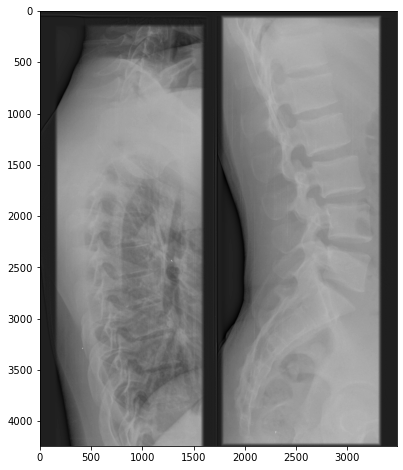

In [37]:
data = read_xray(img_sample_lst_6cat[120])
plt.figure(figsize=(8, 8))
plt.imshow(data, 'gray');


In [38]:
data

array([[38, 39, 40, ..., 33, 32, 31],
       [38, 39, 40, ..., 32, 31, 30],
       [36, 35, 36, ..., 32, 31, 33],
       ...,
       [31, 31, 31, ..., 32, 33, 33],
       [31, 31, 31, ..., 33, 33, 34],
       [31, 31, 31, ..., 31, 32, 33]], dtype=uint8)

In [39]:
data.shape

(4240, 3480)

### PCA for 1 image

- Applying PCA decomposition for one image matrix (pixel array)

In [40]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


In [41]:
scaled_img = StandardScaler().fit_transform(data)


In [42]:
pca = PCA(n_components=5)
pca_data = pca.fit_transform(scaled_img)


In [43]:
pca_data

array([[238.82913173,  82.18562952,  60.19808271,  12.55624836,
          1.63278118],
       [238.87756788,  82.093346  ,  60.43825731,  12.89552861,
          1.56976304],
       [238.9399411 ,  81.65080348,  60.46791271,  13.63219697,
          2.21833984],
       ...,
       [114.57205081, 114.02962995, 100.26683444,  26.77981944,
         15.22445393],
       [117.04779188, 117.39194788, 101.55074778,  27.01309721,
         15.12297756],
       [118.91748518, 119.49747827, 102.72129154,  26.97547837,
         15.00706191]])

In [44]:
pca_data.shape

(4240, 5)

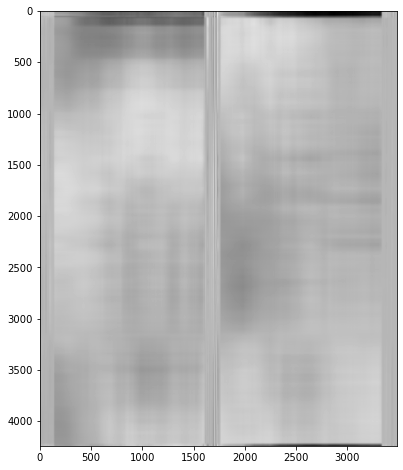

In [45]:
plt.figure(figsize=(8, 8))
plt.imshow(pca.inverse_transform(pca_data), cmap='gray');


In [47]:
pca_data_lst = []
for i in np.linspace(10,50,5):
    scaled_img = StandardScaler().fit_transform(data)
    pca = PCA(n_components=int(i))
    pca_data = pca.fit_transform(scaled_img)
    pca_data_lst.append(pca_data)
    

In [48]:
len(pca_data_lst)


5

In [49]:
pca_data_lst[0]

array([[ 2.38829132e+02,  8.21856295e+01,  6.01980827e+01, ...,
        -8.30975163e+00,  7.18564856e-01, -1.91664655e+00],
       [ 2.38877568e+02,  8.20933460e+01,  6.04382573e+01, ...,
        -7.15816230e+00,  1.32525465e+00, -1.90919308e+00],
       [ 2.38939941e+02,  8.16508035e+01,  6.04679127e+01, ...,
        -5.79405438e+00,  1.11449491e+00, -1.53600953e+00],
       ...,
       [ 1.14572051e+02,  1.14029630e+02,  1.00266834e+02, ...,
        -2.96750556e+00, -6.06953356e-02, -2.02352892e+00],
       [ 1.17047792e+02,  1.17391948e+02,  1.01550748e+02, ...,
        -3.68781506e+00,  2.71569232e-01, -2.24766869e+00],
       [ 1.18917485e+02,  1.19497478e+02,  1.02721292e+02, ...,
        -4.00091243e+00,  5.92992592e-01, -3.04091994e+00]])

In [50]:
plt.figure(figsize=(8, 8))
plt.imshow(pca.inverse_transform(pca_data_lst[1]), 'gray');

ValueError: shapes (4240,20) and (50,3480) not aligned: 20 (dim 1) != 50 (dim 0)

<Figure size 576x576 with 0 Axes>

# Vectorizing and PCA

## Building list of image vectors

* From the arrays (matrices) from "train" and "test" image files, will:
    - resize (1000 x 1000);
    - transform each one into a vector with a 1e6 elements;
    - standardize the vectors;
    - apply a decomposition method (PCA)

In [187]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from skimage.transform import resize
import pickle

In [52]:
vector_train_lst = []
for i in range(len(img_train_lst)):
    raw_img = read_xray(img_train_lst[i])
    image = resize(raw_img, (1000, 1000), anti_aliasing=True)
    vector_data = np.ravel(image)
    vector_train_lst.append(vector_data)
vector_train_array = np.array(vector_train_lst)
with open('vector_train_lst.pkl', 'wb') as f:
    pickle.dump(vector_train_lst, f)   
vector_train_array.shape


In [366]:
with open('vector_train_lst.pkl', 'rb') as f:
    vector_train_lst = pickle.load(f)

In [367]:
len(vector_train_lst)


1880

In [369]:
vector_train_array = np.array(vector_train_lst)

In [ ]:
fig, ax = plt.subplots(2,3, figsize=(8,8))
ax[0].imshow(vector_train_array[0].reshape(1000,1000), cmap=plt.cm.bone, interpolation='nearest')
ax[1].imshow(vector_train_array[1].reshape(1000,1000), cmap=plt.cm.bone, interpolation='nearest')
ax[2].imshow(vector_train_array[4].reshape(1000,1000), cmap=plt.cm.bone, interpolation='nearest')
ax[3].imshow(vector_train_array[6].reshape(1000,1000), cmap=plt.cm.bone, interpolation='nearest')
ax[4].imshow(vector_train_array[8].reshape(1000,1000), cmap=plt.cm.bone, interpolation='nearest')
ax[5].imshow(vector_train_array[9].reshape(1000,1000), cmap=plt.cm.bone, interpolation='nearest');


In [ ]:
vector_test_lst = []
for i in range(len(img_test_path_lst)):
    raw_img = read_xray(img_test_path_lst[i])
    image = resize(raw_img, (1000, 1000), anti_aliasing=True)
    vector_data = np.ravel(image)
    vector_test_lst.append(vector_data)
vector_test_array = np.array(vector_test_lst)
with open('vector_test_lst.pkl', 'wb') as f:
    pickle.dump(vector_test_lst, f)
vector_test_array.shape


In [205]:
with open('vector_sample_lst_2cat.pkl', 'rb') as file:
    vector_sample_lst_2cat = pickle.load(file)
    

In [53]:
len(vector_sample_lst_6cat)


553

In [52]:
vector_sample_lst_6cat = []
for i in range(len(img_sample_lst_6cat)):
    raw_img = read_xray(img_sample_lst_6cat[i])
    image = resize(raw_img, (1000, 1000), anti_aliasing=True)
    vector_data = np.ravel(image)
    vector_sample_lst_6cat.append(vector_data)
vector_sample_array_6cat = np.array(vector_sample_lst_6cat)
with open('vector_sample_lst_6cat.pkl', 'wb') as f:
    pickle.dump(vector_sample_lst_6cat, f)
vector_sample_array_6cat.shape


(553, 1000000)

## Splitting sample df

In [54]:
from sklearn.model_selection import train_test_split


In [55]:
X = vector_sample_array_6cat
y = sample_df_6cat['Target']


In [56]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1)


In [57]:
len(X_train)


442

## Pickle

In [55]:
import pickle


In [66]:
with open('vector_sample_lst.pkl', 'wb') as f:
    pickle.dump(vector_sample_lst, f)

In [78]:
with open('vector_sample_lst2.pkl', 'rb') as f:
    vector_sample_lst2 = pickle.load(f)
    

In [416]:
vector_train_array = np.array(vector_train_lst)

In [206]:
len(vector_sample_lst_2cat)

215

## Adding arrays to dataframe

In [ ]:
file.info()


In [ ]:
file['image_vector'] = vector_train_lst

In [ ]:
with open('vector_test_lst.pkl', 'wb') as test:
    pickle.dump(vector_test_lst, test)
    

In [ ]:
with open('vector_train_lst.pkl', 'wb') as train:
    pickle.dump(vector_train_array, train)
    

## PCA

In [58]:
scaler = StandardScaler()
scaled_img_train = scaler.fit_transform(X_train)

In [59]:
scaled_img_test = scaler.transform(X_test)

'arpack', svd_solver='randomized'

In [209]:
pca = PCA() 
pca.fit(scaled_img_train)

PCA()

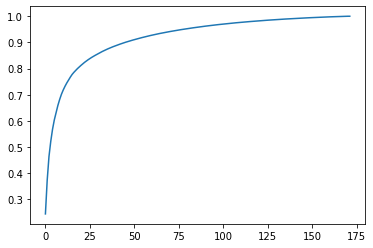

In [210]:
plt.plot(np.cumsum(pca.explained_variance_ratio_));

In [60]:
pca = PCA(n_components=50)
pca_data_train = pca.fit_transform(scaled_img_train)

In [61]:
pca_data_test = pca.transform(scaled_img_test)

In [62]:
pca_data_test.shape


(111, 50)

In [63]:
pca_data_train_df = pd.DataFrame(pca_data_train, columns = ['PC' + str(i) for i in range(pca.n_components_)])
pca_data_test_df = pd.DataFrame(pca_data_test, columns = ['PC' + str(i) for i in range(pca.n_components_)])


In [64]:
pca_data_train_df.head()

PC0         PC1         PC2         PC3         PC4         PC5  \
0  682.396119 -252.464218 -242.355127  396.679599  288.896376  129.312634   
1 -450.278364  415.632345  187.073188  257.186299 -304.192415 -219.899597   
2  116.400533 -411.861407  140.048893  -93.157853 -334.449091   21.467937   
3  574.586037  -86.276799 -102.284075  181.233160 -304.284739  334.494932   
4  671.946835 -370.304124 -350.743097   96.233614  352.037596  -68.659091   

          PC6         PC7         PC8         PC9  ...       PC40       PC41  \
0  202.045435  245.106469  138.940684  111.948886  ... -58.816754   5.176964   
1   49.482524  -19.484789  -49.460660  -96.780808  ...  68.746708 -65.015404   
2  -36.309419   38.473678 -221.774729 -127.092902  ... -51.599192 -51.105592   
3  -49.713942  -95.361572  -11.871382  115.331375  ...  18.606743  49.170018   
4  181.810407  160.046287 -100.198625 -124.995329  ...  58.021832  30.998203   

        PC42       PC43       PC44       PC45       PC46       PC47  \
0  92.355423 -15.952342 -21.176079  -8.223730  46.857786   9.216178   
1  77.559268 -17.914104  15.192920  15.522374  12.424593   7.877414   
2  65.045352  52.259292  39.095465  34.040571 -24.089306  -8.112450   
3  36.855505 -18.888718  -3.920767  -7.910201  82.060080 -56.095765   
4  45.359465 -14.585303 -84.610251  10.785549 -32.062438 -52.556082   

        PC48       PC49  
0 -47.469747  13.384463  
1 -10.923307 -17.862711  
2  14.582528  35.704452  
3  17.173100  93.064423  
4   3.720208  23.151696  

[5 rows x 50 columns]

## Aggregating the PCA data to the original dataframe 

In [65]:
train_pca_df = pd.concat([sample_df_6cat, pca_data_train_df], axis=1)
test_pca_df = pd.concat([sample_df_6cat, pca_data_train_df], axis=1)


In [235]:
# train_pca_df['Target'] = sample_final['Target'].astype(int)


In [66]:
train_pca_df.head()


SOPInstanceUID  Target  \
0  1.2.826.0.1.3680043.8.498.10025629581362719970...       0   
1  1.2.826.0.1.3680043.8.498.10065930002825553435...      13   
2  1.2.826.0.1.3680043.8.498.10107388868056003719...       0   
3  1.2.826.0.1.3680043.8.498.10135999234351484423...       2   
4  1.2.826.0.1.3680043.8.498.10159498614160056038...       6   

                                                Path         Anatomy  \
0  /Users/sgp/Documents/Ironhack/UNIFESP/data/tra...         Abdomen   
1  /Users/sgp/Documents/Ironhack/UNIFESP/data/tra...    Lumbar Spine   
2  /Users/sgp/Documents/Ironhack/UNIFESP/data/tra...         Abdomen   
3  /Users/sgp/Documents/Ironhack/UNIFESP/data/tra...  Cervical Spine   
4  /Users/sgp/Documents/Ironhack/UNIFESP/data/tra...            Feet   

          PC0         PC1         PC2         PC3         PC4         PC5  \
0  682.396119 -252.464218 -242.355127  396.679599  288.896376  129.312634   
1 -450.278364  415.632345  187.073188  257.186299 -304.192415 -219.899597   
2  116.400533 -411.861407  140.048893  -93.157853 -334.449091   21.467937   
3  574.586037  -86.276799 -102.284075  181.233160 -304.284739  334.494932   
4  671.946835 -370.304124 -350.743097   96.233614  352.037596  -68.659091   

   ...       PC40       PC41       PC42       PC43       PC44       PC45  \
0  ... -58.816754   5.176964  92.355423 -15.952342 -21.176079  -8.223730   
1  ...  68.746708 -65.015404  77.559268 -17.914104  15.192920  15.522374   
2  ... -51.599192 -51.105592  65.045352  52.259292  39.095465  34.040571   
3  ...  18.606743  49.170018  36.855505 -18.888718  -3.920767  -7.910201   
4  ...  58.021832  30.998203  45.359465 -14.585303 -84.610251  10.785549   

        PC46       PC47       PC48       PC49  
0  46.857786   9.216178 -47.469747  13.384463  
1  12.424593   7.877414 -10.923307 -17.862711  
2 -24.089306  -8.112450  14.582528  35.704452  
3  82.060080 -56.095765  17.173100  93.064423  
4 -32.062438 -52.556082   3.720208  23.151696  

[5 rows x 54 columns]

## Example of image recomposition from PCA data


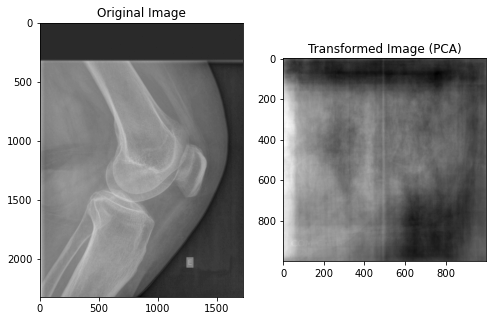

In [76]:
fig, ax = plt.subplots(1,2, figsize=(8,8))
ax[0].imshow(read_xray(sample_df_6cat.loc[548, 'Path']), 'gray')
ax[0].set_title("Original Image");
ax[1].imshow(pca.inverse_transform(pca_data_test_df.iloc[4,]).reshape(1000,1000), 'gray');
ax[1].set_title("Transformed Image (PCA)");

Original image

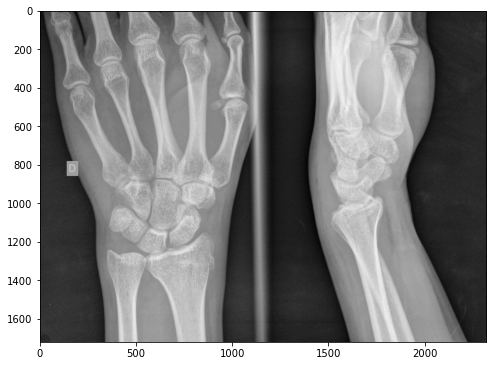

In [255]:
data = read_xray(sample_df.loc[39, 'Path'])
plt.figure(figsize=(8, 8))
plt.imshow(data, 'gray');

# Catboost

In [78]:
import catboost as cat
from sklearn.metrics import f1_score


In [79]:
cat_fit = cat.CatBoostClassifier(
    iterations=20000, depth=8, auto_class_weights="Balanced", od_type="Iter", od_wait=500)
cat_fit.fit(pca_data_train, y_train,
            eval_set=(pca_data_test, y_test))


Learning rate set to 0.033825
0:	learn: 1.7806868	test: 1.7876653	best: 1.7876653 (0)	total: 202ms	remaining: 1h 7m 22s
1:	learn: 1.7702168	test: 1.7845174	best: 1.7845174 (1)	total: 336ms	remaining: 55m 59s
2:	learn: 1.7613497	test: 1.7831383	best: 1.7831383 (2)	total: 582ms	remaining: 1h 4m 41s
3:	learn: 1.7503525	test: 1.7800822	best: 1.7800822 (3)	total: 882ms	remaining: 1h 13m 27s
4:	learn: 1.7408421	test: 1.7775321	best: 1.7775321 (4)	total: 1.15s	remaining: 1h 16m 58s
5:	learn: 1.7316721	test: 1.7734177	best: 1.7734177 (5)	total: 1.37s	remaining: 1h 16m 2s
6:	learn: 1.7187574	test: 1.7661272	best: 1.7661272 (6)	total: 1.6s	remaining: 1h 16m 26s
7:	learn: 1.7071235	test: 1.7575630	best: 1.7575630 (7)	total: 1.93s	remaining: 1h 20m 15s
8:	learn: 1.6945437	test: 1.7503668	best: 1.7503668 (8)	total: 2.12s	remaining: 1h 18m 29s
9:	learn: 1.6853714	test: 1.7472036	best: 1.7472036 (9)	total: 2.41s	remaining: 1h 20m 15s
10:	learn: 1.6739264	test: 1.7406151	best: 1.7406151 (10)	total: 2.

91:	learn: 1.0554869	test: 1.4709616	best: 1.4709616 (91)	total: 15.3s	remaining: 55m 12s
92:	learn: 1.0497072	test: 1.4697877	best: 1.4697877 (92)	total: 15.5s	remaining: 55m 8s
93:	learn: 1.0447912	test: 1.4679122	best: 1.4679122 (93)	total: 15.6s	remaining: 54m 59s
94:	learn: 1.0395088	test: 1.4665955	best: 1.4665955 (94)	total: 15.7s	remaining: 54m 45s
95:	learn: 1.0343912	test: 1.4636733	best: 1.4636733 (95)	total: 15.8s	remaining: 54m 31s
96:	learn: 1.0301716	test: 1.4628991	best: 1.4628991 (96)	total: 15.9s	remaining: 54m 22s
97:	learn: 1.0244937	test: 1.4597657	best: 1.4597657 (97)	total: 16s	remaining: 54m 8s
98:	learn: 1.0186639	test: 1.4576412	best: 1.4576412 (98)	total: 16.1s	remaining: 53m 52s
99:	learn: 1.0141770	test: 1.4561580	best: 1.4561580 (99)	total: 16.2s	remaining: 53m 38s
100:	learn: 1.0089050	test: 1.4545107	best: 1.4545107 (100)	total: 16.3s	remaining: 53m 23s
101:	learn: 1.0042941	test: 1.4518590	best: 1.4518590 (101)	total: 16.4s	remaining: 53m 11s
102:	learn

181:	learn: 0.6797243	test: 1.3230774	best: 1.3230774 (181)	total: 27.4s	remaining: 49m 42s
182:	learn: 0.6763222	test: 1.3215557	best: 1.3215557 (182)	total: 27.5s	remaining: 49m 37s
183:	learn: 0.6730714	test: 1.3193996	best: 1.3193996 (183)	total: 27.6s	remaining: 49m 32s
184:	learn: 0.6702228	test: 1.3180458	best: 1.3180458 (184)	total: 27.7s	remaining: 49m 27s
185:	learn: 0.6665928	test: 1.3160207	best: 1.3160207 (185)	total: 27.8s	remaining: 49m 21s
186:	learn: 0.6632561	test: 1.3146402	best: 1.3146402 (186)	total: 27.9s	remaining: 49m 15s
187:	learn: 0.6597150	test: 1.3108244	best: 1.3108244 (187)	total: 28s	remaining: 49m 8s
188:	learn: 0.6565350	test: 1.3089373	best: 1.3089373 (188)	total: 28.1s	remaining: 49m 1s
189:	learn: 0.6533891	test: 1.3077274	best: 1.3077274 (189)	total: 28.2s	remaining: 48m 55s
190:	learn: 0.6500163	test: 1.3053743	best: 1.3053743 (190)	total: 28.2s	remaining: 48m 49s
191:	learn: 0.6468628	test: 1.3029512	best: 1.3029512 (191)	total: 28.3s	remaining: 

271:	learn: 0.4360070	test: 1.1597858	best: 1.1597858 (271)	total: 39.9s	remaining: 48m 12s
272:	learn: 0.4340176	test: 1.1588604	best: 1.1588604 (272)	total: 40s	remaining: 48m 9s
273:	learn: 0.4321499	test: 1.1574617	best: 1.1574617 (273)	total: 40.1s	remaining: 48m 5s
274:	learn: 0.4301734	test: 1.1562836	best: 1.1562836 (274)	total: 40.2s	remaining: 48m 1s
275:	learn: 0.4282198	test: 1.1549921	best: 1.1549921 (275)	total: 40.3s	remaining: 48m 2s
276:	learn: 0.4262554	test: 1.1536407	best: 1.1536407 (276)	total: 40.6s	remaining: 48m 8s
277:	learn: 0.4245044	test: 1.1522407	best: 1.1522407 (277)	total: 40.8s	remaining: 48m 16s
278:	learn: 0.4225538	test: 1.1507636	best: 1.1507636 (278)	total: 41s	remaining: 48m 18s
279:	learn: 0.4207141	test: 1.1494251	best: 1.1494251 (279)	total: 41.2s	remaining: 48m 22s
280:	learn: 0.4189084	test: 1.1484653	best: 1.1484653 (280)	total: 41.4s	remaining: 48m 28s
281:	learn: 0.4169423	test: 1.1466750	best: 1.1466750 (281)	total: 41.6s	remaining: 48m 2

362:	learn: 0.3020125	test: 1.0656444	best: 1.0656444 (362)	total: 53.4s	remaining: 48m 8s
363:	learn: 0.3009127	test: 1.0647905	best: 1.0647905 (363)	total: 53.6s	remaining: 48m 10s
364:	learn: 0.2998860	test: 1.0643308	best: 1.0643308 (364)	total: 53.8s	remaining: 48m 14s
365:	learn: 0.2986624	test: 1.0634029	best: 1.0634029 (365)	total: 54.1s	remaining: 48m 20s
366:	learn: 0.2976949	test: 1.0626732	best: 1.0626732 (366)	total: 54.3s	remaining: 48m 22s
367:	learn: 0.2967200	test: 1.0621566	best: 1.0621566 (367)	total: 54.5s	remaining: 48m 26s
368:	learn: 0.2956723	test: 1.0614202	best: 1.0614202 (368)	total: 54.7s	remaining: 48m 31s
369:	learn: 0.2944175	test: 1.0599927	best: 1.0599927 (369)	total: 54.9s	remaining: 48m 32s
370:	learn: 0.2932124	test: 1.0592709	best: 1.0592709 (370)	total: 55.2s	remaining: 48m 38s
371:	learn: 0.2922913	test: 1.0588056	best: 1.0588056 (371)	total: 55.4s	remaining: 48m 44s
372:	learn: 0.2911851	test: 1.0578108	best: 1.0578108 (372)	total: 55.6s	remainin

454:	learn: 0.2249262	test: 1.0054119	best: 1.0054119 (454)	total: 1m 7s	remaining: 48m 36s
455:	learn: 0.2243181	test: 1.0048659	best: 1.0048659 (455)	total: 1m 8s	remaining: 48m 34s
456:	learn: 0.2237247	test: 1.0044375	best: 1.0044375 (456)	total: 1m 8s	remaining: 48m 31s
457:	learn: 0.2231301	test: 1.0043237	best: 1.0043237 (457)	total: 1m 8s	remaining: 48m 29s
458:	learn: 0.2225135	test: 1.0038205	best: 1.0038205 (458)	total: 1m 8s	remaining: 48m 26s
459:	learn: 0.2219075	test: 1.0030096	best: 1.0030096 (459)	total: 1m 8s	remaining: 48m 24s
460:	learn: 0.2212727	test: 1.0024026	best: 1.0024026 (460)	total: 1m 8s	remaining: 48m 22s
461:	learn: 0.2206446	test: 1.0021649	best: 1.0021649 (461)	total: 1m 8s	remaining: 48m 20s
462:	learn: 0.2200842	test: 1.0021981	best: 1.0021649 (461)	total: 1m 8s	remaining: 48m 18s
463:	learn: 0.2194751	test: 1.0017175	best: 1.0017175 (463)	total: 1m 8s	remaining: 48m 16s
464:	learn: 0.2188194	test: 1.0011666	best: 1.0011666 (464)	total: 1m 8s	remaini

544:	learn: 0.1783903	test: 0.9670187	best: 0.9670187 (544)	total: 1m 21s	remaining: 48m 12s
545:	learn: 0.1779425	test: 0.9660071	best: 0.9660071 (545)	total: 1m 21s	remaining: 48m 10s
546:	learn: 0.1775448	test: 0.9654117	best: 0.9654117 (546)	total: 1m 21s	remaining: 48m 8s
547:	learn: 0.1771422	test: 0.9652408	best: 0.9652408 (547)	total: 1m 21s	remaining: 48m 9s
548:	learn: 0.1767681	test: 0.9651657	best: 0.9651657 (548)	total: 1m 21s	remaining: 48m 7s
549:	learn: 0.1764231	test: 0.9650833	best: 0.9650833 (549)	total: 1m 21s	remaining: 48m 5s
550:	learn: 0.1759638	test: 0.9647137	best: 0.9647137 (550)	total: 1m 21s	remaining: 48m 3s
551:	learn: 0.1755559	test: 0.9643407	best: 0.9643407 (551)	total: 1m 21s	remaining: 48m
552:	learn: 0.1751510	test: 0.9642420	best: 0.9642420 (552)	total: 1m 21s	remaining: 47m 58s
553:	learn: 0.1746462	test: 0.9631944	best: 0.9631944 (553)	total: 1m 21s	remaining: 47m 56s
554:	learn: 0.1742762	test: 0.9631096	best: 0.9631096 (554)	total: 1m 22s	remai

633:	learn: 0.1473368	test: 0.9346613	best: 0.9346613 (633)	total: 1m 34s	remaining: 48m 16s
634:	learn: 0.1470560	test: 0.9341909	best: 0.9341909 (634)	total: 1m 35s	remaining: 48m 20s
635:	learn: 0.1468384	test: 0.9339841	best: 0.9339841 (635)	total: 1m 35s	remaining: 48m 25s
636:	learn: 0.1465115	test: 0.9333772	best: 0.9333772 (636)	total: 1m 35s	remaining: 48m 31s
637:	learn: 0.1462539	test: 0.9328811	best: 0.9328811 (637)	total: 1m 36s	remaining: 48m 35s
638:	learn: 0.1459889	test: 0.9327547	best: 0.9327547 (638)	total: 1m 36s	remaining: 48m 39s
639:	learn: 0.1458005	test: 0.9330405	best: 0.9327547 (638)	total: 1m 36s	remaining: 48m 43s
640:	learn: 0.1454612	test: 0.9328625	best: 0.9327547 (638)	total: 1m 36s	remaining: 48m 48s
641:	learn: 0.1451833	test: 0.9327575	best: 0.9327547 (638)	total: 1m 37s	remaining: 48m 50s
642:	learn: 0.1449119	test: 0.9325940	best: 0.9325940 (642)	total: 1m 37s	remaining: 48m 50s
643:	learn: 0.1446176	test: 0.9327701	best: 0.9325940 (642)	total: 1m 

723:	learn: 0.1249782	test: 0.9130835	best: 0.9128691 (719)	total: 1m 48s	remaining: 48m 4s
724:	learn: 0.1247532	test: 0.9132403	best: 0.9128691 (719)	total: 1m 48s	remaining: 48m 2s
725:	learn: 0.1245273	test: 0.9130232	best: 0.9128691 (719)	total: 1m 48s	remaining: 48m
726:	learn: 0.1243234	test: 0.9126473	best: 0.9126473 (726)	total: 1m 48s	remaining: 47m 59s
727:	learn: 0.1241117	test: 0.9124608	best: 0.9124608 (727)	total: 1m 48s	remaining: 47m 57s
728:	learn: 0.1238747	test: 0.9121814	best: 0.9121814 (728)	total: 1m 48s	remaining: 47m 55s
729:	learn: 0.1236210	test: 0.9116628	best: 0.9116628 (729)	total: 1m 48s	remaining: 47m 54s
730:	learn: 0.1234756	test: 0.9115357	best: 0.9115357 (730)	total: 1m 48s	remaining: 47m 52s
731:	learn: 0.1232648	test: 0.9112331	best: 0.9112331 (731)	total: 1m 49s	remaining: 47m 50s
732:	learn: 0.1230549	test: 0.9110863	best: 0.9110863 (732)	total: 1m 49s	remaining: 47m 49s
733:	learn: 0.1228543	test: 0.9109811	best: 0.9109811 (733)	total: 1m 49s	re

812:	learn: 0.1090904	test: 0.8953427	best: 0.8953427 (812)	total: 2m	remaining: 47m 20s
813:	learn: 0.1089201	test: 0.8953023	best: 0.8953023 (813)	total: 2m	remaining: 47m 19s
814:	learn: 0.1087697	test: 0.8951982	best: 0.8951982 (814)	total: 2m	remaining: 47m 18s
815:	learn: 0.1086446	test: 0.8949996	best: 0.8949996 (815)	total: 2m	remaining: 47m 16s
816:	learn: 0.1084739	test: 0.8947571	best: 0.8947571 (816)	total: 2m	remaining: 47m 15s
817:	learn: 0.1083525	test: 0.8947076	best: 0.8947076 (817)	total: 2m	remaining: 47m 13s
818:	learn: 0.1081788	test: 0.8944824	best: 0.8944824 (818)	total: 2m	remaining: 47m 12s
819:	learn: 0.1080712	test: 0.8942825	best: 0.8942825 (819)	total: 2m 1s	remaining: 47m 10s
820:	learn: 0.1079250	test: 0.8942779	best: 0.8942779 (820)	total: 2m 1s	remaining: 47m 9s
821:	learn: 0.1077694	test: 0.8939898	best: 0.8939898 (821)	total: 2m 1s	remaining: 47m 8s
822:	learn: 0.1076075	test: 0.8939013	best: 0.8939013 (822)	total: 2m 1s	remaining: 47m 6s
823:	learn: 

903:	learn: 0.0964424	test: 0.8798050	best: 0.8798050 (903)	total: 2m 12s	remaining: 46m 48s
904:	learn: 0.0962862	test: 0.8794741	best: 0.8794741 (904)	total: 2m 13s	remaining: 46m 46s
905:	learn: 0.0961580	test: 0.8794913	best: 0.8794741 (904)	total: 2m 13s	remaining: 46m 45s
906:	learn: 0.0960005	test: 0.8792982	best: 0.8792982 (906)	total: 2m 13s	remaining: 46m 43s
907:	learn: 0.0959685	test: 0.8788500	best: 0.8788500 (907)	total: 2m 13s	remaining: 46m 42s
908:	learn: 0.0958365	test: 0.8786824	best: 0.8786824 (908)	total: 2m 13s	remaining: 46m 41s
909:	learn: 0.0957410	test: 0.8784791	best: 0.8784791 (909)	total: 2m 13s	remaining: 46m 39s
910:	learn: 0.0956137	test: 0.8784338	best: 0.8784338 (910)	total: 2m 13s	remaining: 46m 38s
911:	learn: 0.0954541	test: 0.8783148	best: 0.8783148 (911)	total: 2m 13s	remaining: 46m 37s
912:	learn: 0.0953269	test: 0.8782050	best: 0.8782050 (912)	total: 2m 13s	remaining: 46m 36s
913:	learn: 0.0952161	test: 0.8781183	best: 0.8781183 (913)	total: 2m 

992:	learn: 0.0872301	test: 0.8672691	best: 0.8672217 (991)	total: 2m 24s	remaining: 46m 1s
993:	learn: 0.0871470	test: 0.8671661	best: 0.8671661 (993)	total: 2m 24s	remaining: 46m 1s
994:	learn: 0.0870787	test: 0.8670862	best: 0.8670862 (994)	total: 2m 24s	remaining: 46m
995:	learn: 0.0869972	test: 0.8667321	best: 0.8667321 (995)	total: 2m 24s	remaining: 45m 59s
996:	learn: 0.0868864	test: 0.8666426	best: 0.8666426 (996)	total: 2m 24s	remaining: 45m 57s
997:	learn: 0.0867863	test: 0.8665744	best: 0.8665744 (997)	total: 2m 24s	remaining: 45m 56s
998:	learn: 0.0867334	test: 0.8661493	best: 0.8661493 (998)	total: 2m 24s	remaining: 45m 55s
999:	learn: 0.0866336	test: 0.8660080	best: 0.8660080 (999)	total: 2m 24s	remaining: 45m 54s
1000:	learn: 0.0865375	test: 0.8658574	best: 0.8658574 (1000)	total: 2m 25s	remaining: 45m 53s
1001:	learn: 0.0864291	test: 0.8656741	best: 0.8656741 (1001)	total: 2m 25s	remaining: 45m 55s
1002:	learn: 0.0863445	test: 0.8655426	best: 0.8655426 (1002)	total: 2m 

1079:	learn: 0.0800082	test: 0.8579649	best: 0.8578897 (1073)	total: 2m 35s	remaining: 45m 20s
1080:	learn: 0.0799379	test: 0.8581601	best: 0.8578897 (1073)	total: 2m 35s	remaining: 45m 21s
1081:	learn: 0.0798379	test: 0.8580746	best: 0.8578897 (1073)	total: 2m 35s	remaining: 45m 22s
1082:	learn: 0.0797443	test: 0.8577029	best: 0.8577029 (1082)	total: 2m 35s	remaining: 45m 22s
1083:	learn: 0.0796454	test: 0.8575768	best: 0.8575768 (1083)	total: 2m 36s	remaining: 45m 23s
1084:	learn: 0.0796188	test: 0.8574093	best: 0.8574093 (1084)	total: 2m 36s	remaining: 45m 23s
1085:	learn: 0.0795378	test: 0.8573071	best: 0.8573071 (1085)	total: 2m 36s	remaining: 45m 25s
1086:	learn: 0.0795157	test: 0.8572761	best: 0.8572761 (1086)	total: 2m 36s	remaining: 45m 26s
1087:	learn: 0.0794439	test: 0.8570662	best: 0.8570662 (1087)	total: 2m 37s	remaining: 45m 29s
1088:	learn: 0.0794149	test: 0.8573417	best: 0.8570662 (1087)	total: 2m 37s	remaining: 45m 31s
1089:	learn: 0.0793046	test: 0.8570764	best: 0.857

1166:	learn: 0.0737337	test: 0.8486244	best: 0.8486244 (1166)	total: 2m 54s	remaining: 46m 57s
1167:	learn: 0.0736877	test: 0.8483761	best: 0.8483761 (1167)	total: 2m 55s	remaining: 47m 1s
1168:	learn: 0.0736068	test: 0.8477516	best: 0.8477516 (1168)	total: 2m 55s	remaining: 47m 2s
1169:	learn: 0.0735240	test: 0.8474264	best: 0.8474264 (1169)	total: 2m 55s	remaining: 47m 3s
1170:	learn: 0.0734522	test: 0.8474542	best: 0.8474264 (1169)	total: 2m 55s	remaining: 47m 2s
1171:	learn: 0.0733826	test: 0.8474609	best: 0.8474264 (1169)	total: 2m 55s	remaining: 47m 3s
1172:	learn: 0.0732955	test: 0.8472668	best: 0.8472668 (1172)	total: 2m 55s	remaining: 47m 3s
1173:	learn: 0.0732381	test: 0.8471261	best: 0.8471261 (1173)	total: 2m 55s	remaining: 47m 2s
1174:	learn: 0.0731626	test: 0.8470681	best: 0.8470681 (1174)	total: 2m 56s	remaining: 47m 1s
1175:	learn: 0.0731469	test: 0.8471685	best: 0.8470681 (1174)	total: 2m 56s	remaining: 47m
1176:	learn: 0.0730723	test: 0.8470909	best: 0.8470681 (1174)	

1254:	learn: 0.0687306	test: 0.8412418	best: 0.8412418 (1254)	total: 3m 11s	remaining: 47m 35s
1255:	learn: 0.0686747	test: 0.8411203	best: 0.8411203 (1255)	total: 3m 11s	remaining: 47m 36s
1256:	learn: 0.0686036	test: 0.8410142	best: 0.8410142 (1256)	total: 3m 11s	remaining: 47m 39s
1257:	learn: 0.0685632	test: 0.8411674	best: 0.8410142 (1256)	total: 3m 12s	remaining: 47m 41s
1258:	learn: 0.0684960	test: 0.8411235	best: 0.8410142 (1256)	total: 3m 12s	remaining: 47m 43s
1259:	learn: 0.0684610	test: 0.8410585	best: 0.8410142 (1256)	total: 3m 12s	remaining: 47m 44s
1260:	learn: 0.0684019	test: 0.8410163	best: 0.8410142 (1256)	total: 3m 12s	remaining: 47m 45s
1261:	learn: 0.0683516	test: 0.8409336	best: 0.8409336 (1261)	total: 3m 13s	remaining: 47m 46s
1262:	learn: 0.0682923	test: 0.8408256	best: 0.8408256 (1262)	total: 3m 13s	remaining: 47m 45s
1263:	learn: 0.0682628	test: 0.8407315	best: 0.8407315 (1263)	total: 3m 13s	remaining: 47m 44s
1264:	learn: 0.0682288	test: 0.8408361	best: 0.840

1342:	learn: 0.0644656	test: 0.8347175	best: 0.8347175 (1342)	total: 3m 25s	remaining: 47m 40s
1343:	learn: 0.0644227	test: 0.8345483	best: 0.8345483 (1343)	total: 3m 26s	remaining: 47m 39s
1344:	learn: 0.0643647	test: 0.8344585	best: 0.8344585 (1344)	total: 3m 26s	remaining: 47m 39s
1345:	learn: 0.0643128	test: 0.8343712	best: 0.8343712 (1345)	total: 3m 26s	remaining: 47m 38s
1346:	learn: 0.0642628	test: 0.8343978	best: 0.8343712 (1345)	total: 3m 26s	remaining: 47m 38s
1347:	learn: 0.0642135	test: 0.8343220	best: 0.8343220 (1347)	total: 3m 26s	remaining: 47m 37s
1348:	learn: 0.0641850	test: 0.8340951	best: 0.8340951 (1348)	total: 3m 26s	remaining: 47m 37s
1349:	learn: 0.0641377	test: 0.8340021	best: 0.8340021 (1349)	total: 3m 26s	remaining: 47m 36s
1350:	learn: 0.0640913	test: 0.8338644	best: 0.8338644 (1350)	total: 3m 26s	remaining: 47m 35s
1351:	learn: 0.0640507	test: 0.8337597	best: 0.8337597 (1351)	total: 3m 26s	remaining: 47m 34s
1352:	learn: 0.0639907	test: 0.8337597	best: 0.833

1431:	learn: 0.0611343	test: 0.8261612	best: 0.8261612 (1431)	total: 3m 37s	remaining: 47m 2s
1432:	learn: 0.0611198	test: 0.8261461	best: 0.8261461 (1432)	total: 3m 37s	remaining: 47m 1s
1433:	learn: 0.0610735	test: 0.8260206	best: 0.8260206 (1433)	total: 3m 37s	remaining: 47m
1434:	learn: 0.0610116	test: 0.8259265	best: 0.8259265 (1434)	total: 3m 37s	remaining: 46m 59s
1435:	learn: 0.0609679	test: 0.8256823	best: 0.8256823 (1435)	total: 3m 38s	remaining: 47m
1436:	learn: 0.0609538	test: 0.8256251	best: 0.8256251 (1436)	total: 3m 38s	remaining: 47m
1437:	learn: 0.0609317	test: 0.8255074	best: 0.8255074 (1437)	total: 3m 38s	remaining: 47m 1s
1438:	learn: 0.0608807	test: 0.8252858	best: 0.8252858 (1438)	total: 3m 38s	remaining: 47m 2s
1439:	learn: 0.0608311	test: 0.8250785	best: 0.8250785 (1439)	total: 3m 39s	remaining: 47m 3s
1440:	learn: 0.0607822	test: 0.8250517	best: 0.8250517 (1440)	total: 3m 39s	remaining: 47m 3s
1441:	learn: 0.0607561	test: 0.8250234	best: 0.8250234 (1441)	total:

1518:	learn: 0.0580075	test: 0.8197221	best: 0.8196875 (1515)	total: 3m 49s	remaining: 46m 36s
1519:	learn: 0.0579640	test: 0.8195094	best: 0.8195094 (1519)	total: 3m 50s	remaining: 46m 36s
1520:	learn: 0.0579152	test: 0.8194357	best: 0.8194357 (1520)	total: 3m 50s	remaining: 46m 37s
1521:	learn: 0.0579003	test: 0.8193854	best: 0.8193854 (1521)	total: 3m 50s	remaining: 46m 38s
1522:	learn: 0.0578921	test: 0.8193725	best: 0.8193725 (1522)	total: 3m 50s	remaining: 46m 37s
1523:	learn: 0.0578528	test: 0.8192795	best: 0.8192795 (1523)	total: 3m 50s	remaining: 46m 38s
1524:	learn: 0.0578087	test: 0.8192808	best: 0.8192795 (1523)	total: 3m 51s	remaining: 46m 39s
1525:	learn: 0.0577843	test: 0.8191520	best: 0.8191520 (1525)	total: 3m 51s	remaining: 46m 39s
1526:	learn: 0.0577732	test: 0.8192076	best: 0.8191520 (1525)	total: 3m 51s	remaining: 46m 39s
1527:	learn: 0.0577341	test: 0.8190646	best: 0.8190646 (1527)	total: 3m 51s	remaining: 46m 39s
1528:	learn: 0.0576908	test: 0.8191082	best: 0.819

1605:	learn: 0.0554393	test: 0.8155085	best: 0.8155085 (1605)	total: 4m 1s	remaining: 46m 5s
1606:	learn: 0.0554195	test: 0.8155244	best: 0.8155085 (1605)	total: 4m 1s	remaining: 46m 5s
1607:	learn: 0.0553912	test: 0.8154704	best: 0.8154704 (1607)	total: 4m 1s	remaining: 46m 5s
1608:	learn: 0.0553547	test: 0.8154522	best: 0.8154522 (1608)	total: 4m 1s	remaining: 46m 5s
1609:	learn: 0.0553459	test: 0.8153261	best: 0.8153261 (1609)	total: 4m 2s	remaining: 46m 6s
1610:	learn: 0.0553161	test: 0.8153008	best: 0.8153008 (1610)	total: 4m 2s	remaining: 46m 6s
1611:	learn: 0.0553085	test: 0.8152717	best: 0.8152717 (1611)	total: 4m 2s	remaining: 46m 8s
1612:	learn: 0.0552921	test: 0.8152873	best: 0.8152717 (1611)	total: 4m 2s	remaining: 46m 8s
1613:	learn: 0.0552676	test: 0.8155067	best: 0.8152717 (1611)	total: 4m 3s	remaining: 46m 8s
1614:	learn: 0.0552521	test: 0.8154994	best: 0.8152717 (1611)	total: 4m 3s	remaining: 46m 10s
1615:	learn: 0.0552017	test: 0.8154432	best: 0.8152717 (1611)	total: 

1694:	learn: 0.0530567	test: 0.8093309	best: 0.8093309 (1694)	total: 4m 14s	remaining: 45m 44s
1695:	learn: 0.0530166	test: 0.8092731	best: 0.8092731 (1695)	total: 4m 14s	remaining: 45m 44s
1696:	learn: 0.0530129	test: 0.8091371	best: 0.8091371 (1696)	total: 4m 14s	remaining: 45m 43s
1697:	learn: 0.0529756	test: 0.8090102	best: 0.8090102 (1697)	total: 4m 14s	remaining: 45m 43s
1698:	learn: 0.0529310	test: 0.8088858	best: 0.8088858 (1698)	total: 4m 14s	remaining: 45m 42s
1699:	learn: 0.0528933	test: 0.8088215	best: 0.8088215 (1699)	total: 4m 14s	remaining: 45m 42s
1700:	learn: 0.0528651	test: 0.8087949	best: 0.8087949 (1700)	total: 4m 14s	remaining: 45m 41s
1701:	learn: 0.0528327	test: 0.8085851	best: 0.8085851 (1701)	total: 4m 15s	remaining: 45m 41s
1702:	learn: 0.0528138	test: 0.8086930	best: 0.8085851 (1701)	total: 4m 15s	remaining: 45m 40s
1703:	learn: 0.0527961	test: 0.8086695	best: 0.8085851 (1701)	total: 4m 15s	remaining: 45m 39s
1704:	learn: 0.0527717	test: 0.8086970	best: 0.808

1782:	learn: 0.0510020	test: 0.8054752	best: 0.8054511 (1781)	total: 4m 25s	remaining: 45m 12s
1783:	learn: 0.0509743	test: 0.8053086	best: 0.8053086 (1783)	total: 4m 25s	remaining: 45m 11s
1784:	learn: 0.0509506	test: 0.8052852	best: 0.8052852 (1784)	total: 4m 25s	remaining: 45m 11s
1785:	learn: 0.0509287	test: 0.8053821	best: 0.8052852 (1784)	total: 4m 25s	remaining: 45m 10s
1786:	learn: 0.0508962	test: 0.8053440	best: 0.8052852 (1784)	total: 4m 25s	remaining: 45m 9s
1787:	learn: 0.0508876	test: 0.8053776	best: 0.8052852 (1784)	total: 4m 25s	remaining: 45m 9s
1788:	learn: 0.0508528	test: 0.8052800	best: 0.8052800 (1788)	total: 4m 26s	remaining: 45m 8s
1789:	learn: 0.0508439	test: 0.8052819	best: 0.8052800 (1788)	total: 4m 26s	remaining: 45m 7s
1790:	learn: 0.0508136	test: 0.8053059	best: 0.8052800 (1788)	total: 4m 26s	remaining: 45m 7s
1791:	learn: 0.0508081	test: 0.8052100	best: 0.8052100 (1791)	total: 4m 26s	remaining: 45m 6s
1792:	learn: 0.0508014	test: 0.8051518	best: 0.8051518 (

1869:	learn: 0.0491548	test: 0.8019911	best: 0.8019911 (1869)	total: 4m 36s	remaining: 44m 40s
1870:	learn: 0.0491327	test: 0.8020502	best: 0.8019911 (1869)	total: 4m 36s	remaining: 44m 39s
1871:	learn: 0.0491248	test: 0.8022404	best: 0.8019911 (1869)	total: 4m 36s	remaining: 44m 38s
1872:	learn: 0.0491035	test: 0.8024108	best: 0.8019911 (1869)	total: 4m 36s	remaining: 44m 37s
1873:	learn: 0.0490933	test: 0.8024537	best: 0.8019911 (1869)	total: 4m 36s	remaining: 44m 37s
1874:	learn: 0.0490667	test: 0.8023513	best: 0.8019911 (1869)	total: 4m 36s	remaining: 44m 36s
1875:	learn: 0.0490304	test: 0.8021931	best: 0.8019911 (1869)	total: 4m 36s	remaining: 44m 35s
1876:	learn: 0.0490110	test: 0.8021301	best: 0.8019911 (1869)	total: 4m 37s	remaining: 44m 34s
1877:	learn: 0.0489701	test: 0.8020300	best: 0.8019911 (1869)	total: 4m 37s	remaining: 44m 34s
1878:	learn: 0.0489314	test: 0.8020898	best: 0.8019911 (1869)	total: 4m 37s	remaining: 44m 33s
1879:	learn: 0.0489028	test: 0.8020896	best: 0.801

1957:	learn: 0.0473491	test: 0.8008991	best: 0.8004909 (1947)	total: 4m 47s	remaining: 44m 8s
1958:	learn: 0.0473226	test: 0.8008746	best: 0.8004909 (1947)	total: 4m 47s	remaining: 44m 7s
1959:	learn: 0.0473049	test: 0.8007884	best: 0.8004909 (1947)	total: 4m 47s	remaining: 44m 6s
1960:	learn: 0.0473010	test: 0.8007374	best: 0.8004909 (1947)	total: 4m 47s	remaining: 44m 6s
1961:	learn: 0.0472656	test: 0.8007108	best: 0.8004909 (1947)	total: 4m 47s	remaining: 44m 5s
1962:	learn: 0.0472601	test: 0.8006197	best: 0.8004909 (1947)	total: 4m 47s	remaining: 44m 4s
1963:	learn: 0.0472349	test: 0.8005876	best: 0.8004909 (1947)	total: 4m 47s	remaining: 44m 4s
1964:	learn: 0.0472044	test: 0.8005700	best: 0.8004909 (1947)	total: 4m 48s	remaining: 44m 3s
1965:	learn: 0.0471961	test: 0.8004905	best: 0.8004905 (1965)	total: 4m 48s	remaining: 44m 2s
1966:	learn: 0.0471804	test: 0.8003852	best: 0.8003852 (1966)	total: 4m 48s	remaining: 44m 2s
1967:	learn: 0.0471529	test: 0.8002660	best: 0.8002660 (1967

2044:	learn: 0.0457898	test: 0.7985161	best: 0.7982145 (2036)	total: 4m 58s	remaining: 43m 40s
2045:	learn: 0.0457676	test: 0.7984693	best: 0.7982145 (2036)	total: 4m 58s	remaining: 43m 39s
2046:	learn: 0.0457517	test: 0.7986171	best: 0.7982145 (2036)	total: 4m 58s	remaining: 43m 38s
2047:	learn: 0.0457451	test: 0.7985663	best: 0.7982145 (2036)	total: 4m 58s	remaining: 43m 38s
2048:	learn: 0.0457292	test: 0.7986468	best: 0.7982145 (2036)	total: 4m 58s	remaining: 43m 39s
2049:	learn: 0.0457054	test: 0.7985390	best: 0.7982145 (2036)	total: 4m 59s	remaining: 43m 39s
2050:	learn: 0.0456822	test: 0.7984035	best: 0.7982145 (2036)	total: 4m 59s	remaining: 43m 40s
2051:	learn: 0.0456660	test: 0.7984799	best: 0.7982145 (2036)	total: 4m 59s	remaining: 43m 42s
2052:	learn: 0.0456590	test: 0.7985179	best: 0.7982145 (2036)	total: 5m	remaining: 43m 42s
2053:	learn: 0.0456482	test: 0.7984218	best: 0.7982145 (2036)	total: 5m	remaining: 43m 42s
2054:	learn: 0.0456425	test: 0.7984293	best: 0.7982145 (20

2132:	learn: 0.0443122	test: 0.7950642	best: 0.7950642 (2132)	total: 5m 11s	remaining: 43m 32s
2133:	learn: 0.0442877	test: 0.7949599	best: 0.7949599 (2133)	total: 5m 12s	remaining: 43m 33s
2134:	learn: 0.0442836	test: 0.7949997	best: 0.7949599 (2133)	total: 5m 12s	remaining: 43m 33s
2135:	learn: 0.0442620	test: 0.7949218	best: 0.7949218 (2135)	total: 5m 12s	remaining: 43m 34s
2136:	learn: 0.0442392	test: 0.7949278	best: 0.7949218 (2135)	total: 5m 12s	remaining: 43m 34s
2137:	learn: 0.0442368	test: 0.7947891	best: 0.7947891 (2137)	total: 5m 13s	remaining: 43m 34s
2138:	learn: 0.0442138	test: 0.7946321	best: 0.7946321 (2138)	total: 5m 13s	remaining: 43m 35s
2139:	learn: 0.0441966	test: 0.7946731	best: 0.7946321 (2138)	total: 5m 13s	remaining: 43m 35s
2140:	learn: 0.0441751	test: 0.7945217	best: 0.7945217 (2140)	total: 5m 13s	remaining: 43m 36s
2141:	learn: 0.0441723	test: 0.7945357	best: 0.7945217 (2140)	total: 5m 13s	remaining: 43m 36s
2142:	learn: 0.0441596	test: 0.7945046	best: 0.794

2220:	learn: 0.0431529	test: 0.7921234	best: 0.7921234 (2220)	total: 5m 24s	remaining: 43m 13s
2221:	learn: 0.0431400	test: 0.7920654	best: 0.7920654 (2221)	total: 5m 24s	remaining: 43m 13s
2222:	learn: 0.0431172	test: 0.7920756	best: 0.7920654 (2221)	total: 5m 24s	remaining: 43m 13s
2223:	learn: 0.0430995	test: 0.7918700	best: 0.7918700 (2223)	total: 5m 24s	remaining: 43m 12s
2224:	learn: 0.0430817	test: 0.7919536	best: 0.7918700 (2223)	total: 5m 24s	remaining: 43m 12s
2225:	learn: 0.0430621	test: 0.7919005	best: 0.7918700 (2223)	total: 5m 24s	remaining: 43m 11s
2226:	learn: 0.0430437	test: 0.7920197	best: 0.7918700 (2223)	total: 5m 24s	remaining: 43m 11s
2227:	learn: 0.0430145	test: 0.7919600	best: 0.7918700 (2223)	total: 5m 24s	remaining: 43m 10s
2228:	learn: 0.0429921	test: 0.7920003	best: 0.7918700 (2223)	total: 5m 24s	remaining: 43m 10s
2229:	learn: 0.0429709	test: 0.7919383	best: 0.7918700 (2223)	total: 5m 24s	remaining: 43m 9s
2230:	learn: 0.0429661	test: 0.7920318	best: 0.7918

2308:	learn: 0.0418842	test: 0.7891986	best: 0.7891986 (2308)	total: 5m 35s	remaining: 42m 49s
2309:	learn: 0.0418744	test: 0.7892617	best: 0.7891986 (2308)	total: 5m 35s	remaining: 42m 48s
2310:	learn: 0.0418702	test: 0.7893004	best: 0.7891986 (2308)	total: 5m 35s	remaining: 42m 48s
2311:	learn: 0.0418504	test: 0.7892583	best: 0.7891986 (2308)	total: 5m 35s	remaining: 42m 47s
2312:	learn: 0.0418323	test: 0.7891929	best: 0.7891929 (2312)	total: 5m 35s	remaining: 42m 47s
2313:	learn: 0.0418264	test: 0.7891550	best: 0.7891550 (2313)	total: 5m 35s	remaining: 42m 46s
2314:	learn: 0.0418066	test: 0.7891537	best: 0.7891537 (2314)	total: 5m 35s	remaining: 42m 45s
2315:	learn: 0.0417942	test: 0.7891702	best: 0.7891537 (2314)	total: 5m 35s	remaining: 42m 45s
2316:	learn: 0.0417745	test: 0.7891229	best: 0.7891229 (2316)	total: 5m 36s	remaining: 42m 44s
2317:	learn: 0.0417601	test: 0.7891516	best: 0.7891229 (2316)	total: 5m 36s	remaining: 42m 44s
2318:	learn: 0.0417428	test: 0.7890887	best: 0.789

2395:	learn: 0.0408218	test: 0.7868296	best: 0.7866548 (2386)	total: 5m 53s	remaining: 43m 17s
2396:	learn: 0.0408158	test: 0.7868235	best: 0.7866548 (2386)	total: 5m 53s	remaining: 43m 17s
2397:	learn: 0.0408118	test: 0.7868445	best: 0.7866548 (2386)	total: 5m 53s	remaining: 43m 18s
2398:	learn: 0.0408102	test: 0.7867262	best: 0.7866548 (2386)	total: 5m 54s	remaining: 43m 18s
2399:	learn: 0.0407895	test: 0.7867600	best: 0.7866548 (2386)	total: 5m 54s	remaining: 43m 18s
2400:	learn: 0.0407827	test: 0.7867466	best: 0.7866548 (2386)	total: 5m 54s	remaining: 43m 18s
2401:	learn: 0.0407688	test: 0.7867324	best: 0.7866548 (2386)	total: 5m 54s	remaining: 43m 19s
2402:	learn: 0.0407621	test: 0.7867584	best: 0.7866548 (2386)	total: 5m 55s	remaining: 43m 19s
2403:	learn: 0.0407543	test: 0.7868037	best: 0.7866548 (2386)	total: 5m 55s	remaining: 43m 19s
2404:	learn: 0.0407494	test: 0.7869148	best: 0.7866548 (2386)	total: 5m 55s	remaining: 43m 19s
2405:	learn: 0.0407393	test: 0.7868690	best: 0.786

2482:	learn: 0.0398856	test: 0.7853826	best: 0.7850537 (2475)	total: 6m 5s	remaining: 42m 57s
2483:	learn: 0.0398717	test: 0.7853640	best: 0.7850537 (2475)	total: 6m 5s	remaining: 42m 57s
2484:	learn: 0.0398559	test: 0.7853434	best: 0.7850537 (2475)	total: 6m 5s	remaining: 42m 57s
2485:	learn: 0.0398498	test: 0.7853743	best: 0.7850537 (2475)	total: 6m 5s	remaining: 42m 57s
2486:	learn: 0.0398451	test: 0.7853636	best: 0.7850537 (2475)	total: 6m 5s	remaining: 42m 56s
2487:	learn: 0.0398249	test: 0.7854246	best: 0.7850537 (2475)	total: 6m 6s	remaining: 42m 56s
2488:	learn: 0.0398127	test: 0.7853898	best: 0.7850537 (2475)	total: 6m 6s	remaining: 42m 56s
2489:	learn: 0.0398059	test: 0.7852888	best: 0.7850537 (2475)	total: 6m 6s	remaining: 42m 55s
2490:	learn: 0.0397946	test: 0.7851603	best: 0.7850537 (2475)	total: 6m 6s	remaining: 42m 55s
2491:	learn: 0.0397916	test: 0.7849918	best: 0.7849918 (2491)	total: 6m 6s	remaining: 42m 54s
2492:	learn: 0.0397720	test: 0.7848847	best: 0.7848847 (2492

2570:	learn: 0.0388847	test: 0.7829800	best: 0.7829628 (2563)	total: 6m 16s	remaining: 42m 32s
2571:	learn: 0.0388743	test: 0.7829511	best: 0.7829511 (2571)	total: 6m 16s	remaining: 42m 31s
2572:	learn: 0.0388702	test: 0.7830204	best: 0.7829511 (2571)	total: 6m 16s	remaining: 42m 31s
2573:	learn: 0.0388642	test: 0.7829864	best: 0.7829511 (2571)	total: 6m 16s	remaining: 42m 30s
2574:	learn: 0.0388522	test: 0.7830025	best: 0.7829511 (2571)	total: 6m 16s	remaining: 42m 30s
2575:	learn: 0.0388461	test: 0.7829991	best: 0.7829511 (2571)	total: 6m 16s	remaining: 42m 29s
2576:	learn: 0.0388392	test: 0.7829619	best: 0.7829511 (2571)	total: 6m 17s	remaining: 42m 29s
2577:	learn: 0.0388269	test: 0.7828873	best: 0.7828873 (2577)	total: 6m 17s	remaining: 42m 28s
2578:	learn: 0.0388174	test: 0.7827952	best: 0.7827952 (2578)	total: 6m 17s	remaining: 42m 28s
2579:	learn: 0.0388031	test: 0.7827655	best: 0.7827655 (2579)	total: 6m 17s	remaining: 42m 27s
2580:	learn: 0.0387936	test: 0.7826719	best: 0.782

2657:	learn: 0.0380592	test: 0.7806512	best: 0.7806186 (2655)	total: 6m 28s	remaining: 42m 11s
2658:	learn: 0.0380534	test: 0.7805738	best: 0.7805738 (2658)	total: 6m 28s	remaining: 42m 11s
2659:	learn: 0.0380514	test: 0.7804900	best: 0.7804900 (2659)	total: 6m 28s	remaining: 42m 10s
2660:	learn: 0.0380496	test: 0.7803674	best: 0.7803674 (2660)	total: 6m 28s	remaining: 42m 10s
2661:	learn: 0.0380391	test: 0.7803879	best: 0.7803674 (2660)	total: 6m 28s	remaining: 42m 9s
2662:	learn: 0.0380276	test: 0.7803365	best: 0.7803365 (2662)	total: 6m 28s	remaining: 42m 8s
2663:	learn: 0.0380111	test: 0.7802988	best: 0.7802988 (2663)	total: 6m 28s	remaining: 42m 8s
2664:	learn: 0.0379952	test: 0.7802602	best: 0.7802602 (2664)	total: 6m 28s	remaining: 42m 7s
2665:	learn: 0.0379788	test: 0.7801955	best: 0.7801955 (2665)	total: 6m 28s	remaining: 42m 7s
2666:	learn: 0.0379726	test: 0.7801997	best: 0.7801955 (2665)	total: 6m 28s	remaining: 42m 6s
2667:	learn: 0.0379595	test: 0.7800932	best: 0.7800932 (

2744:	learn: 0.0371863	test: 0.7784224	best: 0.7783721 (2743)	total: 6m 38s	remaining: 41m 46s
2745:	learn: 0.0371795	test: 0.7783344	best: 0.7783344 (2745)	total: 6m 38s	remaining: 41m 45s
2746:	learn: 0.0371732	test: 0.7781835	best: 0.7781835 (2746)	total: 6m 38s	remaining: 41m 45s
2747:	learn: 0.0371647	test: 0.7781793	best: 0.7781793 (2747)	total: 6m 38s	remaining: 41m 44s
2748:	learn: 0.0371630	test: 0.7780259	best: 0.7780259 (2748)	total: 6m 39s	remaining: 41m 44s
2749:	learn: 0.0371530	test: 0.7780118	best: 0.7780118 (2749)	total: 6m 39s	remaining: 41m 43s
2750:	learn: 0.0371414	test: 0.7779494	best: 0.7779494 (2750)	total: 6m 39s	remaining: 41m 43s
2751:	learn: 0.0371366	test: 0.7779655	best: 0.7779494 (2750)	total: 6m 39s	remaining: 41m 42s
2752:	learn: 0.0371247	test: 0.7779085	best: 0.7779085 (2752)	total: 6m 39s	remaining: 41m 42s
2753:	learn: 0.0371185	test: 0.7778751	best: 0.7778751 (2753)	total: 6m 39s	remaining: 41m 42s
2754:	learn: 0.0371148	test: 0.7779147	best: 0.777

2833:	learn: 0.0364329	test: 0.7755384	best: 0.7755028 (2830)	total: 6m 50s	remaining: 41m 24s
2834:	learn: 0.0364212	test: 0.7755772	best: 0.7755028 (2830)	total: 6m 50s	remaining: 41m 23s
2835:	learn: 0.0364115	test: 0.7755429	best: 0.7755028 (2830)	total: 6m 50s	remaining: 41m 23s
2836:	learn: 0.0364060	test: 0.7754164	best: 0.7754164 (2836)	total: 6m 50s	remaining: 41m 22s
2837:	learn: 0.0363876	test: 0.7754707	best: 0.7754164 (2836)	total: 6m 50s	remaining: 41m 22s
2838:	learn: 0.0363840	test: 0.7753231	best: 0.7753231 (2838)	total: 6m 50s	remaining: 41m 21s
2839:	learn: 0.0363656	test: 0.7753222	best: 0.7753222 (2839)	total: 6m 50s	remaining: 41m 21s
2840:	learn: 0.0363539	test: 0.7753209	best: 0.7753209 (2840)	total: 6m 50s	remaining: 41m 20s
2841:	learn: 0.0363441	test: 0.7753357	best: 0.7753209 (2840)	total: 6m 50s	remaining: 41m 20s
2842:	learn: 0.0363364	test: 0.7753394	best: 0.7753209 (2840)	total: 6m 50s	remaining: 41m 19s
2843:	learn: 0.0363213	test: 0.7753141	best: 0.775

2920:	learn: 0.0356765	test: 0.7740564	best: 0.7740564 (2920)	total: 7m 1s	remaining: 41m 3s
2921:	learn: 0.0356640	test: 0.7740122	best: 0.7740122 (2921)	total: 7m 1s	remaining: 41m 2s
2922:	learn: 0.0356541	test: 0.7740322	best: 0.7740122 (2921)	total: 7m 1s	remaining: 41m 2s
2923:	learn: 0.0356463	test: 0.7741053	best: 0.7740122 (2921)	total: 7m 1s	remaining: 41m 1s
2924:	learn: 0.0356432	test: 0.7740406	best: 0.7740122 (2921)	total: 7m 1s	remaining: 41m 1s
2925:	learn: 0.0356417	test: 0.7739013	best: 0.7739013 (2925)	total: 7m 1s	remaining: 41m
2926:	learn: 0.0356320	test: 0.7737938	best: 0.7737938 (2926)	total: 7m 1s	remaining: 41m
2927:	learn: 0.0356216	test: 0.7738900	best: 0.7737938 (2926)	total: 7m 2s	remaining: 41m 1s
2928:	learn: 0.0356168	test: 0.7737736	best: 0.7737736 (2928)	total: 7m 2s	remaining: 41m 1s
2929:	learn: 0.0356114	test: 0.7737263	best: 0.7737263 (2929)	total: 7m 2s	remaining: 41m 2s
2930:	learn: 0.0355990	test: 0.7737139	best: 0.7737139 (2930)	total: 7m 2s	r

3008:	learn: 0.0350446	test: 0.7727654	best: 0.7726634 (2965)	total: 7m 12s	remaining: 40m 44s
3009:	learn: 0.0350421	test: 0.7726956	best: 0.7726634 (2965)	total: 7m 13s	remaining: 40m 45s
3010:	learn: 0.0350287	test: 0.7726601	best: 0.7726601 (3010)	total: 7m 13s	remaining: 40m 45s
3011:	learn: 0.0350251	test: 0.7725969	best: 0.7725969 (3011)	total: 7m 13s	remaining: 40m 46s
3012:	learn: 0.0350198	test: 0.7725914	best: 0.7725914 (3012)	total: 7m 13s	remaining: 40m 46s
3013:	learn: 0.0350043	test: 0.7725635	best: 0.7725635 (3013)	total: 7m 14s	remaining: 40m 47s
3014:	learn: 0.0349949	test: 0.7725943	best: 0.7725635 (3013)	total: 7m 14s	remaining: 40m 47s
3015:	learn: 0.0349933	test: 0.7725288	best: 0.7725288 (3015)	total: 7m 14s	remaining: 40m 48s
3016:	learn: 0.0349918	test: 0.7723993	best: 0.7723993 (3016)	total: 7m 15s	remaining: 40m 48s
3017:	learn: 0.0349835	test: 0.7724123	best: 0.7723993 (3016)	total: 7m 15s	remaining: 40m 49s
3018:	learn: 0.0349790	test: 0.7724369	best: 0.772

3095:	learn: 0.0344224	test: 0.7707767	best: 0.7707344 (3086)	total: 7m 24s	remaining: 40m 27s
3096:	learn: 0.0344133	test: 0.7707636	best: 0.7707344 (3086)	total: 7m 24s	remaining: 40m 27s
3097:	learn: 0.0344091	test: 0.7706317	best: 0.7706317 (3097)	total: 7m 24s	remaining: 40m 27s
3098:	learn: 0.0344080	test: 0.7705150	best: 0.7705150 (3098)	total: 7m 25s	remaining: 40m 27s
3099:	learn: 0.0344009	test: 0.7704953	best: 0.7704953 (3099)	total: 7m 25s	remaining: 40m 27s
3100:	learn: 0.0343861	test: 0.7705083	best: 0.7704953 (3099)	total: 7m 25s	remaining: 40m 27s
3101:	learn: 0.0343762	test: 0.7703565	best: 0.7703565 (3101)	total: 7m 25s	remaining: 40m 28s
3102:	learn: 0.0343700	test: 0.7703401	best: 0.7703401 (3102)	total: 7m 26s	remaining: 40m 29s
3103:	learn: 0.0343573	test: 0.7703730	best: 0.7703401 (3102)	total: 7m 26s	remaining: 40m 30s
3104:	learn: 0.0343435	test: 0.7703322	best: 0.7703322 (3104)	total: 7m 26s	remaining: 40m 30s
3105:	learn: 0.0343424	test: 0.7702489	best: 0.770

3183:	learn: 0.0338162	test: 0.7690017	best: 0.7686697 (3172)	total: 7m 36s	remaining: 40m 11s
3184:	learn: 0.0338048	test: 0.7689384	best: 0.7686697 (3172)	total: 7m 36s	remaining: 40m 11s
3185:	learn: 0.0337975	test: 0.7690765	best: 0.7686697 (3172)	total: 7m 36s	remaining: 40m 11s
3186:	learn: 0.0337898	test: 0.7690412	best: 0.7686697 (3172)	total: 7m 37s	remaining: 40m 11s
3187:	learn: 0.0337786	test: 0.7691234	best: 0.7686697 (3172)	total: 7m 37s	remaining: 40m 10s
3188:	learn: 0.0337654	test: 0.7690955	best: 0.7686697 (3172)	total: 7m 37s	remaining: 40m 10s
3189:	learn: 0.0337596	test: 0.7691760	best: 0.7686697 (3172)	total: 7m 37s	remaining: 40m 9s
3190:	learn: 0.0337535	test: 0.7691974	best: 0.7686697 (3172)	total: 7m 37s	remaining: 40m 9s
3191:	learn: 0.0337425	test: 0.7692006	best: 0.7686697 (3172)	total: 7m 37s	remaining: 40m 8s
3192:	learn: 0.0337373	test: 0.7692602	best: 0.7686697 (3172)	total: 7m 37s	remaining: 40m 8s
3193:	learn: 0.0337296	test: 0.7692549	best: 0.7686697

3270:	learn: 0.0332104	test: 0.7676361	best: 0.7676361 (3270)	total: 7m 47s	remaining: 39m 52s
3271:	learn: 0.0332040	test: 0.7675756	best: 0.7675756 (3271)	total: 7m 47s	remaining: 39m 52s
3272:	learn: 0.0331993	test: 0.7675861	best: 0.7675756 (3271)	total: 7m 48s	remaining: 39m 52s
3273:	learn: 0.0331974	test: 0.7675337	best: 0.7675337 (3273)	total: 7m 48s	remaining: 39m 51s
3274:	learn: 0.0331957	test: 0.7673749	best: 0.7673749 (3274)	total: 7m 48s	remaining: 39m 51s
3275:	learn: 0.0331828	test: 0.7673746	best: 0.7673746 (3275)	total: 7m 48s	remaining: 39m 50s
3276:	learn: 0.0331722	test: 0.7673684	best: 0.7673684 (3276)	total: 7m 48s	remaining: 39m 50s
3277:	learn: 0.0331664	test: 0.7673572	best: 0.7673572 (3277)	total: 7m 48s	remaining: 39m 50s
3278:	learn: 0.0331610	test: 0.7674615	best: 0.7673572 (3277)	total: 7m 48s	remaining: 39m 49s
3279:	learn: 0.0331600	test: 0.7674173	best: 0.7673572 (3277)	total: 7m 48s	remaining: 39m 49s
3280:	learn: 0.0331564	test: 0.7674810	best: 0.767

3359:	learn: 0.0326311	test: 0.7671664	best: 0.7671664 (3359)	total: 7m 58s	remaining: 39m 31s
3360:	learn: 0.0326208	test: 0.7671391	best: 0.7671391 (3360)	total: 7m 59s	remaining: 39m 31s
3361:	learn: 0.0326191	test: 0.7670848	best: 0.7670848 (3361)	total: 7m 59s	remaining: 39m 31s
3362:	learn: 0.0326090	test: 0.7670994	best: 0.7670848 (3361)	total: 7m 59s	remaining: 39m 31s
3363:	learn: 0.0326001	test: 0.7670801	best: 0.7670801 (3363)	total: 7m 59s	remaining: 39m 30s
3364:	learn: 0.0325968	test: 0.7671491	best: 0.7670801 (3363)	total: 7m 59s	remaining: 39m 30s
3365:	learn: 0.0325923	test: 0.7671259	best: 0.7670801 (3363)	total: 7m 59s	remaining: 39m 30s
3366:	learn: 0.0325852	test: 0.7672431	best: 0.7670801 (3363)	total: 7m 59s	remaining: 39m 30s
3367:	learn: 0.0325830	test: 0.7671937	best: 0.7670801 (3363)	total: 7m 59s	remaining: 39m 29s
3368:	learn: 0.0325763	test: 0.7671525	best: 0.7670801 (3363)	total: 8m	remaining: 39m 29s
3369:	learn: 0.0325630	test: 0.7671232	best: 0.7670801

3448:	learn: 0.0320768	test: 0.7658124	best: 0.7658124 (3448)	total: 8m 10s	remaining: 39m 15s
3449:	learn: 0.0320742	test: 0.7657203	best: 0.7657203 (3449)	total: 8m 10s	remaining: 39m 14s
3450:	learn: 0.0320729	test: 0.7656967	best: 0.7656967 (3450)	total: 8m 10s	remaining: 39m 14s
3451:	learn: 0.0320633	test: 0.7655150	best: 0.7655150 (3451)	total: 8m 11s	remaining: 39m 13s
3452:	learn: 0.0320563	test: 0.7655416	best: 0.7655150 (3451)	total: 8m 11s	remaining: 39m 13s
3453:	learn: 0.0320527	test: 0.7654592	best: 0.7654592 (3453)	total: 8m 11s	remaining: 39m 13s
3454:	learn: 0.0320484	test: 0.7654571	best: 0.7654571 (3454)	total: 8m 11s	remaining: 39m 12s
3455:	learn: 0.0320439	test: 0.7654357	best: 0.7654357 (3455)	total: 8m 11s	remaining: 39m 12s
3456:	learn: 0.0320428	test: 0.7653126	best: 0.7653126 (3456)	total: 8m 11s	remaining: 39m 11s
3457:	learn: 0.0320313	test: 0.7652954	best: 0.7652954 (3457)	total: 8m 11s	remaining: 39m 11s
3458:	learn: 0.0320195	test: 0.7652151	best: 0.765

3536:	learn: 0.0316603	test: 0.7634291	best: 0.7633655 (3530)	total: 8m 22s	remaining: 39m
3537:	learn: 0.0316576	test: 0.7634518	best: 0.7633655 (3530)	total: 8m 23s	remaining: 39m
3538:	learn: 0.0316435	test: 0.7634114	best: 0.7633655 (3530)	total: 8m 23s	remaining: 39m
3539:	learn: 0.0316369	test: 0.7634147	best: 0.7633655 (3530)	total: 8m 23s	remaining: 38m 59s
3540:	learn: 0.0316330	test: 0.7634501	best: 0.7633655 (3530)	total: 8m 23s	remaining: 38m 59s
3541:	learn: 0.0316277	test: 0.7633650	best: 0.7633650 (3541)	total: 8m 23s	remaining: 38m 58s
3542:	learn: 0.0316201	test: 0.7633659	best: 0.7633650 (3541)	total: 8m 23s	remaining: 38m 58s
3543:	learn: 0.0316157	test: 0.7633464	best: 0.7633464 (3543)	total: 8m 23s	remaining: 38m 58s
3544:	learn: 0.0316148	test: 0.7633785	best: 0.7633464 (3543)	total: 8m 23s	remaining: 38m 57s
3545:	learn: 0.0316045	test: 0.7633759	best: 0.7633464 (3543)	total: 8m 23s	remaining: 38m 57s
3546:	learn: 0.0315990	test: 0.7633466	best: 0.7633464 (3543)	

3623:	learn: 0.0311434	test: 0.7623998	best: 0.7623998 (3623)	total: 8m 34s	remaining: 38m 45s
3624:	learn: 0.0311353	test: 0.7624516	best: 0.7623998 (3623)	total: 8m 34s	remaining: 38m 46s
3625:	learn: 0.0311274	test: 0.7624661	best: 0.7623998 (3623)	total: 8m 35s	remaining: 38m 46s
3626:	learn: 0.0311238	test: 0.7623570	best: 0.7623570 (3626)	total: 8m 35s	remaining: 38m 46s
3627:	learn: 0.0311116	test: 0.7623620	best: 0.7623570 (3626)	total: 8m 35s	remaining: 38m 46s
3628:	learn: 0.0311079	test: 0.7623110	best: 0.7623110 (3628)	total: 8m 35s	remaining: 38m 47s
3629:	learn: 0.0311007	test: 0.7622629	best: 0.7622629 (3629)	total: 8m 36s	remaining: 38m 47s
3630:	learn: 0.0310995	test: 0.7622520	best: 0.7622520 (3630)	total: 8m 36s	remaining: 38m 47s
3631:	learn: 0.0310941	test: 0.7623760	best: 0.7622520 (3630)	total: 8m 36s	remaining: 38m 47s
3632:	learn: 0.0310875	test: 0.7624210	best: 0.7622520 (3630)	total: 8m 36s	remaining: 38m 48s
3633:	learn: 0.0310856	test: 0.7624102	best: 0.762

3711:	learn: 0.0306740	test: 0.7611138	best: 0.7611138 (3711)	total: 8m 49s	remaining: 38m 43s
3712:	learn: 0.0306730	test: 0.7610252	best: 0.7610252 (3712)	total: 8m 49s	remaining: 38m 43s
3713:	learn: 0.0306718	test: 0.7610745	best: 0.7610252 (3712)	total: 8m 49s	remaining: 38m 43s
3714:	learn: 0.0306636	test: 0.7610459	best: 0.7610252 (3712)	total: 8m 49s	remaining: 38m 42s
3715:	learn: 0.0306615	test: 0.7610648	best: 0.7610252 (3712)	total: 8m 50s	remaining: 38m 42s
3716:	learn: 0.0306604	test: 0.7610868	best: 0.7610252 (3712)	total: 8m 50s	remaining: 38m 42s
3717:	learn: 0.0306496	test: 0.7610611	best: 0.7610252 (3712)	total: 8m 50s	remaining: 38m 41s
3718:	learn: 0.0306486	test: 0.7609302	best: 0.7609302 (3718)	total: 8m 50s	remaining: 38m 41s
3719:	learn: 0.0306372	test: 0.7608742	best: 0.7608742 (3719)	total: 8m 50s	remaining: 38m 41s
3720:	learn: 0.0306261	test: 0.7608524	best: 0.7608524 (3720)	total: 8m 50s	remaining: 38m 40s
3721:	learn: 0.0306219	test: 0.7609077	best: 0.760

3798:	learn: 0.0302531	test: 0.7595759	best: 0.7595408 (3797)	total: 9m	remaining: 38m 25s
3799:	learn: 0.0302521	test: 0.7595716	best: 0.7595408 (3797)	total: 9m	remaining: 38m 25s
3800:	learn: 0.0302509	test: 0.7595765	best: 0.7595408 (3797)	total: 9m	remaining: 38m 25s
3801:	learn: 0.0302490	test: 0.7595633	best: 0.7595408 (3797)	total: 9m 1s	remaining: 38m 24s
3802:	learn: 0.0302455	test: 0.7595666	best: 0.7595408 (3797)	total: 9m 1s	remaining: 38m 24s
3803:	learn: 0.0302420	test: 0.7596164	best: 0.7595408 (3797)	total: 9m 1s	remaining: 38m 24s
3804:	learn: 0.0302375	test: 0.7595474	best: 0.7595408 (3797)	total: 9m 1s	remaining: 38m 23s
3805:	learn: 0.0302288	test: 0.7595172	best: 0.7595172 (3805)	total: 9m 1s	remaining: 38m 23s
3806:	learn: 0.0302230	test: 0.7595188	best: 0.7595172 (3805)	total: 9m 1s	remaining: 38m 23s
3807:	learn: 0.0302164	test: 0.7595242	best: 0.7595172 (3805)	total: 9m 1s	remaining: 38m 22s
3808:	learn: 0.0302068	test: 0.7593833	best: 0.7593833 (3808)	total: 

3887:	learn: 0.0298610	test: 0.7583422	best: 0.7581987 (3885)	total: 9m 12s	remaining: 38m 7s
3888:	learn: 0.0298603	test: 0.7582653	best: 0.7581987 (3885)	total: 9m 12s	remaining: 38m 7s
3889:	learn: 0.0298594	test: 0.7582924	best: 0.7581987 (3885)	total: 9m 12s	remaining: 38m 7s
3890:	learn: 0.0298545	test: 0.7582428	best: 0.7581987 (3885)	total: 9m 12s	remaining: 38m 6s
3891:	learn: 0.0298478	test: 0.7582629	best: 0.7581987 (3885)	total: 9m 12s	remaining: 38m 6s
3892:	learn: 0.0298412	test: 0.7583002	best: 0.7581987 (3885)	total: 9m 12s	remaining: 38m 6s
3893:	learn: 0.0298391	test: 0.7582591	best: 0.7581987 (3885)	total: 9m 12s	remaining: 38m 5s
3894:	learn: 0.0298315	test: 0.7582071	best: 0.7581987 (3885)	total: 9m 12s	remaining: 38m 5s
3895:	learn: 0.0298218	test: 0.7582129	best: 0.7581987 (3885)	total: 9m 12s	remaining: 38m 5s
3896:	learn: 0.0298120	test: 0.7581682	best: 0.7581682 (3896)	total: 9m 12s	remaining: 38m 4s
3897:	learn: 0.0298090	test: 0.7582047	best: 0.7581682 (3896

3976:	learn: 0.0294857	test: 0.7574481	best: 0.7573316 (3970)	total: 9m 23s	remaining: 37m 50s
3977:	learn: 0.0294852	test: 0.7573979	best: 0.7573316 (3970)	total: 9m 23s	remaining: 37m 50s
3978:	learn: 0.0294784	test: 0.7573454	best: 0.7573316 (3970)	total: 9m 23s	remaining: 37m 49s
3979:	learn: 0.0294696	test: 0.7573866	best: 0.7573316 (3970)	total: 9m 23s	remaining: 37m 49s
3980:	learn: 0.0294641	test: 0.7573666	best: 0.7573316 (3970)	total: 9m 23s	remaining: 37m 49s
3981:	learn: 0.0294630	test: 0.7573091	best: 0.7573091 (3981)	total: 9m 24s	remaining: 37m 48s
3982:	learn: 0.0294622	test: 0.7572568	best: 0.7572568 (3982)	total: 9m 24s	remaining: 37m 48s
3983:	learn: 0.0294583	test: 0.7572563	best: 0.7572563 (3983)	total: 9m 24s	remaining: 37m 48s
3984:	learn: 0.0294529	test: 0.7572678	best: 0.7572563 (3983)	total: 9m 24s	remaining: 37m 47s
3985:	learn: 0.0294448	test: 0.7572780	best: 0.7572563 (3983)	total: 9m 24s	remaining: 37m 47s
3986:	learn: 0.0294396	test: 0.7572596	best: 0.757

4063:	learn: 0.0290941	test: 0.7571142	best: 0.7567595 (4002)	total: 9m 35s	remaining: 37m 35s
4064:	learn: 0.0290903	test: 0.7571486	best: 0.7567595 (4002)	total: 9m 35s	remaining: 37m 35s
4065:	learn: 0.0290888	test: 0.7571445	best: 0.7567595 (4002)	total: 9m 35s	remaining: 37m 36s
4066:	learn: 0.0290836	test: 0.7572315	best: 0.7567595 (4002)	total: 9m 35s	remaining: 37m 36s
4067:	learn: 0.0290746	test: 0.7573054	best: 0.7567595 (4002)	total: 9m 36s	remaining: 37m 36s
4068:	learn: 0.0290738	test: 0.7572552	best: 0.7567595 (4002)	total: 9m 36s	remaining: 37m 36s
4069:	learn: 0.0290730	test: 0.7572064	best: 0.7567595 (4002)	total: 9m 36s	remaining: 37m 37s
4070:	learn: 0.0290720	test: 0.7571748	best: 0.7567595 (4002)	total: 9m 37s	remaining: 37m 37s
4071:	learn: 0.0290707	test: 0.7572121	best: 0.7567595 (4002)	total: 9m 37s	remaining: 37m 38s
4072:	learn: 0.0290638	test: 0.7572342	best: 0.7567595 (4002)	total: 9m 37s	remaining: 37m 38s
4073:	learn: 0.0290586	test: 0.7572600	best: 0.756

4151:	learn: 0.0287368	test: 0.7563902	best: 0.7563902 (4151)	total: 9m 52s	remaining: 37m 41s
4152:	learn: 0.0287294	test: 0.7563789	best: 0.7563789 (4152)	total: 9m 52s	remaining: 37m 40s
4153:	learn: 0.0287229	test: 0.7563294	best: 0.7563294 (4153)	total: 9m 52s	remaining: 37m 40s
4154:	learn: 0.0287217	test: 0.7563262	best: 0.7563262 (4154)	total: 9m 52s	remaining: 37m 40s
4155:	learn: 0.0287164	test: 0.7563349	best: 0.7563262 (4154)	total: 9m 52s	remaining: 37m 40s
4156:	learn: 0.0287143	test: 0.7563929	best: 0.7563262 (4154)	total: 9m 52s	remaining: 37m 39s
4157:	learn: 0.0287080	test: 0.7563056	best: 0.7563056 (4157)	total: 9m 52s	remaining: 37m 39s
4158:	learn: 0.0287022	test: 0.7562740	best: 0.7562740 (4158)	total: 9m 53s	remaining: 37m 38s
4159:	learn: 0.0287014	test: 0.7562079	best: 0.7562079 (4159)	total: 9m 53s	remaining: 37m 38s
4160:	learn: 0.0286947	test: 0.7562526	best: 0.7562079 (4159)	total: 9m 53s	remaining: 37m 38s
4161:	learn: 0.0286926	test: 0.7562257	best: 0.756

4240:	learn: 0.0283370	test: 0.7558331	best: 0.7558331 (4240)	total: 10m 3s	remaining: 37m 23s
4241:	learn: 0.0283321	test: 0.7559610	best: 0.7558331 (4240)	total: 10m 4s	remaining: 37m 23s
4242:	learn: 0.0283236	test: 0.7559872	best: 0.7558331 (4240)	total: 10m 4s	remaining: 37m 23s
4243:	learn: 0.0283213	test: 0.7558753	best: 0.7558331 (4240)	total: 10m 4s	remaining: 37m 23s
4244:	learn: 0.0283198	test: 0.7558866	best: 0.7558331 (4240)	total: 10m 4s	remaining: 37m 22s
4245:	learn: 0.0283128	test: 0.7558617	best: 0.7558331 (4240)	total: 10m 4s	remaining: 37m 22s
4246:	learn: 0.0283074	test: 0.7558399	best: 0.7558331 (4240)	total: 10m 4s	remaining: 37m 22s
4247:	learn: 0.0283004	test: 0.7558050	best: 0.7558050 (4247)	total: 10m 4s	remaining: 37m 22s
4248:	learn: 0.0282999	test: 0.7557795	best: 0.7557795 (4248)	total: 10m 4s	remaining: 37m 21s
4249:	learn: 0.0282969	test: 0.7558897	best: 0.7557795 (4248)	total: 10m 4s	remaining: 37m 21s
4250:	learn: 0.0282961	test: 0.7559777	best: 0.755

4327:	learn: 0.0280156	test: 0.7554340	best: 0.7553083 (4324)	total: 10m 15s	remaining: 37m 10s
4328:	learn: 0.0280137	test: 0.7554632	best: 0.7553083 (4324)	total: 10m 16s	remaining: 37m 10s
4329:	learn: 0.0280110	test: 0.7554903	best: 0.7553083 (4324)	total: 10m 16s	remaining: 37m 9s
4330:	learn: 0.0280067	test: 0.7555379	best: 0.7553083 (4324)	total: 10m 16s	remaining: 37m 10s
4331:	learn: 0.0280007	test: 0.7555591	best: 0.7553083 (4324)	total: 10m 16s	remaining: 37m 10s
4332:	learn: 0.0279990	test: 0.7555700	best: 0.7553083 (4324)	total: 10m 16s	remaining: 37m 10s
4333:	learn: 0.0279940	test: 0.7555401	best: 0.7553083 (4324)	total: 10m 17s	remaining: 37m 10s
4334:	learn: 0.0279886	test: 0.7555329	best: 0.7553083 (4324)	total: 10m 17s	remaining: 37m 10s
4335:	learn: 0.0279808	test: 0.7555206	best: 0.7553083 (4324)	total: 10m 17s	remaining: 37m 10s
4336:	learn: 0.0279792	test: 0.7555683	best: 0.7553083 (4324)	total: 10m 17s	remaining: 37m 10s
4337:	learn: 0.0279758	test: 0.7555902	be

4414:	learn: 0.0276565	test: 0.7549846	best: 0.7549231 (4409)	total: 10m 32s	remaining: 37m 13s
4415:	learn: 0.0276560	test: 0.7549179	best: 0.7549179 (4415)	total: 10m 32s	remaining: 37m 12s
4416:	learn: 0.0276535	test: 0.7548683	best: 0.7548683 (4416)	total: 10m 32s	remaining: 37m 12s
4417:	learn: 0.0276509	test: 0.7548152	best: 0.7548152 (4417)	total: 10m 32s	remaining: 37m 12s
4418:	learn: 0.0276442	test: 0.7548019	best: 0.7548019 (4418)	total: 10m 33s	remaining: 37m 11s
4419:	learn: 0.0276386	test: 0.7548927	best: 0.7548019 (4418)	total: 10m 33s	remaining: 37m 11s
4420:	learn: 0.0276335	test: 0.7548793	best: 0.7548019 (4418)	total: 10m 33s	remaining: 37m 11s
4421:	learn: 0.0276273	test: 0.7549151	best: 0.7548019 (4418)	total: 10m 33s	remaining: 37m 10s
4422:	learn: 0.0276239	test: 0.7548646	best: 0.7548019 (4418)	total: 10m 33s	remaining: 37m 10s
4423:	learn: 0.0276205	test: 0.7548775	best: 0.7548019 (4418)	total: 10m 33s	remaining: 37m 10s
4424:	learn: 0.0276193	test: 0.7548609	b

4501:	learn: 0.0273214	test: 0.7538260	best: 0.7538260 (4501)	total: 10m 48s	remaining: 37m 11s
4502:	learn: 0.0273157	test: 0.7538320	best: 0.7538260 (4501)	total: 10m 48s	remaining: 37m 11s
4503:	learn: 0.0273086	test: 0.7538219	best: 0.7538219 (4503)	total: 10m 48s	remaining: 37m 11s
4504:	learn: 0.0273082	test: 0.7537951	best: 0.7537951 (4504)	total: 10m 48s	remaining: 37m 11s
4505:	learn: 0.0273038	test: 0.7537455	best: 0.7537455 (4505)	total: 10m 49s	remaining: 37m 11s
4506:	learn: 0.0273032	test: 0.7536647	best: 0.7536647 (4506)	total: 10m 49s	remaining: 37m 12s
4507:	learn: 0.0273027	test: 0.7535899	best: 0.7535899 (4507)	total: 10m 49s	remaining: 37m 12s
4508:	learn: 0.0273009	test: 0.7534766	best: 0.7534766 (4508)	total: 10m 49s	remaining: 37m 12s
4509:	learn: 0.0272958	test: 0.7535037	best: 0.7534766 (4508)	total: 10m 50s	remaining: 37m 12s
4510:	learn: 0.0272939	test: 0.7535161	best: 0.7534766 (4508)	total: 10m 50s	remaining: 37m 12s
4511:	learn: 0.0272892	test: 0.7534792	b

4588:	learn: 0.0269992	test: 0.7523659	best: 0.7521489 (4578)	total: 11m 2s	remaining: 37m 3s
4589:	learn: 0.0269953	test: 0.7523889	best: 0.7521489 (4578)	total: 11m 2s	remaining: 37m 4s
4590:	learn: 0.0269903	test: 0.7524288	best: 0.7521489 (4578)	total: 11m 2s	remaining: 37m 4s
4591:	learn: 0.0269869	test: 0.7523697	best: 0.7521489 (4578)	total: 11m 2s	remaining: 37m 4s
4592:	learn: 0.0269818	test: 0.7523712	best: 0.7521489 (4578)	total: 11m 3s	remaining: 37m 4s
4593:	learn: 0.0269808	test: 0.7523119	best: 0.7521489 (4578)	total: 11m 3s	remaining: 37m 4s
4594:	learn: 0.0269803	test: 0.7522928	best: 0.7521489 (4578)	total: 11m 3s	remaining: 37m 4s
4595:	learn: 0.0269784	test: 0.7522933	best: 0.7521489 (4578)	total: 11m 3s	remaining: 37m 4s
4596:	learn: 0.0269771	test: 0.7523050	best: 0.7521489 (4578)	total: 11m 3s	remaining: 37m 3s
4597:	learn: 0.0269709	test: 0.7522877	best: 0.7521489 (4578)	total: 11m 3s	remaining: 37m 3s
4598:	learn: 0.0269684	test: 0.7523341	best: 0.7521489 (4578

4676:	learn: 0.0266877	test: 0.7514226	best: 0.7514146 (4675)	total: 11m 14s	remaining: 36m 49s
4677:	learn: 0.0266816	test: 0.7513541	best: 0.7513541 (4677)	total: 11m 14s	remaining: 36m 49s
4678:	learn: 0.0266804	test: 0.7512723	best: 0.7512723 (4678)	total: 11m 14s	remaining: 36m 49s
4679:	learn: 0.0266799	test: 0.7512218	best: 0.7512218 (4679)	total: 11m 14s	remaining: 36m 48s
4680:	learn: 0.0266759	test: 0.7511782	best: 0.7511782 (4680)	total: 11m 14s	remaining: 36m 48s
4681:	learn: 0.0266753	test: 0.7510741	best: 0.7510741 (4681)	total: 11m 14s	remaining: 36m 48s
4682:	learn: 0.0266693	test: 0.7511195	best: 0.7510741 (4681)	total: 11m 15s	remaining: 36m 47s
4683:	learn: 0.0266654	test: 0.7511418	best: 0.7510741 (4681)	total: 11m 15s	remaining: 36m 47s
4684:	learn: 0.0266616	test: 0.7511488	best: 0.7510741 (4681)	total: 11m 15s	remaining: 36m 47s
4685:	learn: 0.0266586	test: 0.7511646	best: 0.7510741 (4681)	total: 11m 15s	remaining: 36m 46s
4686:	learn: 0.0266560	test: 0.7512396	b

4763:	learn: 0.0263804	test: 0.7508447	best: 0.7508447 (4763)	total: 11m 25s	remaining: 36m 31s
4764:	learn: 0.0263786	test: 0.7508190	best: 0.7508190 (4764)	total: 11m 25s	remaining: 36m 31s
4765:	learn: 0.0263747	test: 0.7507918	best: 0.7507918 (4765)	total: 11m 25s	remaining: 36m 30s
4766:	learn: 0.0263707	test: 0.7507973	best: 0.7507918 (4765)	total: 11m 25s	remaining: 36m 30s
4767:	learn: 0.0263692	test: 0.7507511	best: 0.7507511 (4767)	total: 11m 25s	remaining: 36m 30s
4768:	learn: 0.0263669	test: 0.7507896	best: 0.7507511 (4767)	total: 11m 25s	remaining: 36m 30s
4769:	learn: 0.0263635	test: 0.7507812	best: 0.7507511 (4767)	total: 11m 25s	remaining: 36m 29s
4770:	learn: 0.0263600	test: 0.7507558	best: 0.7507511 (4767)	total: 11m 25s	remaining: 36m 29s
4771:	learn: 0.0263587	test: 0.7507313	best: 0.7507313 (4771)	total: 11m 25s	remaining: 36m 29s
4772:	learn: 0.0263557	test: 0.7507223	best: 0.7507223 (4772)	total: 11m 26s	remaining: 36m 28s
4773:	learn: 0.0263550	test: 0.7506102	b

4851:	learn: 0.0261297	test: 0.7502201	best: 0.7498996 (4817)	total: 11m 36s	remaining: 36m 13s
4852:	learn: 0.0261261	test: 0.7501767	best: 0.7498996 (4817)	total: 11m 36s	remaining: 36m 12s
4853:	learn: 0.0261256	test: 0.7501302	best: 0.7498996 (4817)	total: 11m 36s	remaining: 36m 12s
4854:	learn: 0.0261215	test: 0.7500801	best: 0.7498996 (4817)	total: 11m 36s	remaining: 36m 12s
4855:	learn: 0.0261205	test: 0.7500471	best: 0.7498996 (4817)	total: 11m 36s	remaining: 36m 11s
4856:	learn: 0.0261199	test: 0.7500295	best: 0.7498996 (4817)	total: 11m 36s	remaining: 36m 11s
4857:	learn: 0.0261133	test: 0.7500033	best: 0.7498996 (4817)	total: 11m 36s	remaining: 36m 11s
4858:	learn: 0.0261079	test: 0.7500192	best: 0.7498996 (4817)	total: 11m 36s	remaining: 36m 10s
4859:	learn: 0.0261069	test: 0.7500347	best: 0.7498996 (4817)	total: 11m 36s	remaining: 36m 10s
4860:	learn: 0.0261015	test: 0.7499980	best: 0.7498996 (4817)	total: 11m 36s	remaining: 36m 10s
4861:	learn: 0.0260963	test: 0.7499360	b

4939:	learn: 0.0258795	test: 0.7497367	best: 0.7496562 (4882)	total: 11m 46s	remaining: 35m 55s
4940:	learn: 0.0258789	test: 0.7496979	best: 0.7496562 (4882)	total: 11m 46s	remaining: 35m 54s
4941:	learn: 0.0258763	test: 0.7497455	best: 0.7496562 (4882)	total: 11m 47s	remaining: 35m 54s
4942:	learn: 0.0258739	test: 0.7496950	best: 0.7496562 (4882)	total: 11m 47s	remaining: 35m 54s
4943:	learn: 0.0258733	test: 0.7496973	best: 0.7496562 (4882)	total: 11m 47s	remaining: 35m 53s
4944:	learn: 0.0258705	test: 0.7496625	best: 0.7496562 (4882)	total: 11m 47s	remaining: 35m 53s
4945:	learn: 0.0258693	test: 0.7496368	best: 0.7496368 (4945)	total: 11m 47s	remaining: 35m 53s
4946:	learn: 0.0258633	test: 0.7496445	best: 0.7496368 (4945)	total: 11m 47s	remaining: 35m 52s
4947:	learn: 0.0258596	test: 0.7496486	best: 0.7496368 (4945)	total: 11m 47s	remaining: 35m 52s
4948:	learn: 0.0258591	test: 0.7496232	best: 0.7496232 (4948)	total: 11m 47s	remaining: 35m 52s
4949:	learn: 0.0258586	test: 0.7495007	b

5025:	learn: 0.0256152	test: 0.7487870	best: 0.7487870 (5025)	total: 11m 57s	remaining: 35m 37s
5026:	learn: 0.0256134	test: 0.7488013	best: 0.7487870 (5025)	total: 11m 57s	remaining: 35m 37s
5027:	learn: 0.0256103	test: 0.7487779	best: 0.7487779 (5027)	total: 11m 57s	remaining: 35m 36s
5028:	learn: 0.0256066	test: 0.7487598	best: 0.7487598 (5028)	total: 11m 57s	remaining: 35m 36s
5029:	learn: 0.0256026	test: 0.7488208	best: 0.7487598 (5028)	total: 11m 57s	remaining: 35m 36s
5030:	learn: 0.0256016	test: 0.7487628	best: 0.7487598 (5028)	total: 11m 57s	remaining: 35m 36s
5031:	learn: 0.0256007	test: 0.7487138	best: 0.7487138 (5031)	total: 11m 58s	remaining: 35m 35s
5032:	learn: 0.0255964	test: 0.7487459	best: 0.7487138 (5031)	total: 11m 58s	remaining: 35m 35s
5033:	learn: 0.0255903	test: 0.7486716	best: 0.7486716 (5033)	total: 11m 58s	remaining: 35m 35s
5034:	learn: 0.0255891	test: 0.7486807	best: 0.7486716 (5033)	total: 11m 58s	remaining: 35m 35s
5035:	learn: 0.0255848	test: 0.7486493	b

5114:	learn: 0.0253658	test: 0.7483630	best: 0.7481324 (5092)	total: 12m 8s	remaining: 35m 20s
5115:	learn: 0.0253606	test: 0.7483954	best: 0.7481324 (5092)	total: 12m 8s	remaining: 35m 20s
5116:	learn: 0.0253578	test: 0.7483471	best: 0.7481324 (5092)	total: 12m 8s	remaining: 35m 19s
5117:	learn: 0.0253549	test: 0.7484141	best: 0.7481324 (5092)	total: 12m 8s	remaining: 35m 19s
5118:	learn: 0.0253527	test: 0.7483849	best: 0.7481324 (5092)	total: 12m 8s	remaining: 35m 19s
5119:	learn: 0.0253513	test: 0.7484423	best: 0.7481324 (5092)	total: 12m 9s	remaining: 35m 18s
5120:	learn: 0.0253500	test: 0.7484864	best: 0.7481324 (5092)	total: 12m 9s	remaining: 35m 18s
5121:	learn: 0.0253492	test: 0.7484857	best: 0.7481324 (5092)	total: 12m 9s	remaining: 35m 18s
5122:	learn: 0.0253485	test: 0.7484597	best: 0.7481324 (5092)	total: 12m 9s	remaining: 35m 17s
5123:	learn: 0.0253472	test: 0.7484373	best: 0.7481324 (5092)	total: 12m 9s	remaining: 35m 17s
5124:	learn: 0.0253463	test: 0.7485385	best: 0.748

5201:	learn: 0.0251277	test: 0.7484816	best: 0.7481324 (5092)	total: 12m 19s	remaining: 35m 3s
5202:	learn: 0.0251273	test: 0.7484111	best: 0.7481324 (5092)	total: 12m 19s	remaining: 35m 3s
5203:	learn: 0.0251206	test: 0.7484178	best: 0.7481324 (5092)	total: 12m 19s	remaining: 35m 2s
5204:	learn: 0.0251148	test: 0.7483778	best: 0.7481324 (5092)	total: 12m 19s	remaining: 35m 2s
5205:	learn: 0.0251129	test: 0.7483504	best: 0.7481324 (5092)	total: 12m 19s	remaining: 35m 2s
5206:	learn: 0.0251081	test: 0.7483419	best: 0.7481324 (5092)	total: 12m 19s	remaining: 35m 1s
5207:	learn: 0.0251052	test: 0.7483142	best: 0.7481324 (5092)	total: 12m 20s	remaining: 35m 1s
5208:	learn: 0.0251015	test: 0.7483348	best: 0.7481324 (5092)	total: 12m 20s	remaining: 35m 1s
5209:	learn: 0.0250972	test: 0.7483021	best: 0.7481324 (5092)	total: 12m 20s	remaining: 35m 1s
5210:	learn: 0.0250959	test: 0.7482858	best: 0.7481324 (5092)	total: 12m 20s	remaining: 35m 2s
5211:	learn: 0.0250908	test: 0.7483121	best: 0.748

5288:	learn: 0.0248703	test: 0.7477743	best: 0.7477740 (5287)	total: 12m 31s	remaining: 34m 50s
5289:	learn: 0.0248661	test: 0.7477704	best: 0.7477704 (5289)	total: 12m 31s	remaining: 34m 50s
5290:	learn: 0.0248622	test: 0.7477487	best: 0.7477487 (5290)	total: 12m 32s	remaining: 34m 50s
5291:	learn: 0.0248606	test: 0.7477862	best: 0.7477487 (5290)	total: 12m 32s	remaining: 34m 50s
5292:	learn: 0.0248561	test: 0.7477739	best: 0.7477487 (5290)	total: 12m 32s	remaining: 34m 50s
5293:	learn: 0.0248536	test: 0.7477455	best: 0.7477455 (5293)	total: 12m 32s	remaining: 34m 50s
5294:	learn: 0.0248513	test: 0.7477559	best: 0.7477455 (5293)	total: 12m 32s	remaining: 34m 50s
5295:	learn: 0.0248492	test: 0.7477478	best: 0.7477455 (5293)	total: 12m 33s	remaining: 34m 50s
5296:	learn: 0.0248485	test: 0.7476979	best: 0.7476979 (5296)	total: 12m 33s	remaining: 34m 50s
5297:	learn: 0.0248443	test: 0.7477417	best: 0.7476979 (5296)	total: 12m 33s	remaining: 34m 50s
5298:	learn: 0.0248434	test: 0.7477473	b

5374:	learn: 0.0246450	test: 0.7479490	best: 0.7475929 (5323)	total: 12m 42s	remaining: 34m 35s
5375:	learn: 0.0246445	test: 0.7478574	best: 0.7475929 (5323)	total: 12m 42s	remaining: 34m 35s
5376:	learn: 0.0246397	test: 0.7478355	best: 0.7475929 (5323)	total: 12m 43s	remaining: 34m 35s
5377:	learn: 0.0246391	test: 0.7477494	best: 0.7475929 (5323)	total: 12m 43s	remaining: 34m 35s
5378:	learn: 0.0246351	test: 0.7477732	best: 0.7475929 (5323)	total: 12m 43s	remaining: 34m 35s
5379:	learn: 0.0246342	test: 0.7477941	best: 0.7475929 (5323)	total: 12m 43s	remaining: 34m 35s
5380:	learn: 0.0246302	test: 0.7478090	best: 0.7475929 (5323)	total: 12m 43s	remaining: 34m 35s
5381:	learn: 0.0246295	test: 0.7478720	best: 0.7475929 (5323)	total: 12m 44s	remaining: 34m 35s
5382:	learn: 0.0246292	test: 0.7478120	best: 0.7475929 (5323)	total: 12m 44s	remaining: 34m 35s
5383:	learn: 0.0246264	test: 0.7478373	best: 0.7475929 (5323)	total: 12m 44s	remaining: 34m 35s
5384:	learn: 0.0246223	test: 0.7478405	b

5461:	learn: 0.0244219	test: 0.7477179	best: 0.7475929 (5323)	total: 12m 53s	remaining: 34m 17s
5462:	learn: 0.0244186	test: 0.7477192	best: 0.7475929 (5323)	total: 12m 53s	remaining: 34m 18s
5463:	learn: 0.0244148	test: 0.7477285	best: 0.7475929 (5323)	total: 12m 53s	remaining: 34m 18s
5464:	learn: 0.0244137	test: 0.7477463	best: 0.7475929 (5323)	total: 12m 53s	remaining: 34m 17s
5465:	learn: 0.0244116	test: 0.7477587	best: 0.7475929 (5323)	total: 12m 53s	remaining: 34m 17s
5466:	learn: 0.0244112	test: 0.7476974	best: 0.7475929 (5323)	total: 12m 54s	remaining: 34m 17s
5467:	learn: 0.0244101	test: 0.7476818	best: 0.7475929 (5323)	total: 12m 54s	remaining: 34m 17s
5468:	learn: 0.0244092	test: 0.7476943	best: 0.7475929 (5323)	total: 12m 54s	remaining: 34m 17s
5469:	learn: 0.0244066	test: 0.7477597	best: 0.7475929 (5323)	total: 12m 54s	remaining: 34m 17s
5470:	learn: 0.0244054	test: 0.7477906	best: 0.7475929 (5323)	total: 12m 54s	remaining: 34m 17s
5471:	learn: 0.0244049	test: 0.7477195	b

5549:	learn: 0.0242200	test: 0.7469172	best: 0.7469041 (5534)	total: 13m 5s	remaining: 34m 4s
5550:	learn: 0.0242185	test: 0.7469429	best: 0.7469041 (5534)	total: 13m 5s	remaining: 34m 4s
5551:	learn: 0.0242175	test: 0.7469293	best: 0.7469041 (5534)	total: 13m 5s	remaining: 34m 4s
5552:	learn: 0.0242168	test: 0.7469908	best: 0.7469041 (5534)	total: 13m 5s	remaining: 34m 3s
5553:	learn: 0.0242129	test: 0.7470056	best: 0.7469041 (5534)	total: 13m 5s	remaining: 34m 3s
5554:	learn: 0.0242085	test: 0.7469983	best: 0.7469041 (5534)	total: 13m 6s	remaining: 34m 4s
5555:	learn: 0.0242044	test: 0.7469532	best: 0.7469041 (5534)	total: 13m 6s	remaining: 34m 3s
5556:	learn: 0.0242039	test: 0.7468551	best: 0.7468551 (5556)	total: 13m 6s	remaining: 34m 3s
5557:	learn: 0.0242015	test: 0.7468451	best: 0.7468451 (5557)	total: 13m 6s	remaining: 34m 3s
5558:	learn: 0.0242010	test: 0.7468019	best: 0.7468019 (5558)	total: 13m 6s	remaining: 34m 2s
5559:	learn: 0.0241983	test: 0.7467874	best: 0.7467874 (5559

5636:	learn: 0.0240064	test: 0.7462936	best: 0.7460580 (5612)	total: 13m 16s	remaining: 33m 48s
5637:	learn: 0.0240037	test: 0.7462804	best: 0.7460580 (5612)	total: 13m 16s	remaining: 33m 48s
5638:	learn: 0.0240016	test: 0.7462848	best: 0.7460580 (5612)	total: 13m 16s	remaining: 33m 48s
5639:	learn: 0.0240003	test: 0.7462691	best: 0.7460580 (5612)	total: 13m 16s	remaining: 33m 48s
5640:	learn: 0.0239978	test: 0.7462889	best: 0.7460580 (5612)	total: 13m 16s	remaining: 33m 47s
5641:	learn: 0.0239949	test: 0.7462943	best: 0.7460580 (5612)	total: 13m 16s	remaining: 33m 47s
5642:	learn: 0.0239937	test: 0.7462437	best: 0.7460580 (5612)	total: 13m 16s	remaining: 33m 47s
5643:	learn: 0.0239892	test: 0.7462042	best: 0.7460580 (5612)	total: 13m 16s	remaining: 33m 47s
5644:	learn: 0.0239849	test: 0.7461869	best: 0.7460580 (5612)	total: 13m 17s	remaining: 33m 46s
5645:	learn: 0.0239817	test: 0.7461970	best: 0.7460580 (5612)	total: 13m 17s	remaining: 33m 46s
5646:	learn: 0.0239804	test: 0.7462252	b

5723:	learn: 0.0237907	test: 0.7470145	best: 0.7460580 (5612)	total: 13m 27s	remaining: 33m 32s
5724:	learn: 0.0237871	test: 0.7469855	best: 0.7460580 (5612)	total: 13m 27s	remaining: 33m 32s
5725:	learn: 0.0237864	test: 0.7469812	best: 0.7460580 (5612)	total: 13m 27s	remaining: 33m 32s
5726:	learn: 0.0237848	test: 0.7469435	best: 0.7460580 (5612)	total: 13m 27s	remaining: 33m 32s
5727:	learn: 0.0237845	test: 0.7469953	best: 0.7460580 (5612)	total: 13m 27s	remaining: 33m 31s
5728:	learn: 0.0237837	test: 0.7470085	best: 0.7460580 (5612)	total: 13m 27s	remaining: 33m 31s
5729:	learn: 0.0237822	test: 0.7470280	best: 0.7460580 (5612)	total: 13m 27s	remaining: 33m 31s
5730:	learn: 0.0237771	test: 0.7470051	best: 0.7460580 (5612)	total: 13m 27s	remaining: 33m 30s
5731:	learn: 0.0237726	test: 0.7470446	best: 0.7460580 (5612)	total: 13m 27s	remaining: 33m 30s
5732:	learn: 0.0237717	test: 0.7470460	best: 0.7460580 (5612)	total: 13m 27s	remaining: 33m 30s
5733:	learn: 0.0237710	test: 0.7470042	b

5810:	learn: 0.0236202	test: 0.7463771	best: 0.7460580 (5612)	total: 13m 37s	remaining: 33m 16s
5811:	learn: 0.0236185	test: 0.7463827	best: 0.7460580 (5612)	total: 13m 37s	remaining: 33m 16s
5812:	learn: 0.0236166	test: 0.7463379	best: 0.7460580 (5612)	total: 13m 38s	remaining: 33m 16s
5813:	learn: 0.0236162	test: 0.7462897	best: 0.7460580 (5612)	total: 13m 38s	remaining: 33m 16s
5814:	learn: 0.0236147	test: 0.7463031	best: 0.7460580 (5612)	total: 13m 38s	remaining: 33m 15s
5815:	learn: 0.0236140	test: 0.7462958	best: 0.7460580 (5612)	total: 13m 38s	remaining: 33m 15s
5816:	learn: 0.0236094	test: 0.7463250	best: 0.7460580 (5612)	total: 13m 38s	remaining: 33m 15s
5817:	learn: 0.0236053	test: 0.7463242	best: 0.7460580 (5612)	total: 13m 38s	remaining: 33m 15s
5818:	learn: 0.0236043	test: 0.7463042	best: 0.7460580 (5612)	total: 13m 38s	remaining: 33m 14s
5819:	learn: 0.0236012	test: 0.7462795	best: 0.7460580 (5612)	total: 13m 38s	remaining: 33m 14s
5820:	learn: 0.0236005	test: 0.7462573	b

5896:	learn: 0.0234415	test: 0.7455379	best: 0.7455379 (5896)	total: 13m 48s	remaining: 33m 1s
5897:	learn: 0.0234413	test: 0.7455340	best: 0.7455340 (5897)	total: 13m 48s	remaining: 33m
5898:	learn: 0.0234404	test: 0.7455714	best: 0.7455340 (5897)	total: 13m 48s	remaining: 33m
5899:	learn: 0.0234378	test: 0.7454809	best: 0.7454809 (5899)	total: 13m 48s	remaining: 33m
5900:	learn: 0.0234349	test: 0.7454989	best: 0.7454809 (5899)	total: 13m 48s	remaining: 33m
5901:	learn: 0.0234342	test: 0.7454618	best: 0.7454618 (5901)	total: 13m 48s	remaining: 33m
5902:	learn: 0.0234336	test: 0.7454092	best: 0.7454092 (5902)	total: 13m 49s	remaining: 32m 59s
5903:	learn: 0.0234330	test: 0.7454272	best: 0.7454092 (5902)	total: 13m 49s	remaining: 32m 59s
5904:	learn: 0.0234319	test: 0.7453838	best: 0.7453838 (5904)	total: 13m 49s	remaining: 32m 59s
5905:	learn: 0.0234308	test: 0.7454023	best: 0.7453838 (5904)	total: 13m 49s	remaining: 32m 58s
5906:	learn: 0.0234298	test: 0.7454039	best: 0.7453838 (5904)

5984:	learn: 0.0232802	test: 0.7445647	best: 0.7444680 (5981)	total: 13m 59s	remaining: 32m 44s
5985:	learn: 0.0232779	test: 0.7445520	best: 0.7444680 (5981)	total: 13m 59s	remaining: 32m 44s
5986:	learn: 0.0232758	test: 0.7446032	best: 0.7444680 (5981)	total: 13m 59s	remaining: 32m 44s
5987:	learn: 0.0232754	test: 0.7445321	best: 0.7444680 (5981)	total: 13m 59s	remaining: 32m 44s
5988:	learn: 0.0232726	test: 0.7444954	best: 0.7444680 (5981)	total: 13m 59s	remaining: 32m 43s
5989:	learn: 0.0232689	test: 0.7445326	best: 0.7444680 (5981)	total: 13m 59s	remaining: 32m 43s
5990:	learn: 0.0232658	test: 0.7444842	best: 0.7444680 (5981)	total: 13m 59s	remaining: 32m 43s
5991:	learn: 0.0232633	test: 0.7444856	best: 0.7444680 (5981)	total: 13m 59s	remaining: 32m 43s
5992:	learn: 0.0232627	test: 0.7444927	best: 0.7444680 (5981)	total: 13m 59s	remaining: 32m 42s
5993:	learn: 0.0232606	test: 0.7444795	best: 0.7444680 (5981)	total: 13m 59s	remaining: 32m 42s
5994:	learn: 0.0232600	test: 0.7445074	b

6073:	learn: 0.0230971	test: 0.7443014	best: 0.7442839 (6071)	total: 14m 10s	remaining: 32m 29s
6074:	learn: 0.0230969	test: 0.7443203	best: 0.7442839 (6071)	total: 14m 10s	remaining: 32m 28s
6075:	learn: 0.0230933	test: 0.7443267	best: 0.7442839 (6071)	total: 14m 10s	remaining: 32m 28s
6076:	learn: 0.0230927	test: 0.7443167	best: 0.7442839 (6071)	total: 14m 10s	remaining: 32m 28s
6077:	learn: 0.0230921	test: 0.7442306	best: 0.7442306 (6077)	total: 14m 10s	remaining: 32m 28s
6078:	learn: 0.0230883	test: 0.7441635	best: 0.7441635 (6078)	total: 14m 10s	remaining: 32m 27s
6079:	learn: 0.0230854	test: 0.7441291	best: 0.7441291 (6079)	total: 14m 10s	remaining: 32m 27s
6080:	learn: 0.0230851	test: 0.7440905	best: 0.7440905 (6080)	total: 14m 10s	remaining: 32m 27s
6081:	learn: 0.0230843	test: 0.7440693	best: 0.7440693 (6081)	total: 14m 10s	remaining: 32m 27s
6082:	learn: 0.0230839	test: 0.7440485	best: 0.7440485 (6082)	total: 14m 10s	remaining: 32m 26s
6083:	learn: 0.0230826	test: 0.7440499	b

6161:	learn: 0.0229192	test: 0.7441382	best: 0.7439134 (6138)	total: 14m 20s	remaining: 32m 13s
6162:	learn: 0.0229159	test: 0.7441505	best: 0.7439134 (6138)	total: 14m 20s	remaining: 32m 12s
6163:	learn: 0.0229156	test: 0.7441357	best: 0.7439134 (6138)	total: 14m 21s	remaining: 32m 12s
6164:	learn: 0.0229148	test: 0.7441724	best: 0.7439134 (6138)	total: 14m 21s	remaining: 32m 12s
6165:	learn: 0.0229133	test: 0.7441899	best: 0.7439134 (6138)	total: 14m 21s	remaining: 32m 12s
6166:	learn: 0.0229113	test: 0.7441503	best: 0.7439134 (6138)	total: 14m 21s	remaining: 32m 12s
6167:	learn: 0.0229107	test: 0.7441638	best: 0.7439134 (6138)	total: 14m 21s	remaining: 32m 12s
6168:	learn: 0.0229076	test: 0.7441294	best: 0.7439134 (6138)	total: 14m 21s	remaining: 32m 11s
6169:	learn: 0.0229042	test: 0.7441074	best: 0.7439134 (6138)	total: 14m 21s	remaining: 32m 11s
6170:	learn: 0.0229030	test: 0.7441818	best: 0.7439134 (6138)	total: 14m 21s	remaining: 32m 11s
6171:	learn: 0.0228996	test: 0.7442099	b

6248:	learn: 0.0227629	test: 0.7441305	best: 0.7438831 (6226)	total: 14m 32s	remaining: 31m 58s
6249:	learn: 0.0227591	test: 0.7440946	best: 0.7438831 (6226)	total: 14m 32s	remaining: 31m 58s
6250:	learn: 0.0227583	test: 0.7441115	best: 0.7438831 (6226)	total: 14m 32s	remaining: 31m 58s
6251:	learn: 0.0227551	test: 0.7441326	best: 0.7438831 (6226)	total: 14m 32s	remaining: 31m 58s
6252:	learn: 0.0227512	test: 0.7441028	best: 0.7438831 (6226)	total: 14m 32s	remaining: 31m 57s
6253:	learn: 0.0227486	test: 0.7440873	best: 0.7438831 (6226)	total: 14m 32s	remaining: 31m 57s
6254:	learn: 0.0227467	test: 0.7440606	best: 0.7438831 (6226)	total: 14m 32s	remaining: 31m 57s
6255:	learn: 0.0227451	test: 0.7441437	best: 0.7438831 (6226)	total: 14m 32s	remaining: 31m 57s
6256:	learn: 0.0227444	test: 0.7441756	best: 0.7438831 (6226)	total: 14m 32s	remaining: 31m 56s
6257:	learn: 0.0227411	test: 0.7441416	best: 0.7438831 (6226)	total: 14m 32s	remaining: 31m 56s
6258:	learn: 0.0227396	test: 0.7441416	b

6334:	learn: 0.0225915	test: 0.7435118	best: 0.7435059 (6333)	total: 14m 42s	remaining: 31m 43s
6335:	learn: 0.0225880	test: 0.7435705	best: 0.7435059 (6333)	total: 14m 42s	remaining: 31m 43s
6336:	learn: 0.0225860	test: 0.7435500	best: 0.7435059 (6333)	total: 14m 42s	remaining: 31m 43s
6337:	learn: 0.0225823	test: 0.7435381	best: 0.7435059 (6333)	total: 14m 42s	remaining: 31m 43s
6338:	learn: 0.0225808	test: 0.7434955	best: 0.7434955 (6338)	total: 14m 42s	remaining: 31m 42s
6339:	learn: 0.0225801	test: 0.7434736	best: 0.7434736 (6339)	total: 14m 43s	remaining: 31m 42s
6340:	learn: 0.0225767	test: 0.7434576	best: 0.7434576 (6340)	total: 14m 43s	remaining: 31m 42s
6341:	learn: 0.0225757	test: 0.7434955	best: 0.7434576 (6340)	total: 14m 43s	remaining: 31m 42s
6342:	learn: 0.0225752	test: 0.7435122	best: 0.7434576 (6340)	total: 14m 43s	remaining: 31m 42s
6343:	learn: 0.0225738	test: 0.7435794	best: 0.7434576 (6340)	total: 14m 44s	remaining: 31m 42s
6344:	learn: 0.0225736	test: 0.7435624	b

6420:	learn: 0.0224352	test: 0.7432158	best: 0.7430583 (6406)	total: 14m 54s	remaining: 31m 31s
6421:	learn: 0.0224336	test: 0.7432408	best: 0.7430583 (6406)	total: 14m 54s	remaining: 31m 31s
6422:	learn: 0.0224327	test: 0.7432523	best: 0.7430583 (6406)	total: 14m 54s	remaining: 31m 31s
6423:	learn: 0.0224320	test: 0.7432702	best: 0.7430583 (6406)	total: 14m 55s	remaining: 31m 31s
6424:	learn: 0.0224305	test: 0.7432718	best: 0.7430583 (6406)	total: 14m 55s	remaining: 31m 31s
6425:	learn: 0.0224294	test: 0.7431819	best: 0.7430583 (6406)	total: 14m 55s	remaining: 31m 31s
6426:	learn: 0.0224269	test: 0.7431520	best: 0.7430583 (6406)	total: 14m 55s	remaining: 31m 31s
6427:	learn: 0.0224266	test: 0.7430938	best: 0.7430583 (6406)	total: 14m 55s	remaining: 31m 31s
6428:	learn: 0.0224233	test: 0.7430493	best: 0.7430493 (6428)	total: 14m 56s	remaining: 31m 31s
6429:	learn: 0.0224224	test: 0.7430352	best: 0.7430352 (6429)	total: 14m 56s	remaining: 31m 31s
6430:	learn: 0.0224222	test: 0.7430097	b

6507:	learn: 0.0222639	test: 0.7430766	best: 0.7426752 (6454)	total: 15m 5s	remaining: 31m 17s
6508:	learn: 0.0222599	test: 0.7431086	best: 0.7426752 (6454)	total: 15m 5s	remaining: 31m 17s
6509:	learn: 0.0222571	test: 0.7430929	best: 0.7426752 (6454)	total: 15m 5s	remaining: 31m 17s
6510:	learn: 0.0222562	test: 0.7430865	best: 0.7426752 (6454)	total: 15m 6s	remaining: 31m 17s
6511:	learn: 0.0222553	test: 0.7430522	best: 0.7426752 (6454)	total: 15m 6s	remaining: 31m 17s
6512:	learn: 0.0222550	test: 0.7430377	best: 0.7426752 (6454)	total: 15m 6s	remaining: 31m 17s
6513:	learn: 0.0222538	test: 0.7430091	best: 0.7426752 (6454)	total: 15m 6s	remaining: 31m 17s
6514:	learn: 0.0222515	test: 0.7430393	best: 0.7426752 (6454)	total: 15m 6s	remaining: 31m 17s
6515:	learn: 0.0222510	test: 0.7430733	best: 0.7426752 (6454)	total: 15m 7s	remaining: 31m 17s
6516:	learn: 0.0222480	test: 0.7430875	best: 0.7426752 (6454)	total: 15m 7s	remaining: 31m 17s
6517:	learn: 0.0222456	test: 0.7431104	best: 0.742

6594:	learn: 0.0221269	test: 0.7429754	best: 0.7426752 (6454)	total: 15m 16s	remaining: 31m 2s
6595:	learn: 0.0221264	test: 0.7429613	best: 0.7426752 (6454)	total: 15m 16s	remaining: 31m 2s
6596:	learn: 0.0221231	test: 0.7429553	best: 0.7426752 (6454)	total: 15m 16s	remaining: 31m 2s
6597:	learn: 0.0221215	test: 0.7429635	best: 0.7426752 (6454)	total: 15m 16s	remaining: 31m 2s
6598:	learn: 0.0221186	test: 0.7429600	best: 0.7426752 (6454)	total: 15m 16s	remaining: 31m 2s
6599:	learn: 0.0221159	test: 0.7430456	best: 0.7426752 (6454)	total: 15m 17s	remaining: 31m 2s
6600:	learn: 0.0221147	test: 0.7430030	best: 0.7426752 (6454)	total: 15m 17s	remaining: 31m 2s
6601:	learn: 0.0221118	test: 0.7429689	best: 0.7426752 (6454)	total: 15m 17s	remaining: 31m 2s
6602:	learn: 0.0221075	test: 0.7429739	best: 0.7426752 (6454)	total: 15m 17s	remaining: 31m 2s
6603:	learn: 0.0221053	test: 0.7429618	best: 0.7426752 (6454)	total: 15m 17s	remaining: 31m 2s
6604:	learn: 0.0221051	test: 0.7428869	best: 0.742

6681:	learn: 0.0219755	test: 0.7427312	best: 0.7426752 (6454)	total: 15m 32s	remaining: 30m 58s
6682:	learn: 0.0219718	test: 0.7427039	best: 0.7426752 (6454)	total: 15m 32s	remaining: 30m 58s
6683:	learn: 0.0219685	test: 0.7427614	best: 0.7426752 (6454)	total: 15m 32s	remaining: 30m 58s
6684:	learn: 0.0219655	test: 0.7427630	best: 0.7426752 (6454)	total: 15m 32s	remaining: 30m 58s
6685:	learn: 0.0219630	test: 0.7427405	best: 0.7426752 (6454)	total: 15m 33s	remaining: 30m 58s
6686:	learn: 0.0219615	test: 0.7427293	best: 0.7426752 (6454)	total: 15m 33s	remaining: 30m 57s
6687:	learn: 0.0219592	test: 0.7427370	best: 0.7426752 (6454)	total: 15m 33s	remaining: 30m 57s
6688:	learn: 0.0219557	test: 0.7427056	best: 0.7426752 (6454)	total: 15m 33s	remaining: 30m 57s
6689:	learn: 0.0219547	test: 0.7427517	best: 0.7426752 (6454)	total: 15m 33s	remaining: 30m 57s
6690:	learn: 0.0219542	test: 0.7426668	best: 0.7426668 (6690)	total: 15m 33s	remaining: 30m 56s
6691:	learn: 0.0219533	test: 0.7426108	b

6768:	learn: 0.0218044	test: 0.7427248	best: 0.7425448 (6697)	total: 15m 43s	remaining: 30m 45s
6769:	learn: 0.0218029	test: 0.7427490	best: 0.7425448 (6697)	total: 15m 44s	remaining: 30m 44s
6770:	learn: 0.0218017	test: 0.7427432	best: 0.7425448 (6697)	total: 15m 44s	remaining: 30m 44s
6771:	learn: 0.0217991	test: 0.7427147	best: 0.7425448 (6697)	total: 15m 44s	remaining: 30m 44s
6772:	learn: 0.0217964	test: 0.7427097	best: 0.7425448 (6697)	total: 15m 44s	remaining: 30m 44s
6773:	learn: 0.0217943	test: 0.7427056	best: 0.7425448 (6697)	total: 15m 44s	remaining: 30m 44s
6774:	learn: 0.0217917	test: 0.7427366	best: 0.7425448 (6697)	total: 15m 44s	remaining: 30m 44s
6775:	learn: 0.0217887	test: 0.7427456	best: 0.7425448 (6697)	total: 15m 45s	remaining: 30m 44s
6776:	learn: 0.0217862	test: 0.7427455	best: 0.7425448 (6697)	total: 15m 45s	remaining: 30m 44s
6777:	learn: 0.0217857	test: 0.7427360	best: 0.7425448 (6697)	total: 15m 45s	remaining: 30m 44s
6778:	learn: 0.0217844	test: 0.7427739	b

6854:	learn: 0.0216680	test: 0.7424681	best: 0.7424681 (6854)	total: 15m 55s	remaining: 30m 31s
6855:	learn: 0.0216669	test: 0.7424424	best: 0.7424424 (6855)	total: 15m 55s	remaining: 30m 31s
6856:	learn: 0.0216633	test: 0.7424365	best: 0.7424365 (6856)	total: 15m 55s	remaining: 30m 31s
6857:	learn: 0.0216610	test: 0.7424322	best: 0.7424322 (6857)	total: 15m 55s	remaining: 30m 31s
6858:	learn: 0.0216605	test: 0.7424026	best: 0.7424026 (6858)	total: 15m 56s	remaining: 30m 31s
6859:	learn: 0.0216583	test: 0.7423886	best: 0.7423886 (6859)	total: 15m 56s	remaining: 30m 31s
6860:	learn: 0.0216576	test: 0.7423764	best: 0.7423764 (6860)	total: 15m 56s	remaining: 30m 31s
6861:	learn: 0.0216574	test: 0.7423125	best: 0.7423125 (6861)	total: 15m 56s	remaining: 30m 31s
6862:	learn: 0.0216565	test: 0.7423222	best: 0.7423125 (6861)	total: 15m 57s	remaining: 30m 31s
6863:	learn: 0.0216551	test: 0.7423179	best: 0.7423125 (6861)	total: 15m 57s	remaining: 30m 31s
6864:	learn: 0.0216537	test: 0.7423196	b

6941:	learn: 0.0215424	test: 0.7418692	best: 0.7418692 (6941)	total: 16m 5s	remaining: 30m 16s
6942:	learn: 0.0215419	test: 0.7418291	best: 0.7418291 (6942)	total: 16m 5s	remaining: 30m 16s
6943:	learn: 0.0215395	test: 0.7418494	best: 0.7418291 (6942)	total: 16m 6s	remaining: 30m 16s
6944:	learn: 0.0215376	test: 0.7418284	best: 0.7418284 (6944)	total: 16m 6s	remaining: 30m 16s
6945:	learn: 0.0215344	test: 0.7418201	best: 0.7418201 (6945)	total: 16m 6s	remaining: 30m 16s
6946:	learn: 0.0215337	test: 0.7418622	best: 0.7418201 (6945)	total: 16m 6s	remaining: 30m 16s
6947:	learn: 0.0215304	test: 0.7417938	best: 0.7417938 (6947)	total: 16m 6s	remaining: 30m 16s
6948:	learn: 0.0215286	test: 0.7418329	best: 0.7417938 (6947)	total: 16m 7s	remaining: 30m 16s
6949:	learn: 0.0215271	test: 0.7418491	best: 0.7417938 (6947)	total: 16m 7s	remaining: 30m 16s
6950:	learn: 0.0215270	test: 0.7417982	best: 0.7417938 (6947)	total: 16m 7s	remaining: 30m 16s
6951:	learn: 0.0215260	test: 0.7418380	best: 0.741

7027:	learn: 0.0214072	test: 0.7412597	best: 0.7412132 (7019)	total: 16m 23s	remaining: 30m 14s
7028:	learn: 0.0214069	test: 0.7411782	best: 0.7411782 (7028)	total: 16m 23s	remaining: 30m 14s
7029:	learn: 0.0214060	test: 0.7411742	best: 0.7411742 (7029)	total: 16m 23s	remaining: 30m 14s
7030:	learn: 0.0214058	test: 0.7411804	best: 0.7411742 (7029)	total: 16m 23s	remaining: 30m 14s
7031:	learn: 0.0214035	test: 0.7411985	best: 0.7411742 (7029)	total: 16m 23s	remaining: 30m 14s
7032:	learn: 0.0214015	test: 0.7412534	best: 0.7411742 (7029)	total: 16m 23s	remaining: 30m 13s
7033:	learn: 0.0214001	test: 0.7413297	best: 0.7411742 (7029)	total: 16m 23s	remaining: 30m 13s
7034:	learn: 0.0213991	test: 0.7413218	best: 0.7411742 (7029)	total: 16m 23s	remaining: 30m 13s
7035:	learn: 0.0213969	test: 0.7413303	best: 0.7411742 (7029)	total: 16m 24s	remaining: 30m 13s
7036:	learn: 0.0213961	test: 0.7413521	best: 0.7411742 (7029)	total: 16m 24s	remaining: 30m 12s
7037:	learn: 0.0213949	test: 0.7413590	b

7113:	learn: 0.0212877	test: 0.7409824	best: 0.7409443 (7108)	total: 16m 34s	remaining: 30m 2s
7114:	learn: 0.0212854	test: 0.7409699	best: 0.7409443 (7108)	total: 16m 35s	remaining: 30m 2s
7115:	learn: 0.0212833	test: 0.7409982	best: 0.7409443 (7108)	total: 16m 35s	remaining: 30m 1s
7116:	learn: 0.0212812	test: 0.7409837	best: 0.7409443 (7108)	total: 16m 35s	remaining: 30m 1s
7117:	learn: 0.0212799	test: 0.7410056	best: 0.7409443 (7108)	total: 16m 35s	remaining: 30m 1s
7118:	learn: 0.0212787	test: 0.7410175	best: 0.7409443 (7108)	total: 16m 35s	remaining: 30m 1s
7119:	learn: 0.0212758	test: 0.7410044	best: 0.7409443 (7108)	total: 16m 35s	remaining: 30m
7120:	learn: 0.0212751	test: 0.7410072	best: 0.7409443 (7108)	total: 16m 35s	remaining: 30m
7121:	learn: 0.0212749	test: 0.7409400	best: 0.7409400 (7121)	total: 16m 35s	remaining: 30m
7122:	learn: 0.0212746	test: 0.7408882	best: 0.7408882 (7122)	total: 16m 35s	remaining: 30m
7123:	learn: 0.0212736	test: 0.7409051	best: 0.7408882 (7122)	

7200:	learn: 0.0211490	test: 0.7408125	best: 0.7407970 (7141)	total: 16m 49s	remaining: 29m 53s
7201:	learn: 0.0211483	test: 0.7408043	best: 0.7407970 (7141)	total: 16m 49s	remaining: 29m 53s
7202:	learn: 0.0211461	test: 0.7407822	best: 0.7407822 (7202)	total: 16m 49s	remaining: 29m 53s
7203:	learn: 0.0211451	test: 0.7407364	best: 0.7407364 (7203)	total: 16m 49s	remaining: 29m 53s
7204:	learn: 0.0211438	test: 0.7407270	best: 0.7407270 (7204)	total: 16m 50s	remaining: 29m 53s
7205:	learn: 0.0211436	test: 0.7407150	best: 0.7407150 (7205)	total: 16m 50s	remaining: 29m 54s
7206:	learn: 0.0211410	test: 0.7407704	best: 0.7407150 (7205)	total: 16m 50s	remaining: 29m 54s
7207:	learn: 0.0211408	test: 0.7407543	best: 0.7407150 (7205)	total: 16m 51s	remaining: 29m 54s
7208:	learn: 0.0211390	test: 0.7407495	best: 0.7407150 (7205)	total: 16m 51s	remaining: 29m 54s
7209:	learn: 0.0211387	test: 0.7406971	best: 0.7406971 (7209)	total: 16m 51s	remaining: 29m 55s
7210:	learn: 0.0211366	test: 0.7406169	b

7287:	learn: 0.0210132	test: 0.7404079	best: 0.7403430 (7272)	total: 17m 5s	remaining: 29m 48s
7288:	learn: 0.0210104	test: 0.7404143	best: 0.7403430 (7272)	total: 17m 5s	remaining: 29m 48s
7289:	learn: 0.0210073	test: 0.7404101	best: 0.7403430 (7272)	total: 17m 6s	remaining: 29m 49s
7290:	learn: 0.0210062	test: 0.7404379	best: 0.7403430 (7272)	total: 17m 7s	remaining: 29m 50s
7291:	learn: 0.0210045	test: 0.7404800	best: 0.7403430 (7272)	total: 17m 7s	remaining: 29m 50s
7292:	learn: 0.0210027	test: 0.7405263	best: 0.7403430 (7272)	total: 17m 7s	remaining: 29m 50s
7293:	learn: 0.0210026	test: 0.7404754	best: 0.7403430 (7272)	total: 17m 7s	remaining: 29m 50s
7294:	learn: 0.0210011	test: 0.7405408	best: 0.7403430 (7272)	total: 17m 7s	remaining: 29m 50s
7295:	learn: 0.0209987	test: 0.7405535	best: 0.7403430 (7272)	total: 17m 8s	remaining: 29m 50s
7296:	learn: 0.0209953	test: 0.7405338	best: 0.7403430 (7272)	total: 17m 8s	remaining: 29m 50s
7297:	learn: 0.0209938	test: 0.7405295	best: 0.740

7373:	learn: 0.0208870	test: 0.7398767	best: 0.7398767 (7373)	total: 17m 19s	remaining: 29m 40s
7374:	learn: 0.0208833	test: 0.7399380	best: 0.7398767 (7373)	total: 17m 19s	remaining: 29m 40s
7375:	learn: 0.0208822	test: 0.7399623	best: 0.7398767 (7373)	total: 17m 20s	remaining: 29m 40s
7376:	learn: 0.0208795	test: 0.7400275	best: 0.7398767 (7373)	total: 17m 20s	remaining: 29m 40s
7377:	learn: 0.0208783	test: 0.7400114	best: 0.7398767 (7373)	total: 17m 20s	remaining: 29m 40s
7378:	learn: 0.0208759	test: 0.7399784	best: 0.7398767 (7373)	total: 17m 20s	remaining: 29m 39s
7379:	learn: 0.0208726	test: 0.7399363	best: 0.7398767 (7373)	total: 17m 20s	remaining: 29m 39s
7380:	learn: 0.0208721	test: 0.7398930	best: 0.7398767 (7373)	total: 17m 21s	remaining: 29m 39s
7381:	learn: 0.0208718	test: 0.7398756	best: 0.7398756 (7381)	total: 17m 21s	remaining: 29m 39s
7382:	learn: 0.0208687	test: 0.7398596	best: 0.7398596 (7382)	total: 17m 21s	remaining: 29m 39s
7383:	learn: 0.0208674	test: 0.7398085	b

7459:	learn: 0.0207666	test: 0.7397036	best: 0.7395937 (7434)	total: 17m 31s	remaining: 29m 27s
7460:	learn: 0.0207662	test: 0.7396949	best: 0.7395937 (7434)	total: 17m 31s	remaining: 29m 27s
7461:	learn: 0.0207640	test: 0.7396813	best: 0.7395937 (7434)	total: 17m 32s	remaining: 29m 27s
7462:	learn: 0.0207620	test: 0.7396925	best: 0.7395937 (7434)	total: 17m 32s	remaining: 29m 27s
7463:	learn: 0.0207615	test: 0.7396538	best: 0.7395937 (7434)	total: 17m 32s	remaining: 29m 27s
7464:	learn: 0.0207605	test: 0.7396537	best: 0.7395937 (7434)	total: 17m 32s	remaining: 29m 27s
7465:	learn: 0.0207577	test: 0.7396746	best: 0.7395937 (7434)	total: 17m 32s	remaining: 29m 27s
7466:	learn: 0.0207568	test: 0.7396410	best: 0.7395937 (7434)	total: 17m 33s	remaining: 29m 27s
7467:	learn: 0.0207545	test: 0.7396733	best: 0.7395937 (7434)	total: 17m 33s	remaining: 29m 27s
7468:	learn: 0.0207535	test: 0.7396552	best: 0.7395937 (7434)	total: 17m 33s	remaining: 29m 27s
7469:	learn: 0.0207528	test: 0.7396397	b

7546:	learn: 0.0206589	test: 0.7388819	best: 0.7388819 (7546)	total: 17m 44s	remaining: 29m 16s
7547:	learn: 0.0206561	test: 0.7388624	best: 0.7388624 (7547)	total: 17m 44s	remaining: 29m 16s
7548:	learn: 0.0206540	test: 0.7388402	best: 0.7388402 (7548)	total: 17m 44s	remaining: 29m 16s
7549:	learn: 0.0206538	test: 0.7388297	best: 0.7388297 (7549)	total: 17m 44s	remaining: 29m 15s
7550:	learn: 0.0206518	test: 0.7387512	best: 0.7387512 (7550)	total: 17m 44s	remaining: 29m 15s
7551:	learn: 0.0206493	test: 0.7387487	best: 0.7387487 (7551)	total: 17m 45s	remaining: 29m 15s
7552:	learn: 0.0206485	test: 0.7387464	best: 0.7387464 (7552)	total: 17m 45s	remaining: 29m 15s
7553:	learn: 0.0206476	test: 0.7387833	best: 0.7387464 (7552)	total: 17m 45s	remaining: 29m 15s
7554:	learn: 0.0206465	test: 0.7388587	best: 0.7387464 (7552)	total: 17m 45s	remaining: 29m 14s
7555:	learn: 0.0206457	test: 0.7388748	best: 0.7387464 (7552)	total: 17m 45s	remaining: 29m 14s
7556:	learn: 0.0206449	test: 0.7389057	b

7634:	learn: 0.0205444	test: 0.7383320	best: 0.7382971 (7624)	total: 17m 55s	remaining: 29m 2s
7635:	learn: 0.0205440	test: 0.7383296	best: 0.7382971 (7624)	total: 17m 55s	remaining: 29m 1s
7636:	learn: 0.0205432	test: 0.7383172	best: 0.7382971 (7624)	total: 17m 55s	remaining: 29m 1s
7637:	learn: 0.0205431	test: 0.7383195	best: 0.7382971 (7624)	total: 17m 56s	remaining: 29m 1s
7638:	learn: 0.0205410	test: 0.7383222	best: 0.7382971 (7624)	total: 17m 56s	remaining: 29m 1s
7639:	learn: 0.0205400	test: 0.7383045	best: 0.7382971 (7624)	total: 17m 56s	remaining: 29m 1s
7640:	learn: 0.0205394	test: 0.7383285	best: 0.7382971 (7624)	total: 17m 56s	remaining: 29m
7641:	learn: 0.0205391	test: 0.7383142	best: 0.7382971 (7624)	total: 17m 56s	remaining: 29m
7642:	learn: 0.0205371	test: 0.7383134	best: 0.7382971 (7624)	total: 17m 56s	remaining: 29m
7643:	learn: 0.0205363	test: 0.7383424	best: 0.7382971 (7624)	total: 17m 56s	remaining: 29m
7644:	learn: 0.0205347	test: 0.7383230	best: 0.7382971 (7624)	

7721:	learn: 0.0204227	test: 0.7387868	best: 0.7382971 (7624)	total: 18m 7s	remaining: 28m 49s
7722:	learn: 0.0204223	test: 0.7387891	best: 0.7382971 (7624)	total: 18m 7s	remaining: 28m 48s
7723:	learn: 0.0204201	test: 0.7387879	best: 0.7382971 (7624)	total: 18m 7s	remaining: 28m 48s
7724:	learn: 0.0204179	test: 0.7387957	best: 0.7382971 (7624)	total: 18m 7s	remaining: 28m 48s
7725:	learn: 0.0204161	test: 0.7387760	best: 0.7382971 (7624)	total: 18m 7s	remaining: 28m 48s
7726:	learn: 0.0204153	test: 0.7387578	best: 0.7382971 (7624)	total: 18m 8s	remaining: 28m 48s
7727:	learn: 0.0204124	test: 0.7387625	best: 0.7382971 (7624)	total: 18m 8s	remaining: 28m 47s
7728:	learn: 0.0204111	test: 0.7388055	best: 0.7382971 (7624)	total: 18m 8s	remaining: 28m 47s
7729:	learn: 0.0204097	test: 0.7387931	best: 0.7382971 (7624)	total: 18m 8s	remaining: 28m 47s
7730:	learn: 0.0204078	test: 0.7387701	best: 0.7382971 (7624)	total: 18m 8s	remaining: 28m 47s
7731:	learn: 0.0204048	test: 0.7387504	best: 0.738

7809:	learn: 0.0203082	test: 0.7386268	best: 0.7382971 (7624)	total: 18m 19s	remaining: 28m 35s
7810:	learn: 0.0203079	test: 0.7385748	best: 0.7382971 (7624)	total: 18m 19s	remaining: 28m 35s
7811:	learn: 0.0203069	test: 0.7385346	best: 0.7382971 (7624)	total: 18m 19s	remaining: 28m 34s
7812:	learn: 0.0203046	test: 0.7385416	best: 0.7382971 (7624)	total: 18m 19s	remaining: 28m 34s
7813:	learn: 0.0203044	test: 0.7384803	best: 0.7382971 (7624)	total: 18m 19s	remaining: 28m 34s
7814:	learn: 0.0203020	test: 0.7384620	best: 0.7382971 (7624)	total: 18m 19s	remaining: 28m 34s
7815:	learn: 0.0203013	test: 0.7384840	best: 0.7382971 (7624)	total: 18m 19s	remaining: 28m 34s
7816:	learn: 0.0203008	test: 0.7385263	best: 0.7382971 (7624)	total: 18m 19s	remaining: 28m 34s
7817:	learn: 0.0202998	test: 0.7385040	best: 0.7382971 (7624)	total: 18m 20s	remaining: 28m 34s
7818:	learn: 0.0202993	test: 0.7385059	best: 0.7382971 (7624)	total: 18m 20s	remaining: 28m 34s
7819:	learn: 0.0202989	test: 0.7385027	b

7895:	learn: 0.0202132	test: 0.7384091	best: 0.7382645 (7874)	total: 18m 31s	remaining: 28m 23s
7896:	learn: 0.0202109	test: 0.7384005	best: 0.7382645 (7874)	total: 18m 31s	remaining: 28m 23s
7897:	learn: 0.0202102	test: 0.7384115	best: 0.7382645 (7874)	total: 18m 31s	remaining: 28m 23s
7898:	learn: 0.0202083	test: 0.7384486	best: 0.7382645 (7874)	total: 18m 31s	remaining: 28m 22s
7899:	learn: 0.0202081	test: 0.7384416	best: 0.7382645 (7874)	total: 18m 31s	remaining: 28m 22s
7900:	learn: 0.0202059	test: 0.7384485	best: 0.7382645 (7874)	total: 18m 32s	remaining: 28m 22s
7901:	learn: 0.0202043	test: 0.7384357	best: 0.7382645 (7874)	total: 18m 32s	remaining: 28m 22s
7902:	learn: 0.0202029	test: 0.7384246	best: 0.7382645 (7874)	total: 18m 32s	remaining: 28m 22s
7903:	learn: 0.0202016	test: 0.7384218	best: 0.7382645 (7874)	total: 18m 32s	remaining: 28m 22s
7904:	learn: 0.0201996	test: 0.7384086	best: 0.7382645 (7874)	total: 18m 32s	remaining: 28m 22s
7905:	learn: 0.0201988	test: 0.7384248	b

7982:	learn: 0.0201063	test: 0.7384962	best: 0.7382645 (7874)	total: 18m 43s	remaining: 28m 11s
7983:	learn: 0.0201038	test: 0.7385092	best: 0.7382645 (7874)	total: 18m 43s	remaining: 28m 11s
7984:	learn: 0.0201031	test: 0.7385266	best: 0.7382645 (7874)	total: 18m 43s	remaining: 28m 11s
7985:	learn: 0.0201023	test: 0.7385052	best: 0.7382645 (7874)	total: 18m 44s	remaining: 28m 11s
7986:	learn: 0.0200998	test: 0.7384706	best: 0.7382645 (7874)	total: 18m 44s	remaining: 28m 11s
7987:	learn: 0.0200980	test: 0.7384806	best: 0.7382645 (7874)	total: 18m 44s	remaining: 28m 11s
7988:	learn: 0.0200954	test: 0.7384881	best: 0.7382645 (7874)	total: 18m 44s	remaining: 28m 11s
7989:	learn: 0.0200931	test: 0.7384489	best: 0.7382645 (7874)	total: 18m 44s	remaining: 28m 10s
7990:	learn: 0.0200925	test: 0.7384576	best: 0.7382645 (7874)	total: 18m 44s	remaining: 28m 10s
7991:	learn: 0.0200910	test: 0.7384492	best: 0.7382645 (7874)	total: 18m 45s	remaining: 28m 10s
7992:	learn: 0.0200883	test: 0.7385064	b

8069:	learn: 0.0199954	test: 0.7382359	best: 0.7380340 (8057)	total: 18m 55s	remaining: 27m 58s
8070:	learn: 0.0199944	test: 0.7382199	best: 0.7380340 (8057)	total: 18m 55s	remaining: 27m 58s
8071:	learn: 0.0199925	test: 0.7381893	best: 0.7380340 (8057)	total: 18m 55s	remaining: 27m 58s
8072:	learn: 0.0199904	test: 0.7382018	best: 0.7380340 (8057)	total: 18m 55s	remaining: 27m 58s
8073:	learn: 0.0199900	test: 0.7382109	best: 0.7380340 (8057)	total: 18m 55s	remaining: 27m 57s
8074:	learn: 0.0199884	test: 0.7382143	best: 0.7380340 (8057)	total: 18m 56s	remaining: 27m 57s
8075:	learn: 0.0199874	test: 0.7381958	best: 0.7380340 (8057)	total: 18m 56s	remaining: 27m 57s
8076:	learn: 0.0199871	test: 0.7381597	best: 0.7380340 (8057)	total: 18m 56s	remaining: 27m 57s
8077:	learn: 0.0199850	test: 0.7381600	best: 0.7380340 (8057)	total: 18m 56s	remaining: 27m 57s
8078:	learn: 0.0199844	test: 0.7381450	best: 0.7380340 (8057)	total: 18m 56s	remaining: 27m 56s
8079:	learn: 0.0199826	test: 0.7380985	b

8156:	learn: 0.0198968	test: 0.7375690	best: 0.7375690 (8156)	total: 19m 6s	remaining: 27m 45s
8157:	learn: 0.0198944	test: 0.7375409	best: 0.7375409 (8157)	total: 19m 6s	remaining: 27m 44s
8158:	learn: 0.0198938	test: 0.7375634	best: 0.7375409 (8157)	total: 19m 7s	remaining: 27m 44s
8159:	learn: 0.0198912	test: 0.7375943	best: 0.7375409 (8157)	total: 19m 7s	remaining: 27m 44s
8160:	learn: 0.0198900	test: 0.7376018	best: 0.7375409 (8157)	total: 19m 7s	remaining: 27m 44s
8161:	learn: 0.0198897	test: 0.7375956	best: 0.7375409 (8157)	total: 19m 7s	remaining: 27m 44s
8162:	learn: 0.0198894	test: 0.7376159	best: 0.7375409 (8157)	total: 19m 7s	remaining: 27m 44s
8163:	learn: 0.0198886	test: 0.7376040	best: 0.7375409 (8157)	total: 19m 7s	remaining: 27m 43s
8164:	learn: 0.0198883	test: 0.7375951	best: 0.7375409 (8157)	total: 19m 7s	remaining: 27m 43s
8165:	learn: 0.0198874	test: 0.7376041	best: 0.7375409 (8157)	total: 19m 7s	remaining: 27m 43s
8166:	learn: 0.0198852	test: 0.7376146	best: 0.737

8242:	learn: 0.0197993	test: 0.7374966	best: 0.7374444 (8235)	total: 19m 17s	remaining: 27m 31s
8243:	learn: 0.0197971	test: 0.7374993	best: 0.7374444 (8235)	total: 19m 17s	remaining: 27m 31s
8244:	learn: 0.0197942	test: 0.7374564	best: 0.7374444 (8235)	total: 19m 18s	remaining: 27m 31s
8245:	learn: 0.0197934	test: 0.7374789	best: 0.7374444 (8235)	total: 19m 18s	remaining: 27m 30s
8246:	learn: 0.0197914	test: 0.7374438	best: 0.7374438 (8246)	total: 19m 18s	remaining: 27m 30s
8247:	learn: 0.0197898	test: 0.7374168	best: 0.7374168 (8247)	total: 19m 18s	remaining: 27m 30s
8248:	learn: 0.0197896	test: 0.7374108	best: 0.7374108 (8248)	total: 19m 18s	remaining: 27m 30s
8249:	learn: 0.0197891	test: 0.7374485	best: 0.7374108 (8248)	total: 19m 18s	remaining: 27m 29s
8250:	learn: 0.0197889	test: 0.7374789	best: 0.7374108 (8248)	total: 19m 18s	remaining: 27m 29s
8251:	learn: 0.0197867	test: 0.7374587	best: 0.7374108 (8248)	total: 19m 18s	remaining: 27m 29s
8252:	learn: 0.0197853	test: 0.7374659	b

8329:	learn: 0.0196969	test: 0.7373726	best: 0.7372389 (8314)	total: 19m 29s	remaining: 27m 17s
8330:	learn: 0.0196965	test: 0.7374006	best: 0.7372389 (8314)	total: 19m 29s	remaining: 27m 17s
8331:	learn: 0.0196963	test: 0.7373336	best: 0.7372389 (8314)	total: 19m 29s	remaining: 27m 17s
8332:	learn: 0.0196955	test: 0.7373176	best: 0.7372389 (8314)	total: 19m 29s	remaining: 27m 17s
8333:	learn: 0.0196939	test: 0.7372938	best: 0.7372389 (8314)	total: 19m 29s	remaining: 27m 17s
8334:	learn: 0.0196931	test: 0.7372857	best: 0.7372389 (8314)	total: 19m 29s	remaining: 27m 16s
8335:	learn: 0.0196927	test: 0.7372919	best: 0.7372389 (8314)	total: 19m 29s	remaining: 27m 16s
8336:	learn: 0.0196926	test: 0.7372508	best: 0.7372389 (8314)	total: 19m 29s	remaining: 27m 16s
8337:	learn: 0.0196919	test: 0.7372838	best: 0.7372389 (8314)	total: 19m 29s	remaining: 27m 16s
8338:	learn: 0.0196912	test: 0.7372530	best: 0.7372389 (8314)	total: 19m 29s	remaining: 27m 16s
8339:	learn: 0.0196899	test: 0.7373158	b

8416:	learn: 0.0196057	test: 0.7374388	best: 0.7372222 (8340)	total: 19m 40s	remaining: 27m 4s
8417:	learn: 0.0196050	test: 0.7375416	best: 0.7372222 (8340)	total: 19m 40s	remaining: 27m 4s
8418:	learn: 0.0196029	test: 0.7375733	best: 0.7372222 (8340)	total: 19m 40s	remaining: 27m 3s
8419:	learn: 0.0196006	test: 0.7375834	best: 0.7372222 (8340)	total: 19m 40s	remaining: 27m 3s
8420:	learn: 0.0195989	test: 0.7375766	best: 0.7372222 (8340)	total: 19m 40s	remaining: 27m 3s
8421:	learn: 0.0195972	test: 0.7375251	best: 0.7372222 (8340)	total: 19m 40s	remaining: 27m 3s
8422:	learn: 0.0195956	test: 0.7375097	best: 0.7372222 (8340)	total: 19m 41s	remaining: 27m 3s
8423:	learn: 0.0195950	test: 0.7374796	best: 0.7372222 (8340)	total: 19m 41s	remaining: 27m 3s
8424:	learn: 0.0195937	test: 0.7374755	best: 0.7372222 (8340)	total: 19m 41s	remaining: 27m 2s
8425:	learn: 0.0195935	test: 0.7374435	best: 0.7372222 (8340)	total: 19m 41s	remaining: 27m 2s
8426:	learn: 0.0195929	test: 0.7374681	best: 0.737

8502:	learn: 0.0195042	test: 0.7373552	best: 0.7371019 (8475)	total: 19m 51s	remaining: 26m 50s
8503:	learn: 0.0195032	test: 0.7373972	best: 0.7371019 (8475)	total: 19m 51s	remaining: 26m 50s
8504:	learn: 0.0195027	test: 0.7373780	best: 0.7371019 (8475)	total: 19m 51s	remaining: 26m 50s
8505:	learn: 0.0195025	test: 0.7373472	best: 0.7371019 (8475)	total: 19m 51s	remaining: 26m 50s
8506:	learn: 0.0195014	test: 0.7373493	best: 0.7371019 (8475)	total: 19m 52s	remaining: 26m 50s
8507:	learn: 0.0195002	test: 0.7373596	best: 0.7371019 (8475)	total: 19m 52s	remaining: 26m 50s
8508:	learn: 0.0194993	test: 0.7373845	best: 0.7371019 (8475)	total: 19m 52s	remaining: 26m 50s
8509:	learn: 0.0194987	test: 0.7373470	best: 0.7371019 (8475)	total: 19m 52s	remaining: 26m 50s
8510:	learn: 0.0194961	test: 0.7374166	best: 0.7371019 (8475)	total: 19m 52s	remaining: 26m 50s
8511:	learn: 0.0194950	test: 0.7374275	best: 0.7371019 (8475)	total: 19m 53s	remaining: 26m 50s
8512:	learn: 0.0194945	test: 0.7374678	b

8589:	learn: 0.0194146	test: 0.7374318	best: 0.7371019 (8475)	total: 20m 3s	remaining: 26m 38s
8590:	learn: 0.0194129	test: 0.7374562	best: 0.7371019 (8475)	total: 20m 3s	remaining: 26m 38s
8591:	learn: 0.0194122	test: 0.7374431	best: 0.7371019 (8475)	total: 20m 3s	remaining: 26m 38s
8592:	learn: 0.0194116	test: 0.7374677	best: 0.7371019 (8475)	total: 20m 3s	remaining: 26m 38s
8593:	learn: 0.0194105	test: 0.7374906	best: 0.7371019 (8475)	total: 20m 4s	remaining: 26m 37s
8594:	learn: 0.0194086	test: 0.7374277	best: 0.7371019 (8475)	total: 20m 4s	remaining: 26m 37s
8595:	learn: 0.0194078	test: 0.7374094	best: 0.7371019 (8475)	total: 20m 4s	remaining: 26m 37s
8596:	learn: 0.0194067	test: 0.7373980	best: 0.7371019 (8475)	total: 20m 4s	remaining: 26m 37s
8597:	learn: 0.0194052	test: 0.7374048	best: 0.7371019 (8475)	total: 20m 4s	remaining: 26m 37s
8598:	learn: 0.0194034	test: 0.7374169	best: 0.7371019 (8475)	total: 20m 5s	remaining: 26m 37s
8599:	learn: 0.0194020	test: 0.7373954	best: 0.737

8675:	learn: 0.0193183	test: 0.7369528	best: 0.7369329 (8667)	total: 20m 15s	remaining: 26m 26s
8676:	learn: 0.0193176	test: 0.7369632	best: 0.7369329 (8667)	total: 20m 15s	remaining: 26m 26s
8677:	learn: 0.0193159	test: 0.7369642	best: 0.7369329 (8667)	total: 20m 16s	remaining: 26m 26s
8678:	learn: 0.0193156	test: 0.7369610	best: 0.7369329 (8667)	total: 20m 16s	remaining: 26m 26s
8679:	learn: 0.0193155	test: 0.7369424	best: 0.7369329 (8667)	total: 20m 16s	remaining: 26m 26s
8680:	learn: 0.0193151	test: 0.7369030	best: 0.7369030 (8680)	total: 20m 16s	remaining: 26m 26s
8681:	learn: 0.0193149	test: 0.7369037	best: 0.7369030 (8680)	total: 20m 16s	remaining: 26m 26s
8682:	learn: 0.0193139	test: 0.7369066	best: 0.7369030 (8680)	total: 20m 16s	remaining: 26m 26s
8683:	learn: 0.0193119	test: 0.7369176	best: 0.7369030 (8680)	total: 20m 17s	remaining: 26m 25s
8684:	learn: 0.0193100	test: 0.7369191	best: 0.7369030 (8680)	total: 20m 17s	remaining: 26m 25s
8685:	learn: 0.0193082	test: 0.7369532	b

8762:	learn: 0.0192320	test: 0.7372054	best: 0.7369030 (8680)	total: 20m 27s	remaining: 26m 14s
8763:	learn: 0.0192315	test: 0.7371911	best: 0.7369030 (8680)	total: 20m 27s	remaining: 26m 13s
8764:	learn: 0.0192302	test: 0.7371839	best: 0.7369030 (8680)	total: 20m 27s	remaining: 26m 13s
8765:	learn: 0.0192295	test: 0.7371864	best: 0.7369030 (8680)	total: 20m 27s	remaining: 26m 13s
8766:	learn: 0.0192280	test: 0.7372231	best: 0.7369030 (8680)	total: 20m 27s	remaining: 26m 13s
8767:	learn: 0.0192259	test: 0.7371827	best: 0.7369030 (8680)	total: 20m 28s	remaining: 26m 13s
8768:	learn: 0.0192240	test: 0.7371444	best: 0.7369030 (8680)	total: 20m 28s	remaining: 26m 12s
8769:	learn: 0.0192237	test: 0.7371344	best: 0.7369030 (8680)	total: 20m 28s	remaining: 26m 12s
8770:	learn: 0.0192234	test: 0.7371432	best: 0.7369030 (8680)	total: 20m 28s	remaining: 26m 12s
8771:	learn: 0.0192222	test: 0.7371643	best: 0.7369030 (8680)	total: 20m 28s	remaining: 26m 12s
8772:	learn: 0.0192211	test: 0.7371369	b

8849:	learn: 0.0191410	test: 0.7369270	best: 0.7368915 (8846)	total: 20m 38s	remaining: 26m
8850:	learn: 0.0191393	test: 0.7369378	best: 0.7368915 (8846)	total: 20m 38s	remaining: 26m
8851:	learn: 0.0191381	test: 0.7369602	best: 0.7368915 (8846)	total: 20m 38s	remaining: 26m
8852:	learn: 0.0191379	test: 0.7368844	best: 0.7368844 (8852)	total: 20m 38s	remaining: 26m
8853:	learn: 0.0191362	test: 0.7368848	best: 0.7368844 (8852)	total: 20m 39s	remaining: 25m 59s
8854:	learn: 0.0191358	test: 0.7368715	best: 0.7368715 (8854)	total: 20m 39s	remaining: 25m 59s
8855:	learn: 0.0191349	test: 0.7368633	best: 0.7368633 (8855)	total: 20m 39s	remaining: 25m 59s
8856:	learn: 0.0191343	test: 0.7368714	best: 0.7368633 (8855)	total: 20m 39s	remaining: 25m 59s
8857:	learn: 0.0191334	test: 0.7368803	best: 0.7368633 (8855)	total: 20m 39s	remaining: 25m 59s
8858:	learn: 0.0191325	test: 0.7368697	best: 0.7368633 (8855)	total: 20m 39s	remaining: 25m 58s
8859:	learn: 0.0191321	test: 0.7369078	best: 0.7368633 (

8937:	learn: 0.0190548	test: 0.7368850	best: 0.7368239 (8925)	total: 20m 50s	remaining: 25m 47s
8938:	learn: 0.0190545	test: 0.7369050	best: 0.7368239 (8925)	total: 20m 50s	remaining: 25m 47s
8939:	learn: 0.0190540	test: 0.7369293	best: 0.7368239 (8925)	total: 20m 50s	remaining: 25m 47s
8940:	learn: 0.0190532	test: 0.7369227	best: 0.7368239 (8925)	total: 20m 50s	remaining: 25m 46s
8941:	learn: 0.0190530	test: 0.7369138	best: 0.7368239 (8925)	total: 20m 50s	remaining: 25m 46s
8942:	learn: 0.0190529	test: 0.7369037	best: 0.7368239 (8925)	total: 20m 50s	remaining: 25m 46s
8943:	learn: 0.0190511	test: 0.7368859	best: 0.7368239 (8925)	total: 20m 50s	remaining: 25m 46s
8944:	learn: 0.0190504	test: 0.7368995	best: 0.7368239 (8925)	total: 20m 50s	remaining: 25m 46s
8945:	learn: 0.0190499	test: 0.7368830	best: 0.7368239 (8925)	total: 20m 51s	remaining: 25m 45s
8946:	learn: 0.0190494	test: 0.7368415	best: 0.7368239 (8925)	total: 20m 51s	remaining: 25m 45s
8947:	learn: 0.0190478	test: 0.7368117	b

9023:	learn: 0.0189692	test: 0.7370157	best: 0.7366969 (8954)	total: 21m 2s	remaining: 25m 35s
9024:	learn: 0.0189675	test: 0.7370004	best: 0.7366969 (8954)	total: 21m 2s	remaining: 25m 35s
9025:	learn: 0.0189671	test: 0.7370180	best: 0.7366969 (8954)	total: 21m 2s	remaining: 25m 35s
9026:	learn: 0.0189653	test: 0.7370300	best: 0.7366969 (8954)	total: 21m 2s	remaining: 25m 35s
9027:	learn: 0.0189644	test: 0.7370294	best: 0.7366969 (8954)	total: 21m 3s	remaining: 25m 35s
9028:	learn: 0.0189628	test: 0.7370315	best: 0.7366969 (8954)	total: 21m 3s	remaining: 25m 35s
9029:	learn: 0.0189625	test: 0.7370531	best: 0.7366969 (8954)	total: 21m 3s	remaining: 25m 35s
9030:	learn: 0.0189610	test: 0.7370581	best: 0.7366969 (8954)	total: 21m 3s	remaining: 25m 35s
9031:	learn: 0.0189597	test: 0.7370532	best: 0.7366969 (8954)	total: 21m 4s	remaining: 25m 35s
9032:	learn: 0.0189581	test: 0.7370617	best: 0.7366969 (8954)	total: 21m 4s	remaining: 25m 34s
9033:	learn: 0.0189578	test: 0.7370667	best: 0.736

9110:	learn: 0.0188765	test: 0.7369477	best: 0.7366969 (8954)	total: 21m 12s	remaining: 25m 21s
9111:	learn: 0.0188749	test: 0.7369151	best: 0.7366969 (8954)	total: 21m 12s	remaining: 25m 21s
9112:	learn: 0.0188746	test: 0.7369327	best: 0.7366969 (8954)	total: 21m 13s	remaining: 25m 20s
9113:	learn: 0.0188741	test: 0.7369206	best: 0.7366969 (8954)	total: 21m 13s	remaining: 25m 20s
9114:	learn: 0.0188738	test: 0.7368916	best: 0.7366969 (8954)	total: 21m 13s	remaining: 25m 20s
9115:	learn: 0.0188726	test: 0.7368935	best: 0.7366969 (8954)	total: 21m 13s	remaining: 25m 20s
9116:	learn: 0.0188722	test: 0.7368951	best: 0.7366969 (8954)	total: 21m 14s	remaining: 25m 20s
9117:	learn: 0.0188713	test: 0.7368884	best: 0.7366969 (8954)	total: 21m 14s	remaining: 25m 20s
9118:	learn: 0.0188697	test: 0.7368965	best: 0.7366969 (8954)	total: 21m 14s	remaining: 25m 20s
9119:	learn: 0.0188687	test: 0.7369418	best: 0.7366969 (8954)	total: 21m 14s	remaining: 25m 20s
9120:	learn: 0.0188677	test: 0.7369874	b

9196:	learn: 0.0187898	test: 0.7366839	best: 0.7366123 (9192)	total: 21m 25s	remaining: 25m 9s
9197:	learn: 0.0187892	test: 0.7366833	best: 0.7366123 (9192)	total: 21m 25s	remaining: 25m 9s
9198:	learn: 0.0187886	test: 0.7366612	best: 0.7366123 (9192)	total: 21m 25s	remaining: 25m 9s
9199:	learn: 0.0187873	test: 0.7366750	best: 0.7366123 (9192)	total: 21m 25s	remaining: 25m 9s
9200:	learn: 0.0187871	test: 0.7366522	best: 0.7366123 (9192)	total: 21m 25s	remaining: 25m 9s
9201:	learn: 0.0187867	test: 0.7366719	best: 0.7366123 (9192)	total: 21m 26s	remaining: 25m 9s
9202:	learn: 0.0187846	test: 0.7366834	best: 0.7366123 (9192)	total: 21m 26s	remaining: 25m 9s
9203:	learn: 0.0187842	test: 0.7366396	best: 0.7366123 (9192)	total: 21m 26s	remaining: 25m 9s
9204:	learn: 0.0187820	test: 0.7366926	best: 0.7366123 (9192)	total: 21m 26s	remaining: 25m 8s
9205:	learn: 0.0187818	test: 0.7366562	best: 0.7366123 (9192)	total: 21m 26s	remaining: 25m 8s
9206:	learn: 0.0187815	test: 0.7366531	best: 0.736

9283:	learn: 0.0187017	test: 0.7366771	best: 0.7365217 (9275)	total: 21m 36s	remaining: 24m 56s
9284:	learn: 0.0187015	test: 0.7366593	best: 0.7365217 (9275)	total: 21m 37s	remaining: 24m 56s
9285:	learn: 0.0187010	test: 0.7366544	best: 0.7365217 (9275)	total: 21m 37s	remaining: 24m 56s
9286:	learn: 0.0186996	test: 0.7366957	best: 0.7365217 (9275)	total: 21m 37s	remaining: 24m 56s
9287:	learn: 0.0186982	test: 0.7366761	best: 0.7365217 (9275)	total: 21m 37s	remaining: 24m 56s
9288:	learn: 0.0186978	test: 0.7367135	best: 0.7365217 (9275)	total: 21m 37s	remaining: 24m 56s
9289:	learn: 0.0186964	test: 0.7367117	best: 0.7365217 (9275)	total: 21m 38s	remaining: 24m 56s
9290:	learn: 0.0186948	test: 0.7366943	best: 0.7365217 (9275)	total: 21m 38s	remaining: 24m 56s
9291:	learn: 0.0186943	test: 0.7366600	best: 0.7365217 (9275)	total: 21m 38s	remaining: 24m 56s
9292:	learn: 0.0186937	test: 0.7366765	best: 0.7365217 (9275)	total: 21m 38s	remaining: 24m 56s
9293:	learn: 0.0186926	test: 0.7366403	b

9370:	learn: 0.0186238	test: 0.7362288	best: 0.7362248 (9357)	total: 21m 49s	remaining: 24m 45s
9371:	learn: 0.0186232	test: 0.7361997	best: 0.7361997 (9371)	total: 21m 49s	remaining: 24m 44s
9372:	learn: 0.0186219	test: 0.7362313	best: 0.7361997 (9371)	total: 21m 49s	remaining: 24m 44s
9373:	learn: 0.0186215	test: 0.7362369	best: 0.7361997 (9371)	total: 21m 49s	remaining: 24m 44s
9374:	learn: 0.0186207	test: 0.7362535	best: 0.7361997 (9371)	total: 21m 49s	remaining: 24m 44s
9375:	learn: 0.0186193	test: 0.7362169	best: 0.7361997 (9371)	total: 21m 49s	remaining: 24m 44s
9376:	learn: 0.0186189	test: 0.7362576	best: 0.7361997 (9371)	total: 21m 49s	remaining: 24m 43s
9377:	learn: 0.0186182	test: 0.7362432	best: 0.7361997 (9371)	total: 21m 49s	remaining: 24m 43s
9378:	learn: 0.0186167	test: 0.7362429	best: 0.7361997 (9371)	total: 21m 49s	remaining: 24m 43s
9379:	learn: 0.0186161	test: 0.7362771	best: 0.7361997 (9371)	total: 21m 50s	remaining: 24m 43s
9380:	learn: 0.0186152	test: 0.7362850	b

9457:	learn: 0.0185494	test: 0.7361930	best: 0.7361186 (9424)	total: 22m 3s	remaining: 24m 35s
9458:	learn: 0.0185486	test: 0.7362197	best: 0.7361186 (9424)	total: 22m 3s	remaining: 24m 35s
9459:	learn: 0.0185478	test: 0.7362577	best: 0.7361186 (9424)	total: 22m 3s	remaining: 24m 34s
9460:	learn: 0.0185469	test: 0.7362396	best: 0.7361186 (9424)	total: 22m 3s	remaining: 24m 34s
9461:	learn: 0.0185463	test: 0.7362296	best: 0.7361186 (9424)	total: 22m 3s	remaining: 24m 34s
9462:	learn: 0.0185448	test: 0.7362264	best: 0.7361186 (9424)	total: 22m 4s	remaining: 24m 34s
9463:	learn: 0.0185430	test: 0.7362301	best: 0.7361186 (9424)	total: 22m 4s	remaining: 24m 34s
9464:	learn: 0.0185420	test: 0.7362308	best: 0.7361186 (9424)	total: 22m 4s	remaining: 24m 33s
9465:	learn: 0.0185418	test: 0.7361753	best: 0.7361186 (9424)	total: 22m 4s	remaining: 24m 33s
9466:	learn: 0.0185404	test: 0.7361412	best: 0.7361186 (9424)	total: 22m 4s	remaining: 24m 33s
9467:	learn: 0.0185393	test: 0.7361599	best: 0.736

9543:	learn: 0.0184764	test: 0.7358084	best: 0.7358041 (9534)	total: 22m 17s	remaining: 24m 25s
9544:	learn: 0.0184762	test: 0.7357654	best: 0.7357654 (9544)	total: 22m 18s	remaining: 24m 25s
9545:	learn: 0.0184761	test: 0.7357313	best: 0.7357313 (9545)	total: 22m 18s	remaining: 24m 25s
9546:	learn: 0.0184757	test: 0.7357358	best: 0.7357313 (9545)	total: 22m 19s	remaining: 24m 26s
9547:	learn: 0.0184740	test: 0.7357107	best: 0.7357107 (9547)	total: 22m 19s	remaining: 24m 26s
9548:	learn: 0.0184730	test: 0.7357000	best: 0.7357000 (9548)	total: 22m 19s	remaining: 24m 26s
9549:	learn: 0.0184708	test: 0.7357019	best: 0.7357000 (9548)	total: 22m 19s	remaining: 24m 26s
9550:	learn: 0.0184701	test: 0.7357054	best: 0.7357000 (9548)	total: 22m 20s	remaining: 24m 26s
9551:	learn: 0.0184696	test: 0.7357157	best: 0.7357000 (9548)	total: 22m 20s	remaining: 24m 25s
9552:	learn: 0.0184683	test: 0.7357278	best: 0.7357000 (9548)	total: 22m 20s	remaining: 24m 25s
9553:	learn: 0.0184665	test: 0.7357183	b

9629:	learn: 0.0183978	test: 0.7359231	best: 0.7355979 (9592)	total: 22m 42s	remaining: 24m 27s
9630:	learn: 0.0183977	test: 0.7358847	best: 0.7355979 (9592)	total: 22m 43s	remaining: 24m 28s
9631:	learn: 0.0183960	test: 0.7358727	best: 0.7355979 (9592)	total: 22m 44s	remaining: 24m 28s
9632:	learn: 0.0183949	test: 0.7358861	best: 0.7355979 (9592)	total: 22m 45s	remaining: 24m 29s
9633:	learn: 0.0183944	test: 0.7358834	best: 0.7355979 (9592)	total: 22m 46s	remaining: 24m 30s
9634:	learn: 0.0183933	test: 0.7359294	best: 0.7355979 (9592)	total: 22m 46s	remaining: 24m 30s
9635:	learn: 0.0183932	test: 0.7359222	best: 0.7355979 (9592)	total: 22m 47s	remaining: 24m 30s
9636:	learn: 0.0183926	test: 0.7359186	best: 0.7355979 (9592)	total: 22m 48s	remaining: 24m 31s
9637:	learn: 0.0183921	test: 0.7359141	best: 0.7355979 (9592)	total: 22m 48s	remaining: 24m 31s
9638:	learn: 0.0183908	test: 0.7359076	best: 0.7355979 (9592)	total: 22m 49s	remaining: 24m 31s
9639:	learn: 0.0183903	test: 0.7359074	b

9715:	learn: 0.0183254	test: 0.7355015	best: 0.7355015 (9715)	total: 23m 13s	remaining: 24m 35s
9716:	learn: 0.0183245	test: 0.7355823	best: 0.7355015 (9715)	total: 23m 14s	remaining: 24m 35s
9717:	learn: 0.0183240	test: 0.7356012	best: 0.7355015 (9715)	total: 23m 14s	remaining: 24m 35s
9718:	learn: 0.0183235	test: 0.7355845	best: 0.7355015 (9715)	total: 23m 14s	remaining: 24m 34s
9719:	learn: 0.0183220	test: 0.7355776	best: 0.7355015 (9715)	total: 23m 14s	remaining: 24m 34s
9720:	learn: 0.0183216	test: 0.7355818	best: 0.7355015 (9715)	total: 23m 14s	remaining: 24m 34s
9721:	learn: 0.0183210	test: 0.7355762	best: 0.7355015 (9715)	total: 23m 14s	remaining: 24m 34s
9722:	learn: 0.0183198	test: 0.7356064	best: 0.7355015 (9715)	total: 23m 14s	remaining: 24m 34s
9723:	learn: 0.0183186	test: 0.7355981	best: 0.7355015 (9715)	total: 23m 14s	remaining: 24m 34s
9724:	learn: 0.0183178	test: 0.7356057	best: 0.7355015 (9715)	total: 23m 15s	remaining: 24m 33s
9725:	learn: 0.0183164	test: 0.7356228	b

9802:	learn: 0.0182477	test: 0.7351358	best: 0.7350003 (9799)	total: 23m 26s	remaining: 24m 22s
9803:	learn: 0.0182462	test: 0.7350980	best: 0.7350003 (9799)	total: 23m 26s	remaining: 24m 22s
9804:	learn: 0.0182456	test: 0.7351109	best: 0.7350003 (9799)	total: 23m 26s	remaining: 24m 22s
9805:	learn: 0.0182445	test: 0.7351238	best: 0.7350003 (9799)	total: 23m 26s	remaining: 24m 22s
9806:	learn: 0.0182441	test: 0.7350982	best: 0.7350003 (9799)	total: 23m 26s	remaining: 24m 21s
9807:	learn: 0.0182437	test: 0.7351041	best: 0.7350003 (9799)	total: 23m 26s	remaining: 24m 21s
9808:	learn: 0.0182433	test: 0.7351162	best: 0.7350003 (9799)	total: 23m 26s	remaining: 24m 21s
9809:	learn: 0.0182429	test: 0.7351267	best: 0.7350003 (9799)	total: 23m 26s	remaining: 24m 21s
9810:	learn: 0.0182414	test: 0.7351288	best: 0.7350003 (9799)	total: 23m 26s	remaining: 24m 21s
9811:	learn: 0.0182413	test: 0.7351146	best: 0.7350003 (9799)	total: 23m 27s	remaining: 24m 20s
9812:	learn: 0.0182409	test: 0.7351222	b

9889:	learn: 0.0181760	test: 0.7347982	best: 0.7345702 (9854)	total: 23m 45s	remaining: 24m 17s
9890:	learn: 0.0181740	test: 0.7348137	best: 0.7345702 (9854)	total: 23m 45s	remaining: 24m 17s
9891:	learn: 0.0181734	test: 0.7348079	best: 0.7345702 (9854)	total: 23m 45s	remaining: 24m 16s
9892:	learn: 0.0181732	test: 0.7347876	best: 0.7345702 (9854)	total: 23m 45s	remaining: 24m 16s
9893:	learn: 0.0181716	test: 0.7347898	best: 0.7345702 (9854)	total: 23m 45s	remaining: 24m 16s
9894:	learn: 0.0181714	test: 0.7347973	best: 0.7345702 (9854)	total: 23m 46s	remaining: 24m 16s
9895:	learn: 0.0181711	test: 0.7347841	best: 0.7345702 (9854)	total: 23m 46s	remaining: 24m 16s
9896:	learn: 0.0181709	test: 0.7347600	best: 0.7345702 (9854)	total: 23m 46s	remaining: 24m 15s
9897:	learn: 0.0181700	test: 0.7347755	best: 0.7345702 (9854)	total: 23m 46s	remaining: 24m 15s
9898:	learn: 0.0181694	test: 0.7347799	best: 0.7345702 (9854)	total: 23m 46s	remaining: 24m 15s
9899:	learn: 0.0181694	test: 0.7347570	b

9976:	learn: 0.0181042	test: 0.7347949	best: 0.7345702 (9854)	total: 23m 57s	remaining: 24m 3s
9977:	learn: 0.0181035	test: 0.7348090	best: 0.7345702 (9854)	total: 23m 57s	remaining: 24m 3s
9978:	learn: 0.0181022	test: 0.7348317	best: 0.7345702 (9854)	total: 23m 57s	remaining: 24m 3s
9979:	learn: 0.0181005	test: 0.7348101	best: 0.7345702 (9854)	total: 23m 57s	remaining: 24m 3s
9980:	learn: 0.0180997	test: 0.7348234	best: 0.7345702 (9854)	total: 23m 57s	remaining: 24m 2s
9981:	learn: 0.0180995	test: 0.7348227	best: 0.7345702 (9854)	total: 23m 57s	remaining: 24m 2s
9982:	learn: 0.0180993	test: 0.7348093	best: 0.7345702 (9854)	total: 23m 57s	remaining: 24m 2s
9983:	learn: 0.0180986	test: 0.7348145	best: 0.7345702 (9854)	total: 23m 57s	remaining: 24m 2s
9984:	learn: 0.0180978	test: 0.7348186	best: 0.7345702 (9854)	total: 23m 57s	remaining: 24m 2s
9985:	learn: 0.0180963	test: 0.7348944	best: 0.7345702 (9854)	total: 23m 58s	remaining: 24m 2s
9986:	learn: 0.0180948	test: 0.7349022	best: 0.734

10063:	learn: 0.0180289	test: 0.7350085	best: 0.7345702 (9854)	total: 24m 8s	remaining: 23m 49s
10064:	learn: 0.0180282	test: 0.7350180	best: 0.7345702 (9854)	total: 24m 8s	remaining: 23m 49s
10065:	learn: 0.0180277	test: 0.7350376	best: 0.7345702 (9854)	total: 24m 8s	remaining: 23m 49s
10066:	learn: 0.0180271	test: 0.7350299	best: 0.7345702 (9854)	total: 24m 8s	remaining: 23m 49s
10067:	learn: 0.0180269	test: 0.7349989	best: 0.7345702 (9854)	total: 24m 8s	remaining: 23m 49s
10068:	learn: 0.0180266	test: 0.7349843	best: 0.7345702 (9854)	total: 24m 8s	remaining: 23m 49s
10069:	learn: 0.0180253	test: 0.7349995	best: 0.7345702 (9854)	total: 24m 9s	remaining: 23m 48s
10070:	learn: 0.0180250	test: 0.7350036	best: 0.7345702 (9854)	total: 24m 9s	remaining: 23m 48s
10071:	learn: 0.0180249	test: 0.7349856	best: 0.7345702 (9854)	total: 24m 9s	remaining: 23m 48s
10072:	learn: 0.0180246	test: 0.7349488	best: 0.7345702 (9854)	total: 24m 9s	remaining: 23m 48s
10073:	learn: 0.0180244	test: 0.7348981	

10148:	learn: 0.0179636	test: 0.7347163	best: 0.7345702 (9854)	total: 24m 20s	remaining: 23m 37s
10149:	learn: 0.0179634	test: 0.7347251	best: 0.7345702 (9854)	total: 24m 21s	remaining: 23m 38s
10150:	learn: 0.0179624	test: 0.7347150	best: 0.7345702 (9854)	total: 24m 21s	remaining: 23m 38s
10151:	learn: 0.0179623	test: 0.7346728	best: 0.7345702 (9854)	total: 24m 22s	remaining: 23m 38s
10152:	learn: 0.0179621	test: 0.7346569	best: 0.7345702 (9854)	total: 24m 22s	remaining: 23m 38s
10153:	learn: 0.0179614	test: 0.7346534	best: 0.7345702 (9854)	total: 24m 22s	remaining: 23m 38s
10154:	learn: 0.0179604	test: 0.7346498	best: 0.7345702 (9854)	total: 24m 23s	remaining: 23m 38s
10155:	learn: 0.0179588	test: 0.7346094	best: 0.7345702 (9854)	total: 24m 23s	remaining: 23m 38s
10156:	learn: 0.0179578	test: 0.7346079	best: 0.7345702 (9854)	total: 24m 24s	remaining: 23m 38s
10157:	learn: 0.0179576	test: 0.7345967	best: 0.7345702 (9854)	total: 24m 24s	remaining: 23m 39s
10158:	learn: 0.0179572	test: 

10232:	learn: 0.0178982	test: 0.7343712	best: 0.7343117 (10226)	total: 24m 37s	remaining: 23m 30s
10233:	learn: 0.0178965	test: 0.7343793	best: 0.7343117 (10226)	total: 24m 37s	remaining: 23m 30s
10234:	learn: 0.0178958	test: 0.7344206	best: 0.7343117 (10226)	total: 24m 37s	remaining: 23m 30s
10235:	learn: 0.0178957	test: 0.7343999	best: 0.7343117 (10226)	total: 24m 37s	remaining: 23m 29s
10236:	learn: 0.0178939	test: 0.7343331	best: 0.7343117 (10226)	total: 24m 38s	remaining: 23m 29s
10237:	learn: 0.0178933	test: 0.7342959	best: 0.7342959 (10237)	total: 24m 38s	remaining: 23m 29s
10238:	learn: 0.0178929	test: 0.7342967	best: 0.7342959 (10237)	total: 24m 38s	remaining: 23m 29s
10239:	learn: 0.0178916	test: 0.7343110	best: 0.7342959 (10237)	total: 24m 38s	remaining: 23m 29s
10240:	learn: 0.0178914	test: 0.7342659	best: 0.7342659 (10240)	total: 24m 38s	remaining: 23m 28s
10241:	learn: 0.0178901	test: 0.7342545	best: 0.7342545 (10241)	total: 24m 38s	remaining: 23m 28s
10242:	learn: 0.0178

10318:	learn: 0.0178276	test: 0.7338529	best: 0.7337227 (10302)	total: 24m 50s	remaining: 23m 18s
10319:	learn: 0.0178274	test: 0.7338576	best: 0.7337227 (10302)	total: 24m 50s	remaining: 23m 18s
10320:	learn: 0.0178271	test: 0.7338455	best: 0.7337227 (10302)	total: 24m 50s	remaining: 23m 17s
10321:	learn: 0.0178260	test: 0.7338480	best: 0.7337227 (10302)	total: 24m 50s	remaining: 23m 17s
10322:	learn: 0.0178249	test: 0.7338941	best: 0.7337227 (10302)	total: 24m 50s	remaining: 23m 17s
10323:	learn: 0.0178235	test: 0.7338754	best: 0.7337227 (10302)	total: 24m 50s	remaining: 23m 17s
10324:	learn: 0.0178234	test: 0.7338638	best: 0.7337227 (10302)	total: 24m 51s	remaining: 23m 17s
10325:	learn: 0.0178225	test: 0.7339247	best: 0.7337227 (10302)	total: 24m 51s	remaining: 23m 17s
10326:	learn: 0.0178224	test: 0.7339106	best: 0.7337227 (10302)	total: 24m 51s	remaining: 23m 16s
10327:	learn: 0.0178210	test: 0.7339195	best: 0.7337227 (10302)	total: 24m 51s	remaining: 23m 16s
10328:	learn: 0.0178

10403:	learn: 0.0177659	test: 0.7338278	best: 0.7337227 (10302)	total: 25m 1s	remaining: 23m 5s
10404:	learn: 0.0177655	test: 0.7338246	best: 0.7337227 (10302)	total: 25m 2s	remaining: 23m 5s
10405:	learn: 0.0177652	test: 0.7338257	best: 0.7337227 (10302)	total: 25m 2s	remaining: 23m 4s
10406:	learn: 0.0177632	test: 0.7337744	best: 0.7337227 (10302)	total: 25m 2s	remaining: 23m 4s
10407:	learn: 0.0177624	test: 0.7338148	best: 0.7337227 (10302)	total: 25m 2s	remaining: 23m 4s
10408:	learn: 0.0177614	test: 0.7338078	best: 0.7337227 (10302)	total: 25m 2s	remaining: 23m 4s
10409:	learn: 0.0177610	test: 0.7338273	best: 0.7337227 (10302)	total: 25m 2s	remaining: 23m 4s
10410:	learn: 0.0177597	test: 0.7338398	best: 0.7337227 (10302)	total: 25m 2s	remaining: 23m 4s
10411:	learn: 0.0177588	test: 0.7338555	best: 0.7337227 (10302)	total: 25m 3s	remaining: 23m 4s
10412:	learn: 0.0177577	test: 0.7338279	best: 0.7337227 (10302)	total: 25m 3s	remaining: 23m 4s
10413:	learn: 0.0177564	test: 0.7337852	

10489:	learn: 0.0176953	test: 0.7336738	best: 0.7335689 (10441)	total: 25m 12s	remaining: 22m 51s
10490:	learn: 0.0176951	test: 0.7336921	best: 0.7335689 (10441)	total: 25m 12s	remaining: 22m 51s
10491:	learn: 0.0176949	test: 0.7337067	best: 0.7335689 (10441)	total: 25m 13s	remaining: 22m 51s
10492:	learn: 0.0176940	test: 0.7337218	best: 0.7335689 (10441)	total: 25m 13s	remaining: 22m 51s
10493:	learn: 0.0176926	test: 0.7337192	best: 0.7335689 (10441)	total: 25m 13s	remaining: 22m 51s
10494:	learn: 0.0176922	test: 0.7337203	best: 0.7335689 (10441)	total: 25m 13s	remaining: 22m 50s
10495:	learn: 0.0176914	test: 0.7337105	best: 0.7335689 (10441)	total: 25m 13s	remaining: 22m 50s
10496:	learn: 0.0176904	test: 0.7337217	best: 0.7335689 (10441)	total: 25m 14s	remaining: 22m 50s
10497:	learn: 0.0176900	test: 0.7337433	best: 0.7335689 (10441)	total: 25m 14s	remaining: 22m 50s
10498:	learn: 0.0176896	test: 0.7337249	best: 0.7335689 (10441)	total: 25m 14s	remaining: 22m 50s
10499:	learn: 0.0176

10574:	learn: 0.0176345	test: 0.7337901	best: 0.7335498 (10551)	total: 25m 24s	remaining: 22m 38s
10575:	learn: 0.0176333	test: 0.7337671	best: 0.7335498 (10551)	total: 25m 24s	remaining: 22m 38s
10576:	learn: 0.0176330	test: 0.7337739	best: 0.7335498 (10551)	total: 25m 25s	remaining: 22m 38s
10577:	learn: 0.0176324	test: 0.7337499	best: 0.7335498 (10551)	total: 25m 25s	remaining: 22m 38s
10578:	learn: 0.0176311	test: 0.7337516	best: 0.7335498 (10551)	total: 25m 25s	remaining: 22m 38s
10579:	learn: 0.0176307	test: 0.7337287	best: 0.7335498 (10551)	total: 25m 25s	remaining: 22m 38s
10580:	learn: 0.0176307	test: 0.7337303	best: 0.7335498 (10551)	total: 25m 25s	remaining: 22m 38s
10581:	learn: 0.0176303	test: 0.7337723	best: 0.7335498 (10551)	total: 25m 26s	remaining: 22m 38s
10582:	learn: 0.0176291	test: 0.7337845	best: 0.7335498 (10551)	total: 25m 26s	remaining: 22m 38s
10583:	learn: 0.0176277	test: 0.7337910	best: 0.7335498 (10551)	total: 25m 26s	remaining: 22m 38s
10584:	learn: 0.0176

10659:	learn: 0.0175804	test: 0.7335071	best: 0.7334776 (10658)	total: 25m 36s	remaining: 22m 26s
10660:	learn: 0.0175800	test: 0.7335234	best: 0.7334776 (10658)	total: 25m 36s	remaining: 22m 26s
10661:	learn: 0.0175792	test: 0.7335226	best: 0.7334776 (10658)	total: 25m 36s	remaining: 22m 26s
10662:	learn: 0.0175786	test: 0.7335248	best: 0.7334776 (10658)	total: 25m 37s	remaining: 22m 25s
10663:	learn: 0.0175781	test: 0.7335160	best: 0.7334776 (10658)	total: 25m 37s	remaining: 22m 25s
10664:	learn: 0.0175770	test: 0.7335189	best: 0.7334776 (10658)	total: 25m 37s	remaining: 22m 25s
10665:	learn: 0.0175760	test: 0.7335085	best: 0.7334776 (10658)	total: 25m 37s	remaining: 22m 25s
10666:	learn: 0.0175756	test: 0.7335260	best: 0.7334776 (10658)	total: 25m 37s	remaining: 22m 25s
10667:	learn: 0.0175753	test: 0.7335855	best: 0.7334776 (10658)	total: 25m 37s	remaining: 22m 25s
10668:	learn: 0.0175745	test: 0.7335957	best: 0.7334776 (10658)	total: 25m 37s	remaining: 22m 25s
10669:	learn: 0.0175

10743:	learn: 0.0175276	test: 0.7335088	best: 0.7334638 (10740)	total: 25m 46s	remaining: 22m 12s
10744:	learn: 0.0175267	test: 0.7335154	best: 0.7334638 (10740)	total: 25m 46s	remaining: 22m 12s
10745:	learn: 0.0175255	test: 0.7335505	best: 0.7334638 (10740)	total: 25m 47s	remaining: 22m 12s
10746:	learn: 0.0175241	test: 0.7335843	best: 0.7334638 (10740)	total: 25m 47s	remaining: 22m 12s
10747:	learn: 0.0175228	test: 0.7335685	best: 0.7334638 (10740)	total: 25m 47s	remaining: 22m 12s
10748:	learn: 0.0175219	test: 0.7335760	best: 0.7334638 (10740)	total: 25m 47s	remaining: 22m 11s
10749:	learn: 0.0175213	test: 0.7335904	best: 0.7334638 (10740)	total: 25m 47s	remaining: 22m 11s
10750:	learn: 0.0175205	test: 0.7335723	best: 0.7334638 (10740)	total: 25m 48s	remaining: 22m 11s
10751:	learn: 0.0175196	test: 0.7335679	best: 0.7334638 (10740)	total: 25m 48s	remaining: 22m 11s
10752:	learn: 0.0175194	test: 0.7335742	best: 0.7334638 (10740)	total: 25m 48s	remaining: 22m 11s
10753:	learn: 0.0175

10828:	learn: 0.0174657	test: 0.7330940	best: 0.7330904 (10826)	total: 25m 57s	remaining: 21m 59s
10829:	learn: 0.0174642	test: 0.7330999	best: 0.7330904 (10826)	total: 25m 58s	remaining: 21m 59s
10830:	learn: 0.0174631	test: 0.7331190	best: 0.7330904 (10826)	total: 25m 58s	remaining: 21m 59s
10831:	learn: 0.0174628	test: 0.7331042	best: 0.7330904 (10826)	total: 25m 58s	remaining: 21m 59s
10832:	learn: 0.0174626	test: 0.7330728	best: 0.7330728 (10832)	total: 25m 58s	remaining: 21m 59s
10833:	learn: 0.0174621	test: 0.7330709	best: 0.7330709 (10833)	total: 25m 58s	remaining: 21m 58s
10834:	learn: 0.0174616	test: 0.7331332	best: 0.7330709 (10833)	total: 25m 59s	remaining: 21m 58s
10835:	learn: 0.0174608	test: 0.7331370	best: 0.7330709 (10833)	total: 25m 59s	remaining: 21m 58s
10836:	learn: 0.0174604	test: 0.7331524	best: 0.7330709 (10833)	total: 25m 59s	remaining: 21m 58s
10837:	learn: 0.0174601	test: 0.7331474	best: 0.7330709 (10833)	total: 25m 59s	remaining: 21m 58s
10838:	learn: 0.0174

10913:	learn: 0.0174104	test: 0.7329832	best: 0.7329747 (10912)	total: 26m 10s	remaining: 21m 47s
10914:	learn: 0.0174097	test: 0.7329922	best: 0.7329747 (10912)	total: 26m 10s	remaining: 21m 47s
10915:	learn: 0.0174082	test: 0.7329586	best: 0.7329586 (10915)	total: 26m 10s	remaining: 21m 47s
10916:	learn: 0.0174081	test: 0.7329196	best: 0.7329196 (10916)	total: 26m 10s	remaining: 21m 47s
10917:	learn: 0.0174079	test: 0.7329264	best: 0.7329196 (10916)	total: 26m 11s	remaining: 21m 46s
10918:	learn: 0.0174071	test: 0.7329281	best: 0.7329196 (10916)	total: 26m 11s	remaining: 21m 46s
10919:	learn: 0.0174064	test: 0.7329441	best: 0.7329196 (10916)	total: 26m 11s	remaining: 21m 46s
10920:	learn: 0.0174053	test: 0.7329393	best: 0.7329196 (10916)	total: 26m 11s	remaining: 21m 46s
10921:	learn: 0.0174050	test: 0.7329363	best: 0.7329196 (10916)	total: 26m 11s	remaining: 21m 46s
10922:	learn: 0.0174042	test: 0.7329522	best: 0.7329196 (10916)	total: 26m 11s	remaining: 21m 46s
10923:	learn: 0.0174

10997:	learn: 0.0173572	test: 0.7330304	best: 0.7328121 (10947)	total: 26m 22s	remaining: 21m 35s
10998:	learn: 0.0173561	test: 0.7330537	best: 0.7328121 (10947)	total: 26m 22s	remaining: 21m 34s
10999:	learn: 0.0173558	test: 0.7330561	best: 0.7328121 (10947)	total: 26m 22s	remaining: 21m 34s
11000:	learn: 0.0173554	test: 0.7330661	best: 0.7328121 (10947)	total: 26m 22s	remaining: 21m 34s
11001:	learn: 0.0173545	test: 0.7330574	best: 0.7328121 (10947)	total: 26m 22s	remaining: 21m 34s
11002:	learn: 0.0173544	test: 0.7329970	best: 0.7328121 (10947)	total: 26m 22s	remaining: 21m 34s
11003:	learn: 0.0173537	test: 0.7330425	best: 0.7328121 (10947)	total: 26m 22s	remaining: 21m 34s
11004:	learn: 0.0173524	test: 0.7330788	best: 0.7328121 (10947)	total: 26m 23s	remaining: 21m 33s
11005:	learn: 0.0173514	test: 0.7331332	best: 0.7328121 (10947)	total: 26m 23s	remaining: 21m 33s
11006:	learn: 0.0173506	test: 0.7331464	best: 0.7328121 (10947)	total: 26m 23s	remaining: 21m 33s
11007:	learn: 0.0173

11082:	learn: 0.0173011	test: 0.7330323	best: 0.7328121 (10947)	total: 26m 32s	remaining: 21m 21s
11083:	learn: 0.0173010	test: 0.7329960	best: 0.7328121 (10947)	total: 26m 32s	remaining: 21m 21s
11084:	learn: 0.0173006	test: 0.7330357	best: 0.7328121 (10947)	total: 26m 33s	remaining: 21m 21s
11085:	learn: 0.0173004	test: 0.7330319	best: 0.7328121 (10947)	total: 26m 33s	remaining: 21m 21s
11086:	learn: 0.0172992	test: 0.7330321	best: 0.7328121 (10947)	total: 26m 33s	remaining: 21m 20s
11087:	learn: 0.0172977	test: 0.7330289	best: 0.7328121 (10947)	total: 26m 33s	remaining: 21m 20s
11088:	learn: 0.0172972	test: 0.7330204	best: 0.7328121 (10947)	total: 26m 33s	remaining: 21m 20s
11089:	learn: 0.0172970	test: 0.7330278	best: 0.7328121 (10947)	total: 26m 33s	remaining: 21m 20s
11090:	learn: 0.0172967	test: 0.7329921	best: 0.7328121 (10947)	total: 26m 33s	remaining: 21m 20s
11091:	learn: 0.0172962	test: 0.7330491	best: 0.7328121 (10947)	total: 26m 33s	remaining: 21m 19s
11092:	learn: 0.0172

11166:	learn: 0.0172464	test: 0.7332550	best: 0.7328121 (10947)	total: 26m 45s	remaining: 21m 9s
11167:	learn: 0.0172455	test: 0.7332692	best: 0.7328121 (10947)	total: 26m 45s	remaining: 21m 9s
11168:	learn: 0.0172444	test: 0.7332411	best: 0.7328121 (10947)	total: 26m 45s	remaining: 21m 9s
11169:	learn: 0.0172435	test: 0.7332339	best: 0.7328121 (10947)	total: 26m 45s	remaining: 21m 9s
11170:	learn: 0.0172422	test: 0.7332428	best: 0.7328121 (10947)	total: 26m 46s	remaining: 21m 9s
11171:	learn: 0.0172412	test: 0.7332194	best: 0.7328121 (10947)	total: 26m 46s	remaining: 21m 9s
11172:	learn: 0.0172411	test: 0.7332393	best: 0.7328121 (10947)	total: 26m 46s	remaining: 21m 9s
11173:	learn: 0.0172406	test: 0.7332671	best: 0.7328121 (10947)	total: 26m 47s	remaining: 21m 9s
11174:	learn: 0.0172401	test: 0.7332824	best: 0.7328121 (10947)	total: 26m 47s	remaining: 21m 9s
11175:	learn: 0.0172395	test: 0.7332558	best: 0.7328121 (10947)	total: 26m 47s	remaining: 21m 9s
11176:	learn: 0.0172393	test: 

11251:	learn: 0.0171889	test: 0.7332102	best: 0.7328121 (10947)	total: 26m 59s	remaining: 20m 58s
11252:	learn: 0.0171878	test: 0.7332517	best: 0.7328121 (10947)	total: 26m 59s	remaining: 20m 58s
11253:	learn: 0.0171875	test: 0.7332269	best: 0.7328121 (10947)	total: 26m 59s	remaining: 20m 58s
11254:	learn: 0.0171869	test: 0.7332095	best: 0.7328121 (10947)	total: 26m 59s	remaining: 20m 58s
11255:	learn: 0.0171867	test: 0.7331683	best: 0.7328121 (10947)	total: 27m	remaining: 20m 58s
11256:	learn: 0.0171860	test: 0.7331897	best: 0.7328121 (10947)	total: 27m	remaining: 20m 58s
11257:	learn: 0.0171855	test: 0.7331778	best: 0.7328121 (10947)	total: 27m	remaining: 20m 58s
11258:	learn: 0.0171851	test: 0.7331907	best: 0.7328121 (10947)	total: 27m	remaining: 20m 58s
11259:	learn: 0.0171850	test: 0.7332035	best: 0.7328121 (10947)	total: 27m	remaining: 20m 58s
11260:	learn: 0.0171838	test: 0.7331980	best: 0.7328121 (10947)	total: 27m	remaining: 20m 57s
11261:	learn: 0.0171829	test: 0.7332095	best

11338:	learn: 0.0171344	test: 0.7333851	best: 0.7328121 (10947)	total: 27m 12s	remaining: 20m 47s
11339:	learn: 0.0171341	test: 0.7333593	best: 0.7328121 (10947)	total: 27m 12s	remaining: 20m 47s
11340:	learn: 0.0171340	test: 0.7333450	best: 0.7328121 (10947)	total: 27m 13s	remaining: 20m 46s
11341:	learn: 0.0171330	test: 0.7333179	best: 0.7328121 (10947)	total: 27m 13s	remaining: 20m 46s
11342:	learn: 0.0171324	test: 0.7333092	best: 0.7328121 (10947)	total: 27m 13s	remaining: 20m 46s
11343:	learn: 0.0171318	test: 0.7333282	best: 0.7328121 (10947)	total: 27m 13s	remaining: 20m 46s
11344:	learn: 0.0171315	test: 0.7333527	best: 0.7328121 (10947)	total: 27m 13s	remaining: 20m 46s
11345:	learn: 0.0171306	test: 0.7333676	best: 0.7328121 (10947)	total: 27m 13s	remaining: 20m 45s
11346:	learn: 0.0171305	test: 0.7333550	best: 0.7328121 (10947)	total: 27m 13s	remaining: 20m 45s
11347:	learn: 0.0171299	test: 0.7333547	best: 0.7328121 (10947)	total: 27m 13s	remaining: 20m 45s
11348:	learn: 0.0171

11424:	learn: 0.0170823	test: 0.7332840	best: 0.7328121 (10947)	total: 27m 25s	remaining: 20m 35s
11425:	learn: 0.0170822	test: 0.7332512	best: 0.7328121 (10947)	total: 27m 25s	remaining: 20m 35s
11426:	learn: 0.0170821	test: 0.7332488	best: 0.7328121 (10947)	total: 27m 26s	remaining: 20m 34s
11427:	learn: 0.0170818	test: 0.7332519	best: 0.7328121 (10947)	total: 27m 26s	remaining: 20m 34s
11428:	learn: 0.0170813	test: 0.7332535	best: 0.7328121 (10947)	total: 27m 26s	remaining: 20m 34s
11429:	learn: 0.0170803	test: 0.7332379	best: 0.7328121 (10947)	total: 27m 26s	remaining: 20m 34s
11430:	learn: 0.0170799	test: 0.7332326	best: 0.7328121 (10947)	total: 27m 26s	remaining: 20m 34s
11431:	learn: 0.0170794	test: 0.7332569	best: 0.7328121 (10947)	total: 27m 26s	remaining: 20m 34s
11432:	learn: 0.0170783	test: 0.7332622	best: 0.7328121 (10947)	total: 27m 26s	remaining: 20m 34s
11433:	learn: 0.0170782	test: 0.7332244	best: 0.7328121 (10947)	total: 27m 27s	remaining: 20m 34s
11434:	learn: 0.0170

In [241]:
cat_pred = cat_fit.predict(pca_data_test)
print(f"F1-Score PCA{pca_data_test.shape[1]}: {f1_score(y_test, cat_pred, average='weighted')}")


F1-Score PCA50: 0.8121334681496463


In [83]:
# 6 categories
cat_pred = cat_fit.predict(pca_data_test)
print(f"F1-Score PCA{pca_data_test.shape[1]}: {f1_score(y_test, cat_pred, average='weighted')}")

F1-Score PCA50: 0.7978020272243637


In [90]:
cat_pred

array([[13],
       [ 0],
       [13],
       [11],
       [13],
       [ 0],
       [11],
       [ 6],
       [ 6],
       [21],
       [ 0],
       [ 0],
       [21],
       [11],
       [ 6],
       [11],
       [21],
       [ 6],
       [11],
       [11],
       [ 0],
       [ 6],
       [13],
       [11],
       [13],
       [ 0],
       [21],
       [13],
       [ 2],
       [11],
       [21],
       [13],
       [ 2],
       [ 6],
       [11],
       [11],
       [21],
       [ 0],
       [11],
       [21],
       [ 0],
       [ 0],
       [11],
       [13],
       [ 6],
       [21],
       [21],
       [13],
       [11],
       [13],
       [ 6],
       [ 2],
       [13],
       [21],
       [ 6],
       [21],
       [ 0],
       [ 0],
       [11],
       [11],
       [21],
       [11],
       [ 6],
       [ 2],
       [ 2],
       [11],
       [21],
       [21],
       [ 2],
       [11],
       [21],
       [21],
       [11],
       [ 0],
       [21],
       [21],
       [ 0],

In [91]:
sgdc_pred

array([13,  0, 13,  2, 13,  2,  0, 21,  6, 21, 11, 21, 21,  2, 11, 11, 21,
        6,  6, 11,  2, 21,  2, 11,  2,  2, 21,  2,  2, 11,  2, 13,  2,  6,
       11,  6, 21,  2,  6, 21,  2,  2,  6,  2,  6, 21, 13, 11,  6,  2, 11,
        6,  2, 21, 11, 21,  2, 11, 11, 11, 21, 11, 21,  2,  2, 11, 21, 21,
        2, 11,  6, 21, 21,  6, 21, 13, 11,  2, 21,  2, 11,  2, 11,  6, 13,
       11, 21, 11, 11, 21,  2, 11, 21,  2, 11,  2, 11, 11, 11, 21, 11, 11,
        6, 21, 21, 11, 21,  2, 13, 13,  6])

In [89]:
cat_df = pd.DataFrame({"y_real": y_test, "pred_cat": cat_pred}).reset_index()
cat_df

ValueError: array length 1 does not match index length 111

# SGD Classifier

In [70]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler, Normalizer
import skimage
from sklearn.metrics import f1_score

In [71]:
sgd_clf = SGDClassifier(random_state=42, max_iter=1000, tol=1e-3)
sgd_clf.fit(pca_data_train, y_train)


SGDClassifier(random_state=42)

In [72]:
sgdc_pred = sgd_clf.predict(pca_data_test)
print(f"F1-Score PCA{pca_data_test.shape[1]}: {f1_score(y_test, sgdc_pred, average='weighted')}")


F1-Score PCA50: 0.3555522420184074


In [73]:
sgdc_df = pd.DataFrame({"y_real": y_test, "pred_sgdc": sgdc_pred}).reset_index()

In [74]:
sgdc_df

index  y_real  pred_sgdc
0      304      13         13
1      247       0          0
2       65      13         13
3      237       2          2
4      548      11         13
..     ...     ...        ...
106    531      11         21
107    415       2          2
108     17      13         13
109    420       6         13
110    502      21          6

[111 rows x 3 columns]

# HOG

In [274]:
from skimage.feature import hog
from skimage.io import imread
from skimage.transform import rescale
from skimage.transform import resize


In [275]:
# scale down the image to one third
xray = rescale(data, 1/3, mode='reflect')


In [276]:
xray2 = resize(data, (1000, 1000), anti_aliasing=True)


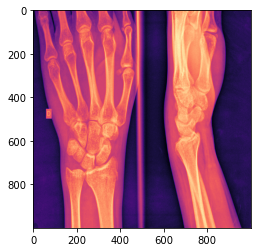

In [347]:

plt.imshow(xray2, 'magma');


In [279]:
vecto = np.ravel(xray2)


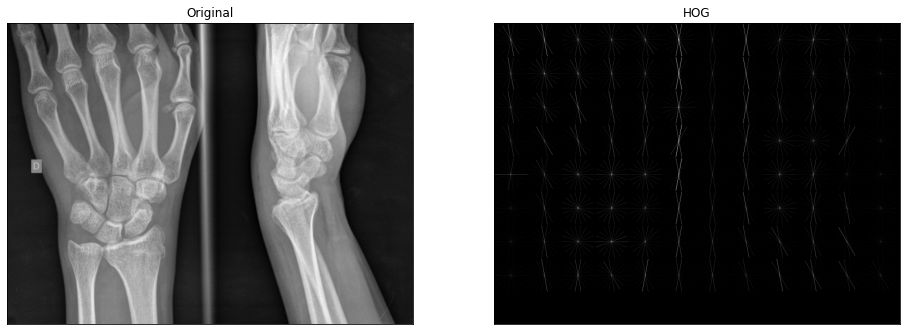

Number of pixels:  442929
Number of HOG features:  2772
np.mean(xray_hog_img): 0.0003925043990108372


In [297]:
## calculate the hog and return a visual representation.
xray_hog, xray_hog_img = hog(
    xray, pixels_per_cell=(64,64), 
    cells_per_block=(2, 2), 
    orientations=9, 
    visualize=True,
    block_norm='L2-Hys')
 
fig, ax = plt.subplots(1,2)
fig.set_size_inches(16,12)
# remove ticks and their labels
[a.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False) 
    for a in ax]
 
ax[0].imshow(np.exp(xray), cmap='gray')
ax[0].set_title('Original')
ax[1].imshow(xray_hog_img, cmap='gray')
ax[1].set_title('HOG')
plt.show()

print('Number of pixels: ', xray.shape[0] * xray.shape[1])
print('Number of HOG features: ', xray_hog.shape[0])
print(f"np.mean(xray_hog_img): {np.mean(xray_hog_img)}")

In [282]:
vetor_img = np.ravel(xray_hog_img)


In [283]:
np.mean(xray_hog_img)


0.0003925043990108372

In [284]:
xray_hog_img.shape


(573, 773)

In [311]:
len(xray_hog)

2772

In [285]:
xray2_hog_r = resize(xray_hog_img, (1000, 1000), anti_aliasing=True)


In [295]:
print('Number of pixels: ', xray.shape[0] * xray.shape[1])
print('Number of HOG features: ', xray_hog.shape[0])


Number of pixels:  442929
Number of HOG features:  2772


# SVD compression

In [312]:
data.shape

(1720, 2320)

In [299]:
u, s, v = np.linalg.svd(data, full_matrices=False)
# inspect shapes of the matrices
print(f'u.shape:{u.shape},s.shape:{s.shape},v.shape:{v.shape}')

u.shape:(1720, 1720),s.shape:(1720,),v.shape:(1720, 2320)


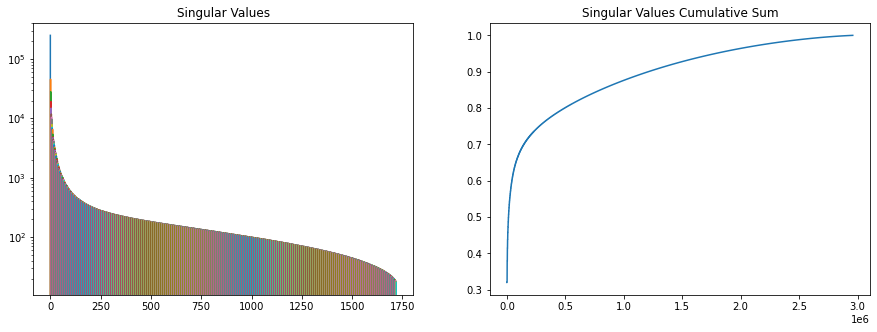

In [339]:
u, s, v = np.linalg.svd(data, full_matrices=False)
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].semilogy(np.diag(s));
ax[0].set_title('Singular Values')
ax[1].plot(np.cumsum(np.diag(s)/np.sum(np.diag(s))));
ax[1].set_title('Singular Values Cumulative Sum');

In [331]:
svd_lst = []
u, s, v = np.linalg.svd(data, full_matrices=False)
for r in (5, 20, 100):
    Xapprox = u[:,:r] @ np.diag(s)[0:r, :r] @ v[:r,:]
    svd_lst.append(Xapprox)    

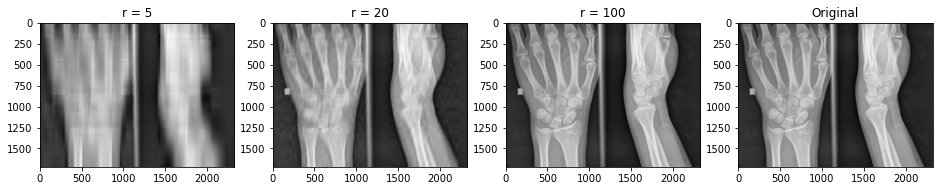

In [344]:
fig, ax = plt.subplots(1,4, figsize=(16,16))
ax[0].imshow(svd_lst[0], cmap='gray')
ax[0].set_title('r = 5')
ax[1].imshow(svd_lst[1], cmap='gray')
ax[1].set_title('r = 20')
ax[2].imshow(svd_lst[2], cmap='gray')
ax[2].set_title('r = 100')
ax[3].imshow(data, cmap='gray')
ax[3].set_title('Original')
plt.show();

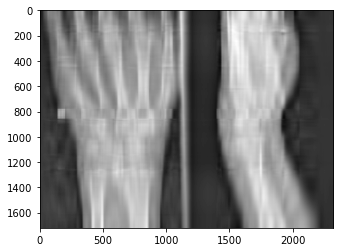

In [346]:
Xapprox = u[:,:10] @ np.diag(s)[0:10, :10] @ v[:10,:]
plt.imshow(Xapprox, 'gray');

In [308]:
np.diag(s)[0:10, :10].shape


(10, 10)

In [309]:
u[:,:10].shape

(1720, 10)

# Image compositions

In [363]:
plot_color_gradients1 = ['viridis', 'plasma', 'inferno', 'magma', 'cividis']
plot_color_gradients2 = ['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds', 'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
                         'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']
plot_color_gradients3 = ['twilight', 'twilight_shifted', 'hsv']
plot_color_gradients4 = ['PiYG', 'PRGn', 'BrBG', 'PuOr', 'RdGy',
                         'RdBu', 'RdYlBu', 'RdYlGn', 'Spectral', 'coolwarm', 'bwr', 'seismic']

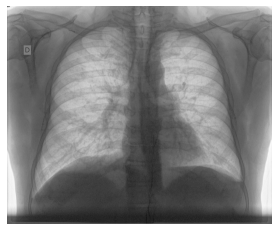

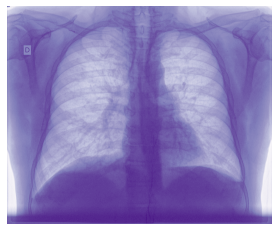

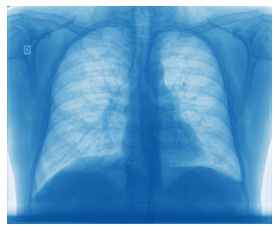

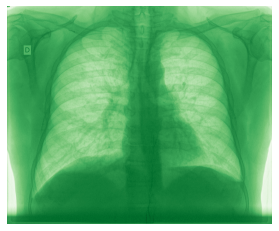

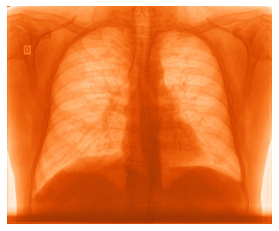

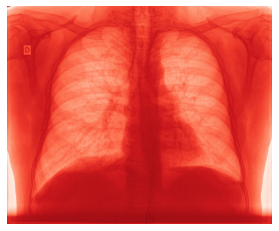

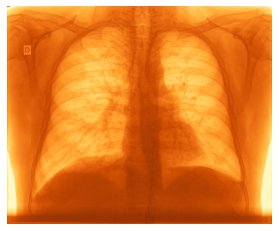

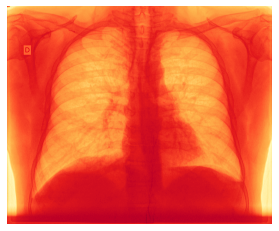

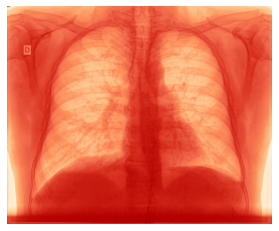

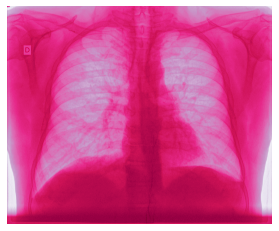

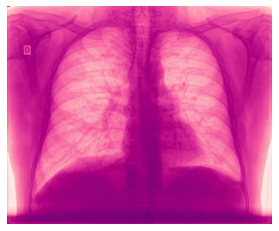

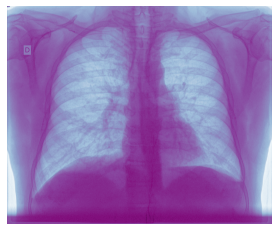

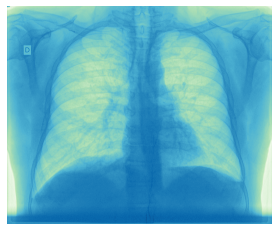

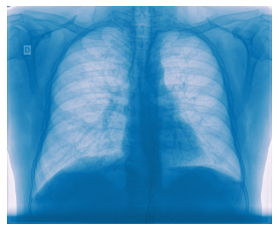

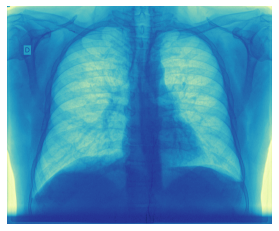

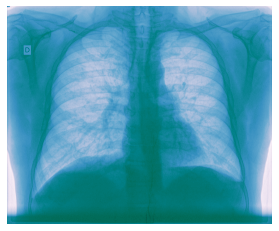

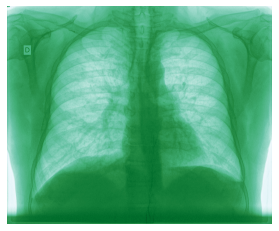

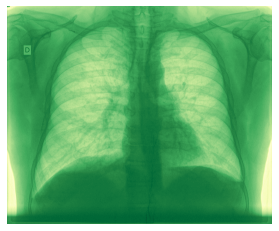

In [357]:
for i in plot_color_gradients2:
    plt.imshow(read_xray(img_train_lst[4]), cmap = i)
    plt.axis('off')
    plt.show()

In [359]:
plot_color_gradients3=['twilight', 'twilight_shifted', 'hsv']

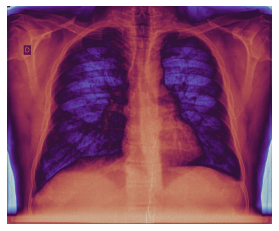

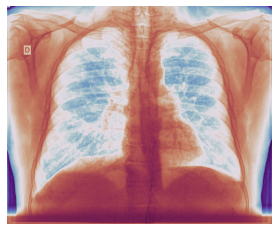

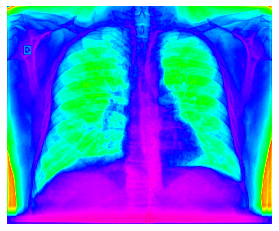

In [360]:
for i in plot_color_gradients3:
    plt.imshow(read_xray(img_train_lst[4]), cmap=i)
    plt.axis('off')
    plt.show()

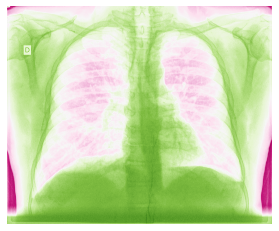

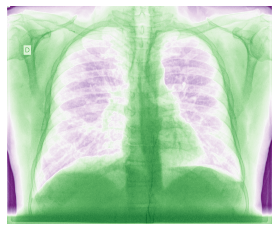

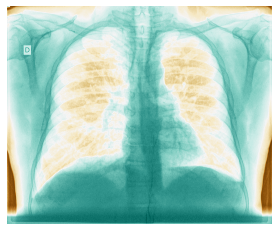

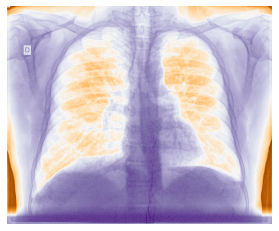

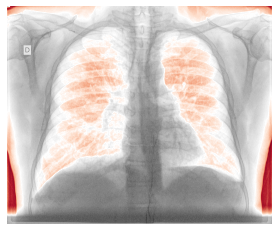

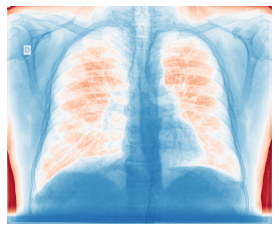

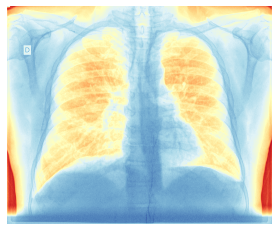

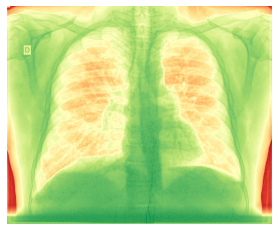

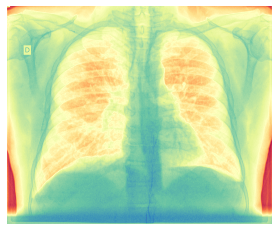

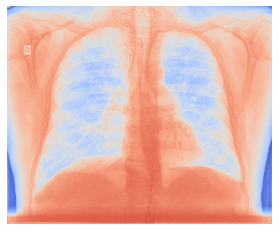

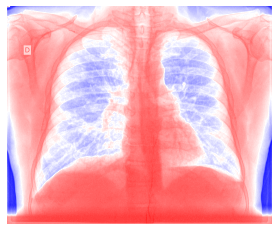

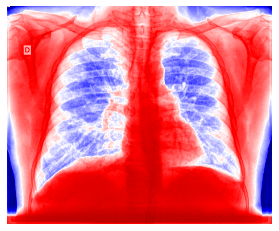

In [364]:
for i in plot_color_gradients4:
    plt.imshow(read_xray(img_train_lst[4]), cmap=i)
    plt.axis('off')
    plt.show()

# Validation